## Fetch Results from DB

In [341]:
from dataclasses import dataclass, field
import math
import os
import random
import time
from typing import List, Dict

from collections import Counter
import csv

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psycopg2
from scipy.interpolate import interp1d

In [342]:
# handle db related stuff

# turn the above into a dictionary using the values
db_params = {
    "dbname": "decision_trees",
    "user": "postgres",
    "password": "postgres",
    "host": "localhost",
    "port": 5432
}

column_names = [
    "name", 
    "iterations", 
    "f1_score", 
    "feature_limit", 
    "feature_table_entries", 
    "max_depth", 
    "num_flows", 
    "num_partitions", 
    "total_features", 
    "tree_table_entries"
]

In [343]:
# table names for each of our datasets

cic_iomt_2024_baseline = "sigcomm_baseline_cic_iomt_2024_pcaps1_f10"
cic_iot_2023_baseline = "sigcomm_baseline_cic_iot_2023_pcaps1_f10"
iscxvpn2016_baseline = "sigcomm_baseline_iscxvpn2016_pcaps0_f10"
ucsbfinetuning_baseline = "sigcomm_baseline_ucsbfinetuning_pcaps0_f10"
cic_iot_2023_32_baseline = "sigcomm_baseline_cic_iot_2023_32_pcaps1_f10"
cic_ids_2017_baseline = "sigcomm_baseline_cic_ids_2017_pcaps1_f10"
cic_ids_2018_baseline = "sigcomm_baseline_cic_ids_2018_pcaps1_f10"

cic_iomt_2024_hypermapper = "hypermapper_cic_iomt_2024_pcaps1_f10_bayesian_optimization"
cic_iot_2023_hypermapper = "hypermapper_cic_iot_2023_pcaps1_f10_bayesian_optimization"
iscxvpn2016_hypermapper = "hypermapper_iscxvpn2016_pcaps0_f10_bayesian_optimization"
ucsbfinetuning_hypermapper = "hypermapper_ucsbfinetuning_pcaps0_f10_bayesian_optimization"
cic_iot_2023_32_hypermapper = "hypermapper_cic_iot_2023_32_pcaps1_f10_bayesian_optimization"
cic_ids_2017_hypermapper = "hypermapper_cic_ids_2017_pcaps1_f10_bayesian_optimization"
cic_ids_2018_hypermapper = "hypermapper_cic_ids_2018_pcaps1_f10_bayesian_optimization"

def get_dataset_entries(baseline_table, hypermapper_table):
    # open a connection with the db
    connection = psycopg2.connect(**db_params)
    cursor = connection.cursor()
    # select all entries from baseline_table
    cursor.execute(f"SELECT * FROM {baseline_table}")
    baseline_entries = cursor.fetchall()
    # select all entries from hypermapper_table
    cursor.execute(f"SELECT * FROM {hypermapper_table}")
    hypermapper_entries = cursor.fetchall()
    # combine the two lists
    entries = baseline_entries + hypermapper_entries
    # close the connection
    cursor.close()
    connection.close()
    return entries

cic_iomt_2024_entries = get_dataset_entries(cic_iomt_2024_baseline, cic_iomt_2024_hypermapper)
cic_iot_2023_entries = get_dataset_entries(cic_iot_2023_baseline, cic_iot_2023_hypermapper)
iscxvpn2016_entries = get_dataset_entries(iscxvpn2016_baseline, iscxvpn2016_hypermapper)
ucsbfinetuning_entries = get_dataset_entries(ucsbfinetuning_baseline, ucsbfinetuning_hypermapper)
cic_iot_2023_32_entries = get_dataset_entries(cic_iot_2023_32_baseline, cic_iot_2023_32_hypermapper)
cic_ids_2017_entries = get_dataset_entries(cic_ids_2017_baseline, cic_ids_2017_hypermapper)
cic_ids_2018_entries = get_dataset_entries(cic_ids_2018_baseline, cic_ids_2018_hypermapper)

# get number of entries in each dataset
print(f"Number of entries in cic_iomt_2024: {len(cic_iomt_2024_entries)}")
print(f"Number of entries in cic_iot_2023: {len(cic_iot_2023_entries)}")
print(f"Number of entries in iscxvpn2016: {len(iscxvpn2016_entries)}")
print(f"Number of entries in ucsbfinetuning: {len(ucsbfinetuning_entries)}")
print(f"Number of entries in cic_iot_2023_32: {len(cic_iot_2023_32_entries)}")
print(f"Number of entries in cic_ids_2017: {len(cic_ids_2017_entries)}")
print(f"Number of entries in cic_ids_2018: {len(cic_ids_2018_entries)}")

Number of entries in cic_iomt_2024: 6906
Number of entries in cic_iot_2023: 10363
Number of entries in iscxvpn2016: 13232
Number of entries in ucsbfinetuning: 7932
Number of entries in cic_iot_2023_32: 5388
Number of entries in cic_ids_2017: 3057
Number of entries in cic_ids_2018: 11289


### Add TCAM Entries and Stateful Memory Columns

In [344]:
# convert these entries into a pandas dataframe
cic_iomt_2024_df = pd.DataFrame(cic_iomt_2024_entries, columns=column_names)
cic_iot_2023_df = pd.DataFrame(cic_iot_2023_entries, columns=column_names)
iscxvpn2016_df = pd.DataFrame(iscxvpn2016_entries, columns=column_names)
ucsbfinetuning_df = pd.DataFrame(ucsbfinetuning_entries, columns=column_names)
cic_iot_2023_32_df = pd.DataFrame(cic_iot_2023_32_entries, columns=column_names)
cic_ids_2017_df = pd.DataFrame(cic_ids_2017_entries, columns=column_names)
cic_ids_2018_df = pd.DataFrame(cic_ids_2018_entries, columns=column_names)

# extend each dataframe to include tcam_entries column = feature_table_entries + tree_table_entries
cic_iomt_2024_df["tcam_entries"] = cic_iomt_2024_df["feature_table_entries"] + cic_iomt_2024_df["tree_table_entries"]
cic_iot_2023_df["tcam_entries"] = cic_iot_2023_df["feature_table_entries"] + cic_iot_2023_df["tree_table_entries"]
iscxvpn2016_df["tcam_entries"] = iscxvpn2016_df["feature_table_entries"] + iscxvpn2016_df["tree_table_entries"]
ucsbfinetuning_df["tcam_entries"] = ucsbfinetuning_df["feature_table_entries"] + ucsbfinetuning_df["tree_table_entries"]
cic_iot_2023_32_df["tcam_entries"] = cic_iot_2023_32_df["feature_table_entries"] + cic_iot_2023_32_df["tree_table_entries"]
cic_ids_2017_df["tcam_entries"] = cic_ids_2017_df["feature_table_entries"] + cic_ids_2017_df["tree_table_entries"]
cic_ids_2018_df["tcam_entries"] = cic_ids_2018_df["feature_table_entries"] + cic_ids_2018_df["tree_table_entries"]

In [345]:
# extend each dataframe to include memory_bits column = tcam_entries * 32
cic_iomt_2024_df['memory_bits'] = cic_iomt_2024_df.apply(
    lambda x: x['total_features'] * x['num_flows'] * 32 if x['name'] in ['leo', 'netbeacon'] else x['feature_limit'] * x['num_flows'] * 32,
    axis=1
)
cic_iot_2023_df['memory_bits'] = cic_iot_2023_df.apply(
    lambda x: x['total_features'] * x['num_flows'] * 32 if x['name'] in ['leo', 'netbeacon'] else x['feature_limit'] * x['num_flows'] * 32,
    axis=1
)
iscxvpn2016_df['memory_bits'] = iscxvpn2016_df.apply(
    lambda x: x['total_features'] * x['num_flows'] * 32 if x['name'] in ['leo', 'netbeacon'] else x['feature_limit'] * x['num_flows'] * 32,
    axis=1
)
ucsbfinetuning_df['memory_bits'] = ucsbfinetuning_df.apply(
    lambda x: x['total_features'] * x['num_flows'] * 32 if x['name'] in ['leo', 'netbeacon'] else x['feature_limit'] * x['num_flows'] * 32,
    axis=1
)
cic_iot_2023_32_df['memory_bits'] = cic_iot_2023_32_df.apply(
    lambda x: x['total_features'] * x['num_flows'] * 32 if x['name'] in ['leo', 'netbeacon'] else x['feature_limit'] * x['num_flows'] * 32,
    axis=1
)
cic_ids_2017_df['memory_bits'] = cic_ids_2017_df.apply(
    lambda x: x['total_features'] * x['num_flows'] * 32 if x['name'] in ['leo', 'netbeacon'] else x['feature_limit'] * x['num_flows'] * 32,
    axis=1
)
cic_ids_2018_df['memory_bits'] = cic_ids_2018_df.apply(
    lambda x: x['total_features'] * x['num_flows'] * 32 if x['name'] in ['leo', 'netbeacon'] else x['feature_limit'] * x['num_flows'] * 32,
    axis=1
)

# extend each dataframe to include memory percentage usage by dividing memory_bits by 120Mb
cic_iomt_2024_df['memory_perc'] = round(cic_iomt_2024_df['memory_bits'] / (120 * 1024 * 1024) * 100, 2)
cic_iot_2023_df['memory_perc'] = round(cic_iot_2023_df['memory_bits'] / (120 * 1024 * 1024) * 100, 2)
iscxvpn2016_df['memory_perc'] = round(iscxvpn2016_df['memory_bits'] / (120 * 1024 * 1024) * 100, 2)
ucsbfinetuning_df['memory_perc'] = round(ucsbfinetuning_df['memory_bits'] / (120 * 1024 * 1024) * 100, 2)
cic_iot_2023_32_df['memory_perc'] = round(cic_iot_2023_32_df['memory_bits'] / (120 * 1024 * 1024) * 100, 2)
cic_ids_2017_df['memory_perc'] = round(cic_ids_2017_df['memory_bits'] / (120 * 1024 * 1024) * 100, 2)
cic_ids_2018_df['memory_perc'] = round(cic_ids_2018_df['memory_bits'] / (120 * 1024 * 1024) * 100, 2)

### Save top-level dataframes

In [346]:
# save the dataframes to csv files with same names as dataframes
top_level_path = "csv/top-level-dataframes"
if not os.path.exists(top_level_path):
    os.makedirs(top_level_path)

cic_iomt_2024_df.to_csv(os.path.join(top_level_path, "cic_iomt_2024_df.csv"), index=False)
cic_iot_2023_df.to_csv(os.path.join(top_level_path, "cic_iot_2023_df.csv"), index=False)
iscxvpn2016_df.to_csv(os.path.join(top_level_path, "iscxvpn2016_df.csv"), index=False)
ucsbfinetuning_df.to_csv(os.path.join(top_level_path, "ucsbfinetuning_df.csv"), index=False)
cic_iot_2023_32_df.to_csv(os.path.join(top_level_path, "cic_iot_2023_32_df.csv"), index=False)
cic_ids_2017_df.to_csv(os.path.join(top_level_path, "cic_ids_2017_df.csv"), index=False)
cic_ids_2018_df.to_csv(os.path.join(top_level_path, "cic_ids_2018_df.csv"), index=False)

# Motivation Plot

In [347]:
# offline motivation plot results 
cic_iomt_2024_mot_dict = {
    'dataset':    'D1',
    'flow_level': 0.57,
    'pkt_level':  0.41,
    'top_k':      0.47,
    # 'top_k_lim':  0.49,
    'top_k_more': 0.56,
    'SpliDT':     0.559332 # 0.58
}

cic_iot_2023_mot_dict = {
    'dataset':    'D2',
    'flow_level': 0.87,
    'pkt_level':  0.56,
    'top_k':      0.78,
    # 'top_k_lim':  0.78,
    'top_k_more': 0.81,
    'SpliDT':     0.827350 # 0.86
}

iscxvpn2016_mot_dict = {
    'dataset':    'D3',
    'flow_level': 0.82,
    'pkt_level':  0.59,
    'top_k':      0.68,
    # 'top_k_lim':  0.72,
    'top_k_more': 0.82,
    'SpliDT':     0.83
}

ucsbfinetuning_mot_dict = {
    'dataset':    'D4',
    'flow_level': 0.75,
    'pkt_level':  0.19,
    'top_k':      0.58,
    # 'top_k_lim':  0.61,
    'top_k_more': 0.71,
    'SpliDT':     0.74
}

cic_iot_2023_32_mot_dict = {
    'dataset':    'D5',
    'flow_level': 0.41,
    'pkt_level':  0.00,
    'top_k':      0.36,
    # 'top_k_lim':  0.37,
    'top_k_more': 0.00,
    'SpliDT':     0.44
}

cic_ids_2017_mot_dict = {
    'dataset':    'D6',
    'flow_level': 0.86,
    'pkt_level':  0.53,
    'top_k':      0.84,
    # 'top_k_lim':  0.81,
    'top_k_more': 0.00,
    'SpliDT':     0.97
}

cic_ids_2018_mot_dict = {
    'dataset':    'D7',
    'flow_level': 1.00,
    'pkt_level':  0.00,
    'top_k':      0.96,
    # 'top_k_lim':  1.00,
    'top_k_more': 0.00,
    'SpliDT':     1.00
}

# convert the above dictionaries into a single dataframe, columns ['name', 'pkt_level', 'flow_level', 'lim_depth', 'top_k', 'CaP']
motivation_df = pd.DataFrame([
    cic_iomt_2024_mot_dict,
    cic_iot_2023_mot_dict,
    iscxvpn2016_mot_dict,
    ucsbfinetuning_mot_dict,
    cic_iot_2023_32_mot_dict,
    cic_ids_2017_mot_dict,
    cic_ids_2018_mot_dict
])

motivation_df

,dataset,flow_level,pkt_level,top_k,top_k_more,SpliDT
0,D1,0.57,0.41,0.47,0.56,0.559332
1,D2,0.87,0.56,0.78,0.81,0.827350
2,D3,0.82,0.59,0.68,0.82,0.830000
3,D4,0.75,0.19,0.58,0.71,0.740000
4,D5,0.41,0.00,0.36,0.00,0.440000
5,D6,0.86,0.53,0.84,0.00,0.970000
6,D7,1.00,0.00,0.96,0.00,1.000000


In [348]:
# offline motivation plot results 
cic_iomt_2024_mot_flows_dict = {
    'dataset':    'D1',
    'flow_level': 500000,
    'pkt_level':  500000,
    'top_k':      500000,
    'top_k_more': 400000,
    'SpliDT':     500000
}

cic_iot_2023_mot_flows_dict = {
    'dataset':    'D2',
    'flow_level': 600000,
    'pkt_level':  600000,
    'top_k':      600000,
    'top_k_more': 400000,
    'SpliDT':     600000
}

iscxvpn2016_mot_flows_dict = {
    'dataset':    'D3',
    'flow_level': 100000,
    'pkt_level':  100000,
    'top_k':      100000,
    'top_k_more': 300000,
    'SpliDT':     300000
}

ucsbfinetuning_mot_flows_dict = {
    'dataset':    'D4',
    'flow_level': 100000,
    'pkt_level':  100000,
    'top_k':      100000,
    'top_k_more': 0.71,
    'SpliDT':     100000
}

# convert the above dictionaries into a single dataframe, columns ['name', 'pkt_level', 'flow_level', 'lim_depth', 'top_k', 'CaP']
motivation_flows_df = pd.DataFrame([
    cic_iomt_2024_mot_dict,
    cic_iot_2023_mot_dict,
    iscxvpn2016_mot_dict,
    ucsbfinetuning_mot_dict,
])

motivation_flows_df

,dataset,flow_level,pkt_level,top_k,top_k_more,SpliDT
0,D1,0.57,0.41,0.47,0.56,0.559332
1,D2,0.87,0.56,0.78,0.81,0.827350
2,D3,0.82,0.59,0.68,0.82,0.830000
3,D4,0.75,0.19,0.58,0.71,0.740000


## Save Motivation DataFrame

In [349]:
# save the dataframes to csv files with same names as dataframes
motivation_path = "csv/motivation-pkt-vs-flow-level"
if not os.path.exists(motivation_path):
    os.makedirs(motivation_path)

motivation_df.to_csv(os.path.join(motivation_path, "pkt_vs_flows.csv"), index=False)

# E2E Pareto Plots

In [350]:
# show all unique num_flows in each dataset
print(f"Unique num_flows in cic_iomt_2024: {cic_iomt_2024_df['num_flows'].unique().tolist()}")
print(f"Unique num_flows in cic_iot_2023: {cic_iot_2023_df['num_flows'].unique().tolist()}")
print(f"Unique num_flows in iscxvpn2016: {iscxvpn2016_df['num_flows'].unique().tolist()}")
print(f"Unique num_flows in ucsbfinetuning: {ucsbfinetuning_df['num_flows'].unique().tolist()}")
print(f"Unique num_flows in cic_iot_2023_32: {cic_iot_2023_32_df['num_flows'].unique().tolist()}")
print(f"Unique num_flows in cic_ids_2017: {cic_ids_2017_df['num_flows'].unique().tolist()}")
print(f"Unique num_flows in cic_ids_2018: {cic_ids_2018_df['num_flows'].unique().tolist()}")

# get the union list of all unique num_flows, exclude 0 and then sort it
unique_num_flows = sorted(list(set(
    cic_iomt_2024_df['num_flows'].unique().tolist() + 
    cic_iot_2023_df['num_flows'].unique().tolist() + 
    iscxvpn2016_df['num_flows'].unique().tolist() + 
    ucsbfinetuning_df['num_flows'].unique().tolist() +
    cic_iot_2023_32_df['num_flows'].unique().tolist() + 
    cic_ids_2017_df['num_flows'].unique().tolist() + 
    cic_ids_2018_df['num_flows'].unique().tolist()
)))
unique_num_flows = [x for x in unique_num_flows if x > 0 and x <= 1000000]

print(f"\nOverall Unique num_flows: {unique_num_flows}")

Unique num_flows in cic_iomt_2024: [1966080, 983040, 491520, 393216, 294912, 1769472, 884736, 589824, 262144, 1572864, 786432, 196608, 1376256, 688128, 1179648, 65536, 2000000]
Unique num_flows in cic_iot_2023: [1966080, 983040, 786432, 491520, 393216, 294912, 1769472, 884736, 589824, 262144, 1572864, 196608, 1376256, 688128, 1179648, 65536, 2000000, 0, 98304]
Unique num_flows in iscxvpn2016: [1966080, 983040, 786432, 491520, 393216, 294912, 1769472, 589824, 262144, 1572864, 196608, 1376256, 1179648, 65536, 2000000]
Unique num_flows in ucsbfinetuning: [1966080, 983040, 786432, 491520, 393216, 294912, 1769472, 589824, 262144, 1572864, 196608, 1376256, 688128, 1179648, 65536, 2000000, 0, 98304]
Unique num_flows in cic_iot_2023_32: [1966080, 983040, 491520, 393216, 294912, 1769472, 884736, 589824, 262144, 1572864, 786432, 196608, 1376256, 688128, 1179648, 65536, 2000000, 0, 98304]
Unique num_flows in cic_ids_2017: [1966080, 983040, 786432, 491520, 393216, 294912, 1769472, 884736, 589824, 

In [351]:
LIST_OF_NUM_FLOWS = [65536, 98304, 196608, 262144, 294912, 393216, 491520, 589824, 688128, 786432, 884736, 983040]

def extend_pareto(this_dataframe, baseline_name):
    
    # 1. fill step
    # fill up all flow counts with f1-score
    for num_flows in LIST_OF_NUM_FLOWS:
        # if this flow count is not present, add it with f1-score 0
        if num_flows not in this_dataframe['num_flows'].values:
            # assign the average F1 of the previous and next flow count
            this_dataframe = this_dataframe.append({
                    "name": baseline_name, 
                    "iterations": 0, 
                    "f1_score": 0, 
                    "feature_limit": 0, 
                    "feature_table_entries": 0, 
                    "max_depth": 0, 
                    "num_flows": num_flows, 
                    "num_partitions": 0, 
                    "total_features": 0, 
                    "tree_table_entries": 0,                    
                }, ignore_index=True)
    
    # sort the dataframe by num_flows
    this_dataframe = this_dataframe.sort_values(by='num_flows')
    
    # start with last flow count
    current_f1_score = this_dataframe[this_dataframe['num_flows'] == LIST_OF_NUM_FLOWS[-1]]['f1_score'].values[0]
    current_model_config = this_dataframe[this_dataframe["num_flows"] == LIST_OF_NUM_FLOWS[-1]].copy()
    
    for i, num_flows in enumerate(reversed(LIST_OF_NUM_FLOWS)):
        if i == 0: 
            continue
        
        # 2. update step
        # at each num_flows, if the f1-score is less than the current f1-score,
        # delete that whole row and replace it with the row corresponding to current f1-score (current_model_config)
        # and then update the num_flows to the current num_flows (which you deleted)
        
        # get the f1-score at this num_flows
        f1_score_at_num_flows = this_dataframe[this_dataframe['num_flows'] == num_flows]['f1_score'].values[0]
        
        # if the f1-score at this num_flows is less than the current f1-score, replace it with the current f1-score
        if f1_score_at_num_flows < current_f1_score:
            # delete this row corresponding to num_flows
            this_dataframe = this_dataframe[this_dataframe['num_flows'] != num_flows]
            
            # now append a copy of the 'current_model_config' row and update it with num_flows
            # create copy of the row with max f1-score
            row_to_copy = current_model_config.copy()
            # update the num_flows in this row
            row_to_copy['num_flows'] = num_flows
                
            # append this row to the dataframe
            this_dataframe = this_dataframe.append(row_to_copy)
        
        else:
            # update the current f1-score and current model config
            current_f1_score = f1_score_at_num_flows
            current_model_config = this_dataframe[this_dataframe["num_flows"] == num_flows].copy()
            
    # sort the dataframe by num_flows
    this_dataframe = this_dataframe.sort_values(by='num_flows')
    
    return this_dataframe


def pareto_processor(
    this_dataframe, name="this_dataframe", 
    min_flows=1, max_flows=1000000, 
    pareto=True, verbose=False
    ):
    
    # separate results from each model
    netbeacon_this_dataframe = this_dataframe[this_dataframe['name'] == 'netbeacon']
    leo_this_dataframe = this_dataframe[this_dataframe['name'] == 'leo']
    cap_this_dataframe = this_dataframe[this_dataframe['name'] == 'cap']

    if verbose:
        # show size of each before pareto
        print(f"\n[Before] Number of entries in netbeacon_{name}: {len(netbeacon_this_dataframe)}")
        print(f"[Before] Number of entries in leo_{name}: {len(leo_this_dataframe)}")
        print(f"[Before] Number of entries in cap_{name}: {len(cap_this_dataframe)}")

    # for cap dataframe, group by num_flows, then within each group, select row with max f1_score
    pareto_netbeacon_this_dataframe = netbeacon_this_dataframe.loc[
        netbeacon_this_dataframe.groupby('num_flows')['f1_score'].idxmax()
    ]
    pareto_leo_this_dataframe = leo_this_dataframe.loc[
        leo_this_dataframe.groupby('num_flows')['f1_score'].idxmax()
    ]
    pareto_cap_this_dataframe = cap_this_dataframe.loc[
        cap_this_dataframe.groupby('num_flows')['f1_score'].idxmax()
    ]

    # # for each dataframe, pick only name, f1_score, num_flows
    # pareto_netbeacon_this_dataframe = pareto_netbeacon_this_dataframe[['name', 'f1_score', 'num_flows']]
    # pareto_leo_this_dataframe = pareto_leo_this_dataframe[['name', 'f1_score', 'num_flows']]
    # pareto_cap_this_dataframe = pareto_cap_this_dataframe[['name', 'f1_score', 'num_flows']]

    if pareto:
        # extend pareto front to include all flow counts
        pareto_netbeacon_this_dataframe = extend_pareto(pareto_netbeacon_this_dataframe, "netbeacon")
        pareto_leo_this_dataframe = extend_pareto(pareto_leo_this_dataframe, "leo")
        pareto_cap_this_dataframe = extend_pareto(pareto_cap_this_dataframe, "cap")

    if verbose:
        # show size of each after pareto
        print(f"\n[After] Number of entries in netbeacon_{name}: {len(pareto_netbeacon_this_dataframe)}")
        print(f"[After] Number of entries in leo_{name}: {len(pareto_leo_this_dataframe)}")
        print(f"[After] Number of entries in cap_{name}: {len(pareto_cap_this_dataframe)}")

    # get name, f1_score, num_flows from pareto front for each model and combine into a single dataframe
    pareto_this_dataframe = pd.concat([
        pareto_netbeacon_this_dataframe,
        pareto_leo_this_dataframe, 
        pareto_cap_this_dataframe
        ], axis=0)

    # drop any rows with number of flows less than 1 or greater than 2M
    pareto_this_dataframe = pareto_this_dataframe[
        (pareto_this_dataframe['num_flows'] >= min_flows) & (pareto_this_dataframe['num_flows'] <= max_flows)
    ]

    return pareto_this_dataframe

### Fix Two Points on D2 (This is because CaP can always revert back to NetBeacon when doing worse with partitions)

In [352]:
# copy the row with name 'netbeacon' and num_flows 786432 to the row with name 'cap' and num_flows 786432

# delete the row with name 'cap' and num_flows 884736
cic_iot_2023_df = cic_iot_2023_df[
    (cic_iot_2023_df['name'] != 'cap') | (cic_iot_2023_df['num_flows'] != 786432)
]

# get the row with name 'netbeacon' and num_flows 884736
row_to_copy = cic_iot_2023_df[
    (cic_iot_2023_df['name'] == 'netbeacon') & (cic_iot_2023_df['num_flows'] == 786432)
].copy()


# update the name to 'cap'
row_to_copy['name'] = 'cap'

# append this row to the dataframe
cic_iot_2023_df = cic_iot_2023_df.append(row_to_copy)
cic_iot_2023_df

,name,iterations,f1_score,feature_limit,feature_table_entries,max_depth,num_flows,num_partitions,total_features,tree_table_entries,tcam_entries,memory_bits,memory_perc
0,leo,0,0.61,0,0,3,1966080,0,1,2048,2048,62914560,50.0
1,leo,0,0.63,0,0,3,983040,0,2,2048,2048,62914560,50.0
2,leo,0,0.71,0,0,8,786432,0,2,2048,2048,50331648,40.0
3,leo,0,0.73,0,0,8,491520,0,3,2048,2048,47185920,37.5
4,leo,0,0.79,0,0,10,393216,0,5,8192,8192,62914560,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10358,cap,0,0.73,2,0,13,983040,1,2,424,424,62914560,50.0
10360,cap,0,0.80,4,0,14,491520,1,4,754,754,62914560,50.0
10361,cap,0,0.81,5,0,15,393216,1,5,1046,1046,62914560,50.0
10362,cap,0,0.81,6,0,15,294912,1,6,898,898,56623104,45.0


In [353]:
pareto_cic_iomt_2024_df = pareto_processor(cic_iomt_2024_df, "cic_iomt_2024")
pareto_cic_iot_2023_df = pareto_processor(cic_iot_2023_df, "cic_iot_2023")
pareto_iscxvpn2016_df = pareto_processor(iscxvpn2016_df, "iscxvpn2016")
pareto_ucsbfinetuning_df = pareto_processor(ucsbfinetuning_df, "ucsbfinetuning")
pareto_cic_iot_2023_32_df = pareto_processor(cic_iot_2023_32_df, "cic_iot_2023_32")
pareto_cic_ids_2017_df = pareto_processor(cic_ids_2017_df, "cic_ids_2017")
pareto_cic_ids_2018_df = pareto_processor(cic_ids_2018_df, "cic_ids_2018")

In [354]:
# show rows with 'cap' in them only
pareto_cic_iomt_2024_df[pareto_cic_iomt_2024_df['name'] == 'cap']
pareto_cic_iot_2023_df[pareto_cic_iot_2023_df['name'] == 'cap']
pareto_iscxvpn2016_df[pareto_iscxvpn2016_df['name'] == 'cap']
pareto_ucsbfinetuning_df[pareto_ucsbfinetuning_df['name'] == 'cap']
pareto_cic_iot_2023_32_df[pareto_cic_iot_2023_32_df['name'] == 'cap']
pareto_cic_ids_2017_df[pareto_cic_ids_2017_df['name'] == 'cap']
pareto_cic_ids_2018_df[pareto_cic_ids_2018_df['name'] == 'cap']

pareto_cic_iot_2023_df

,name,iterations,f1_score,feature_limit,feature_table_entries,max_depth,num_flows,num_partitions,total_features,tree_table_entries,tcam_entries,memory_bits,memory_perc
0,netbeacon,0,0.800000,0,0,13,65536,0,6,3740,3740.0,37748736.0,30.00
0,netbeacon,0,0.800000,0,0,13,98304,0,6,3740,3740.0,37748736.0,30.00
0,netbeacon,0,0.800000,0,0,13,196608,0,6,3740,3740.0,37748736.0,30.00
1,netbeacon,0,0.800000,0,0,13,262144,0,4,4058,4058.0,33554432.0,26.67
2,netbeacon,0,0.800000,0,0,13,294912,0,5,3917,3917.0,47185920.0,37.50
6,netbeacon,0,0.800000,0,0,15,393216,0,2,5028,5028.0,50331648.0,40.00
6,netbeacon,0,0.800000,0,0,15,491520,0,2,5028,5028.0,50331648.0,40.00
6,netbeacon,0,0.800000,0,0,15,589824,0,2,5028,5028.0,50331648.0,40.00
6,netbeacon,0,0.800000,0,0,15,688128,0,2,5028,5028.0,50331648.0,40.00
6,netbeacon,0,0.800000,0,0,15,786432,0,2,5028,5028.0,50331648.0,40.00


## Save Pareto Dataframes

In [355]:
# save the dataframes to csv files with same names as dataframes
e2e_pareto_path = "csv/e2e-pareto-dataframes"
if not os.path.exists(e2e_pareto_path):
    os.makedirs(e2e_pareto_path)

pareto_cic_iomt_2024_df.to_csv(os.path.join(e2e_pareto_path, "pareto_cic_iomt_2024_df.csv"), index=False)
pareto_cic_iot_2023_df.to_csv(os.path.join(e2e_pareto_path, "pareto_cic_iot_2023_df.csv"), index=False)
pareto_iscxvpn2016_df.to_csv(os.path.join(e2e_pareto_path, "pareto_iscxvpn2016_df.csv"), index=False)
pareto_ucsbfinetuning_df.to_csv(os.path.join(e2e_pareto_path, "pareto_ucsbfinetuning_df.csv"), index=False)
pareto_cic_iot_2023_32_df.to_csv(os.path.join(e2e_pareto_path, "pareto_cic_iot_2023_32_df.csv"), index=False)
pareto_cic_ids_2017_df.to_csv(os.path.join(e2e_pareto_path, "pareto_cic_ids_2017_df.csv"), index=False)
pareto_cic_ids_2018_df.to_csv(os.path.join(e2e_pareto_path, "pareto_cic_ids_2018_df.csv"), index=False)

# Inference Latency

## Read flow sizes for each dataset

In [356]:
# save the dataframes to csv files with same names as dataframes
flow_sizes_path = "csv/top-level-flow-sizes"
datasets = [
    "cic_iomt_2024",
    "cic_iot_2023",
    "iscxvpn2016",
    "ucsbfinetuning",
    "cic_iot_2023_32",
    "cic_ids_2017",
    "cic_ids_2018"
]

cic_iomt_2024_flow_sizes_df = pd.read_csv(os.path.join(flow_sizes_path, "cic_iomt_2024_flow_sizes.csv"))
cic_iot_2023_flow_sizes_df = pd.read_csv(os.path.join(flow_sizes_path, "cic_iot_2023_flow_sizes.csv"))
iscxvpn2016_flow_sizes_df = pd.read_csv(os.path.join(flow_sizes_path, "iscxvpn2016_flow_sizes.csv"))
ucsbfinetuning_flow_sizes_df = pd.read_csv(os.path.join(flow_sizes_path, "ucsbfinetuning_flow_sizes.csv"))
cic_iot_2023_32_flow_sizes_df = pd.read_csv(os.path.join(flow_sizes_path, "cic_iot_2023_32_flow_sizes.csv"))
cic_ids_2017_flow_sizes_df = pd.read_csv(os.path.join(flow_sizes_path, "cic_ids_2017_flow_sizes.csv"))
cic_ids_2018_flow_sizes_df = pd.read_csv(os.path.join(flow_sizes_path, "cic_ids_2018_flow_sizes.csv"))

cic_ids_2018_flow_sizes_df

,flow size,count
0,10,297
1,11,320
2,12,225
3,13,235
4,14,343
...,...,...
963,214157,1
964,220366,1
965,221415,1
966,229456,1


In [357]:
# Calculate the weighted average for each dataset
def get_average_flow_size(this_df):
    return (this_df["flow size"] * this_df["count"]).sum() // this_df["count"].sum()

cic_iomt_2024_average_flow_size = get_average_flow_size(cic_iomt_2024_flow_sizes_df)
cic_iot_2023_average_flow_size = get_average_flow_size(cic_iot_2023_flow_sizes_df)
iscxvpn2016_average_flow_size = get_average_flow_size(iscxvpn2016_flow_sizes_df)
ucsbfinetuning_average_flow_size = get_average_flow_size(ucsbfinetuning_flow_sizes_df)
cic_iot_2023_32_average_flow_size = get_average_flow_size(cic_iot_2023_32_flow_sizes_df)
cic_ids_2017_average_flow_size = get_average_flow_size(cic_ids_2017_flow_sizes_df)
cic_ids_2018_average_flow_size = get_average_flow_size(cic_ids_2018_flow_sizes_df)

print("cic_iomt_2024_average_flow_size = ", cic_iomt_2024_average_flow_size)
print("cic_iot_2023_average_flow_size = ", cic_iot_2023_average_flow_size)
print("iscxvpn2016_average_flow_size = ", iscxvpn2016_average_flow_size)
print("ucsbfinetuning_average_flow_size = ", ucsbfinetuning_average_flow_size)
print("cic_iot_2023_32_average_flow_size = ", cic_iot_2023_32_average_flow_size)
print("cic_ids_2017_average_flow_size = ", cic_ids_2017_average_flow_size)
print("cic_ids_2018_average_flow_size = ", cic_ids_2018_average_flow_size)

flow_avg_sizes = {
    "D1": cic_iomt_2024_average_flow_size,
    "D2": cic_iot_2023_average_flow_size,
    "D3": iscxvpn2016_average_flow_size,
    "D4": ucsbfinetuning_average_flow_size,
    "D5": cic_iot_2023_32_average_flow_size,
    "D6": cic_ids_2017_average_flow_size,
    "D7": cic_ids_2018_average_flow_size
}

NETBEACON_PHASES = [2, 4, 8, 32, 256, 512, 2048]
flow_avg_netbeacon_phases = {
    "D1": [2, 4, 8, 32],
    "D2": [2, 4, 8, 32],
    "D3": [2, 4, 8, 32, 256, 512, 2048],
    "D4": [2, 4, 8, 32],
    "D5": [2, 4, 8, 32],
    "D6": [2, 4, 8, 32],
    "D7": [2, 4, 8, 32, 256, 512]
}

cic_iomt_2024_average_flow_size =  36
cic_iot_2023_average_flow_size =  38
iscxvpn2016_average_flow_size =  2913
ucsbfinetuning_average_flow_size =  65
cic_iot_2023_32_average_flow_size =  33
cic_ids_2017_average_flow_size =  31
cic_ids_2018_average_flow_size =  870


## Now Work With Latencies

In [358]:
# all in microseconds
cic_iomt_2024_flow_duration_avg = 100251218.05
cic_iomt_2024_flow_duration_std = 32788593.17
cic_iomt_2024_max_phase_distribution = {16: 0.31, 32: 0.48, 64: 0.21, 128: 0.0, 256: 0.0, 512: 0.0, 1024: 0.0, 2048: 0.0, 4096: 0.0}

cic_iot_2023_flow_duration_avg = 47232195.12
cic_iot_2023_flow_duration_std = 44175535.68
cic_iot_2023_max_phase_distribution = {16: 0.38, 32: 0.46, 64: 0.11, 128: 0.03, 256: 0.01, 512: 0.01, 1024: 0.0, 2048: 0.0, 4096: 0.0}

iscxvpn2016_flow_duration_avg = 69348435.99
iscxvpn2016_flow_duration_std = 47581612.29
iscxvpn2016_max_phase_distribution = {16: 0.18, 32: 0.33, 64: 0.14, 128: 0.06, 256: 0.05, 512: 0.05, 1024: 0.05, 2048: 0.02, 4096: 0.12}

ucsbfinetuning_flow_duration_avg = 8815235.26
ucsbfinetuning_flow_duration_std = 15798809.25
ucsbfinetuning_max_phase_distribution = {16: 0.2, 32: 0.58, 64: 0.15, 128: 0.03, 256: 0.01, 512: 0.01, 1024: 0.0, 2048: 0.0, 4096: 0.0}

cic_iot_2023_32_flow_duration_avg = 100569189.87
cic_iot_2023_32_flow_duration_std = 28600316.39
cic_iot_2023_32_max_phase_distribution = {16: 0.52, 32: 0.26, 64: 0.22, 128: 0.0, 256: 0.0, 512: 0.0, 1024: 0.0, 2048: 0.0, 4096: 0.0}

cic_ids_2017_flow_duration_avg = 40605076.46
cic_ids_2017_flow_duration_std = 46135779.78
# from the max phase distribution of the dataset
cic_ids_2017_max_phase_distribution = {16: 0.63, 32: 0.19, 64: 0.12, 128: 0.04, 256: 0.01, 512: 0.01, 1024: 0.0, 2048: 0.0, 4096: 0.0}

cic_ids_2018_flow_duration_avg = 8208116.25
cic_ids_2018_flow_duration_std = 27677033.83
cic_ids_2018_max_phase_distribution = {16: 0.03, 32: 0.06, 64: 0.9, 128: 0.0, 256: 0.0, 512: 0.0, 1024: 0.0, 2048: 0.0, 4096: 0.01}

latency_data = {
    "D1": (cic_iomt_2024_flow_duration_avg, cic_iomt_2024_flow_duration_std, cic_iomt_2024_max_phase_distribution),
    "D2": (cic_iot_2023_flow_duration_avg, cic_iot_2023_flow_duration_std, cic_iot_2023_max_phase_distribution),
    "D3": (iscxvpn2016_flow_duration_avg, iscxvpn2016_flow_duration_std, iscxvpn2016_max_phase_distribution),
    "D4": (ucsbfinetuning_flow_duration_avg, ucsbfinetuning_flow_duration_std, ucsbfinetuning_max_phase_distribution),
    "D5": (cic_iot_2023_32_flow_duration_avg, cic_iot_2023_32_flow_duration_std, cic_iot_2023_32_max_phase_distribution),
    "D6": (cic_ids_2017_flow_duration_avg, cic_ids_2017_flow_duration_std, cic_ids_2017_max_phase_distribution),
    "D7": (cic_ids_2018_flow_duration_avg, cic_ids_2018_flow_duration_std, cic_ids_2018_max_phase_distribution)
}

### Populate Inference Latencies

In [359]:
# randomize the seed generator for this experiment
random.seed(time.time())

TOFINO_PIPELINE_LATENCY_us = 800 # us
NETBEACON_PHASES = [2, 4, 8, 32, 256, 512, 2048]
DATASETS_AND_CAP_PARTITIONS = [
    ('D1', '100K', 3), 
    ('D1', '500K', 3), 
    ('D1', '1M', 1), 
    ('D2', '100K', 2), 
    ('D2', '500K', 3), 
    ('D2', '1M', 2), 
    ('D3', '100K', 2), 
    ('D3', '500K', 4), 
    ('D3', '1M', 1), 
    ('D4', '100K', 1), 
    ('D4', '500K', 1), 
    ('D4', '1M', 1), 
    ('D5', '100K', 5), 
    ('D5', '500K', 1), 
    ('D5', '1M', 1), 
    ('D6', '100K', 5), 
    ('D6', '500K', 3), 
    ('D6', '1M', 2), 
    ('D7', '100K', 5), 
    ('D7', '500K', 6), 
    ('D7', '1M', 1)
]

leo_inference_us, cap_inference_us, netbeacon_inference_us = [], [], []

NUM_FLOWS = 100000
for dataset, num_flows, cap_partitions in DATASETS_AND_CAP_PARTITIONS:
    flow_avg_us, flow_std_us, max_phase_distribution = latency_data[dataset]
    
    # determine NetBeacon inference latency for this dataset
    phase_weights = flow_avg_netbeacon_phases[dataset] # Higher weights for bigger numbers
    select_phases = random.choices(flow_avg_netbeacon_phases[dataset], weights=phase_weights, k=NUM_FLOWS)
    average_phase = sum(select_phases) / len(select_phases)
    phase_ratio = average_phase / flow_avg_sizes[dataset]  # this is NOT wrong!!! phase is number of packets
    this_netbeacon_inference_us = round(flow_avg_us * phase_ratio + TOFINO_PIPELINE_LATENCY_us, 2)
    
    # determine Leo inference latency for this dataset
    this_leo_inference_us = flow_avg_us + TOFINO_PIPELINE_LATENCY_us

    # determine CaP inference latency for this dataset
    partition_weights = [2**i for i in range(1, cap_partitions + 1)] # Higher weights for bigger numbers
    select_partitions = random.choices(range(1, cap_partitions + 1), weights=partition_weights, k=NUM_FLOWS)
    average_partition = sum(select_partitions) / len(select_partitions)
    partition_ratio = average_partition / cap_partitions
    this_cap_inference_us = round(flow_avg_us * partition_ratio + TOFINO_PIPELINE_LATENCY_us, 2)
    
    # append results for all models
    netbeacon_inference_us += [('netbeacon', dataset, num_flows, this_netbeacon_inference_us)]
    leo_inference_us += [('leo', dataset, num_flows, this_leo_inference_us)]
    cap_inference_us += [('cap', dataset, num_flows, this_cap_inference_us)]

    print(this_leo_inference_us, this_cap_inference_us, partition_ratio)

print(netbeacon_inference_us)
print(leo_inference_us)
print(cap_inference_us)

100252018.05 81079640.94 0.8087566666666667
100252018.05 81094678.62 0.8089066666666667
100252018.05 100252018.05 1.0
47232995.12 39395993.14 0.834075
47232995.12 38240772.37 0.8096166666666668
47232995.12 39331993.52 0.83272
69349235.99 57813470.41 0.833655
69349235.99 56721926.02 0.817915
69349235.99 69349235.99 1.0
8816035.26 8816035.26 1.0
8816035.26 8816035.26 1.0
8816035.26 8816035.26 1.0
100569989.87 83671952.31 0.831976
100569989.87 100569989.87 1.0
100569989.87 100569989.87 1.0
40605876.46 33825234.74 0.83301
40605876.46 32854096.66 0.8090933333333333
40605876.46 33840055.59 0.833375
8208916.25 6826751.55 0.8316100000000001
8208916.25 6971679.53 0.8492666666666667
8208916.25 8208916.25 1.0
[('netbeacon', 'D1', '100K', 67190614.41), ('netbeacon', 'D1', '500K', 67174017.26), ('netbeacon', 'D1', '1M', 67082343.09), ('netbeacon', 'D2', '100K', 29893832.56), ('netbeacon', 'D2', '500K', 29964133.95), ('netbeacon', 'D2', '1M', 29932239.79), ('netbeacon', 'D3', '100K', 37683635.49), (

In [360]:
# save the accuracies to a CSV file with same name as the dataframe
inference_time_path = "csv/e2e-inference-timing"
if not os.path.exists(inference_time_path):
    os.makedirs(inference_time_path)

# Convert to DataFrame
inference_time_us_df = pd.DataFrame(
    netbeacon_inference_us + leo_inference_us + cap_inference_us, 
    columns=['model', 'dataset', 'num_flows', 'inference_time_us']
)

# combined TTA dataframes
inference_time_us_df.to_csv(os.path.join(inference_time_path, "inference_time.csv"), index=False)

# Inference Latency CDF (from Data Center Distributions)

In [361]:
webserver_fct_ms_cdf = {
    0.00: 0.9,
    0.10: 1,
    0.20: 2,
    0.30: 40,
    0.40: 150,
    0.50: 700,
    0.60: 3000,
    0.70: 30000,
    0.80: 60000,
    0.90: 149910,
    1.00: 150010
}

hadoop_fct_ms_cdf = {
    0.00: 0.8,
    0.10: 0.9,
    0.20: 1.1,
    0.30: 2,
    0.40: 3,
    0.50: 130,
    0.60: 9090,
    0.70: 10010,
    0.80: 12000,
    0.90: 30000,
    0.95: 100000,
    1.00: 200000,
}

In [362]:
NUM_POINTS = 100

# interpolate the CDFs
x_original = np.array(list(webserver_fct_ms_cdf.keys()))
y_original = np.array(list(webserver_fct_ms_cdf.values()))

# Generate 'NUM_POINTS' equally spaced values between 0 and 0.9
x_interpolated = np.linspace(0, 1.0, NUM_POINTS)
y_interpolated = np.interp(x_interpolated, x_original, y_original)

# assign back to dictionary
webserver_fct_ms_cdf = dict(zip(x_interpolated, y_interpolated))

# interpolate the CDFs
x_original = np.array(list(hadoop_fct_ms_cdf.keys()))
y_original = np.array(list(hadoop_fct_ms_cdf.values()))

# Generate 'NUM_POINTS' equally spaced values between 0 and 0.9
x_interpolated = np.linspace(0, 1.0, NUM_POINTS)
y_interpolated = np.interp(x_interpolated, x_original, y_original)

# assign back to dictionary
hadoop_fct_ms_cdf = dict(zip(x_interpolated, y_interpolated))

## Testing Perplexity to Generate PDF from CDF and Back

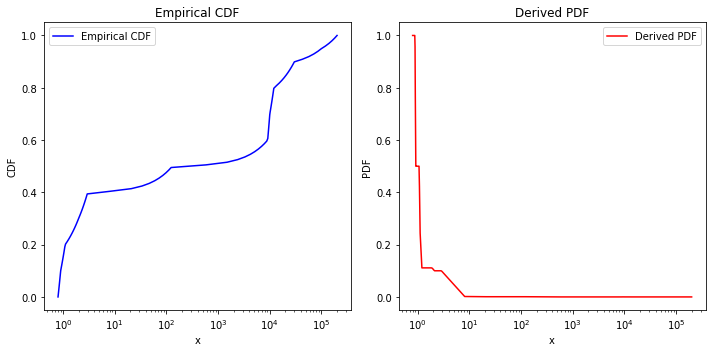

In [363]:
# Example empirical CDF data
# x = np.array([107.67, 430.70, 1975.06, 7793.52, 27569.67, 62566.73, 222847.14, 832591.89, 2827054.74, 10000733.57])
# y = np.array([0.0016, 0.0481, 0.0982, 0.1419, 0.2720, 0.4659, 0.6009, 0.6797, 0.8401, 0.9428])

x = np.array(list(hadoop_fct_ms_cdf.values()))
y = np.array(list(hadoop_fct_ms_cdf.keys()))

# Compute numerical derivative for PDF
dy_dx = np.gradient(y, x)

# Plotting
plt.figure(figsize=(10, 5))

# Plot Empirical CDF
plt.subplot(1, 2, 1)
plt.plot(x, y, label='Empirical CDF', color='blue')
plt.xscale('log')  # Set x-axis to log scale (base 10)
plt.xlabel('x')
plt.ylabel('CDF')
plt.title('Empirical CDF')
plt.legend()

# Plot Derived PDF
plt.subplot(1, 2, 2)
plt.plot(x, dy_dx, label='Derived PDF', color='red')
plt.xscale('log')  # Set x-axis to log scale (base 10)
plt.xlabel('x')
plt.ylabel('PDF')
plt.title('Derived PDF')
plt.legend()

plt.tight_layout()
plt.show()

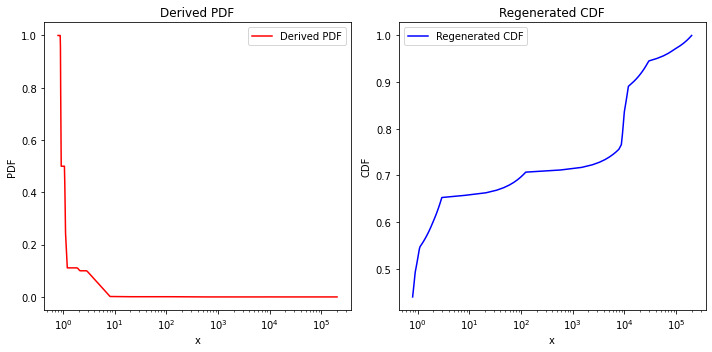

In [364]:
# Example data: x and derived PDF (dy_dx from previous step)
# x = np.array([107.67, 430.70, 1975.06, 7793.52, 27569.67, 62566.73, 222847.14, 832591.89, 2827054.74, 10000733.57])
# pdf = np.gradient(np.array([0.0016, 0.0481, 0.0982, 0.1419, 0.2720, 0.4659, 0.6009, 0.6797, 0.8401, 0.9428]), x)

# Compute CDF using cumulative trapezoidal integration
cdf = np.cumsum(dy_dx * np.diff(np.hstack(([0], x))))

# Normalize CDF to range [0, 1]
cdf = cdf / cdf[-1]

# Plotting
plt.figure(figsize=(10, 5))

# Plot Derived PDF
plt.subplot(1, 2, 1)
plt.plot(x, dy_dx, label='Derived PDF', color='red')
plt.xscale('log')  # Set x-axis to log scale (base 10)
plt.xlabel('x')
plt.ylabel('PDF')
plt.title('Derived PDF')
plt.legend()

# Plot Regenerated CDF
plt.subplot(1, 2, 2)
plt.plot(x, cdf, label='Regenerated CDF', color='blue')
plt.xscale('log')  # Set x-axis to log scale (base 10)
plt.xlabel('x')
plt.ylabel('CDF')
plt.title('Regenerated CDF')
plt.legend()

plt.tight_layout()
plt.show()

## PDF From ECDF for Social Network's (Data Center) Network

### Generate PDF from Emperical CDF

In [365]:
x = np.array(list(webserver_fct_ms_cdf.values()))
y = np.array(list(webserver_fct_ms_cdf.keys()))

# Compute numerical derivative for PDF
webserver_pdf_prob = list(np.gradient(y, x))[1:]
webserver_pdf_fct = list(x)[1:]

x = np.array(list(hadoop_fct_ms_cdf.values()))
y = np.array(list(hadoop_fct_ms_cdf.keys()))

# Compute numerical derivative for PDF
hadoop_pdf_prob = list(np.gradient(y, x))[1:]
hadoop_pdf_fct = list(x)[1:]

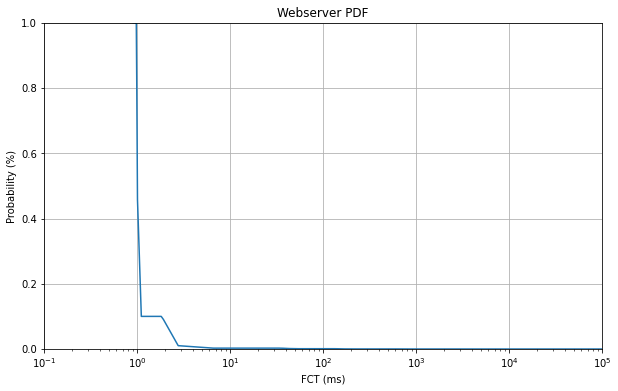

In [366]:
# Plot the PDF
plt.figure(figsize=(10, 6))
plt.plot(webserver_pdf_fct, webserver_pdf_prob, linestyle='-')
plt.xscale('log')  # Set x-axis to log scale (base 10)
plt.xlim(0.1, 1e5)
plt.ylim(0.0, 1.0)
plt.title('Webserver PDF')
plt.xlabel('FCT (ms)')
plt.ylabel('Probability (%)')
plt.grid(True)
plt.show()

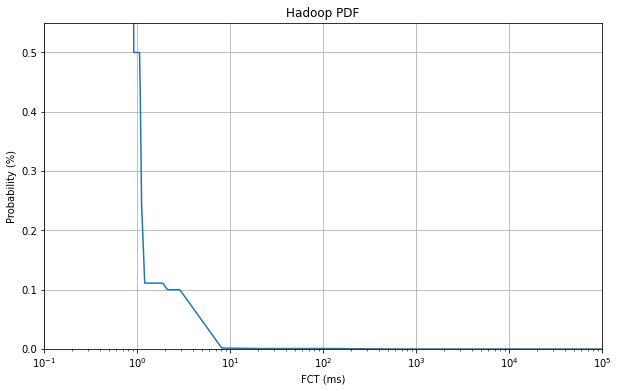

In [367]:
# Plot the PDF
plt.figure(figsize=(10, 6))
plt.plot(hadoop_pdf_fct, hadoop_pdf_prob, linestyle='-')
plt.xscale('log')  # Set x-axis to log scale (base 10)
plt.xlim(0.1, 1e5)
plt.ylim(0.0, 0.55)
plt.title('Hadoop PDF')
plt.xlabel('FCT (ms)')
plt.ylabel('Probability (%)')
plt.grid(True)
plt.show()

## Direct Sampling from ECDF

In [368]:
# Convert ECDF to lists for processing
probabilities = list(hadoop_fct_ms_cdf.keys())
values = list(hadoop_fct_ms_cdf.values())

# Function to sample from the ECDF
def sample_from_ecdf(ecdf_probs, ecdf_values, n_samples=1):
    samples = []
    for _ in range(n_samples):
        # Generate a random number from [0, 1]
        u = np.random.uniform(0, 1)
        
        # Find the value corresponding to the random number (interpolation)
        for i in range(len(ecdf_probs) - 1):
            if ecdf_probs[i] <= u <= ecdf_probs[i + 1]:
                # Linear interpolation
                x1, x2 = ecdf_probs[i], ecdf_probs[i + 1]
                y1, y2 = ecdf_values[i], ecdf_values[i + 1]
                value = y1 + (y2 - y1) * ((u - x1) / (x2 - x1))
                samples.append(value)
                break
    
    return samples

# Generate 5 samples from the ECDF
samples = sample_from_ecdf(probabilities, values, n_samples=100)

print(samples)

[38449.31862187971, 1.7030286076121195, 1.0587911500848406, 0.8305149051635851, 1.0351693551616348, 0.9048030467229456, 5547.036034881434, 12958.602809250826, 1.4377138281511328, 83380.26542172307, 11488.63541283927, 9392.048031528415, 144125.98397858388, 8360.18385683489, 12050.957986853988, 158809.88883938236, 21407.474800072097, 9166.389076381894, 3.8562211478702553, 29182.664749764128, 0.8139519752840524, 146137.98941391753, 146568.2820125592, 2.0091506737031173, 9977.489432311564, 6759.08654902104, 16826.418391401545, 2.671410163042471, 2.2886674678936445, 7.904850374571166, 156545.02983569083, 0.8330901152624686, 9698.918383695194, 0.8137825598162529, 49900.38131729082, 21514.41810893673, 1.8450441463241467, 6793.514678676601, 189628.4538645437, 28046.845282409315, 11281.686515082865, 1.2706954912036466, 2.12388279556735, 2.0368622807735566, 0.8091815257484903, 1.623706136468038, 3996.2951644261543, 1.9182149011430187, 0.8767007958367918, 1.5318252433016728, 0.8167057713435317, 1

## Sample NetBeacon, Leo, CaP Time-to-Detection Using These Distributions

In [369]:
# randomize the seed generator for this experiment
random.seed(time.time())

def get_cdf(this_distribution):
    # sort the distribution and generate CDF
    this_distribution_sorted = np.sort(this_distribution)
    this_distribution_cdf = np.linspace(0, 1, len(this_distribution_sorted))
    return list(zip(this_distribution_sorted, this_distribution_cdf))
    

# both 'these_probabilities' and 'these_values' are from ECDF
def generate_time_to_detect_cdf(these_probabilities, these_values):
    """
        Generate CDF for time-to-detect (TTD) for each model type
        Dataset D3 (ISCXVPN2016) is used for this experiment
    """

    TOFINO_PIPELINE_LATENCY_ns = 800 # ns
    TOFINO_PIPELINE_LATENCY_us = 800 / 1e3 # us
    TOFINO_PIPELINE_LATENCY_ms = 800 / 1e6 # ms
    
    SELECTED_DATASET_CAP_PARTITION = ('D3', '500K', 4)

    # D3_AVERAGE_NETBEACON_PHASES = [2, 4, 8, 32, 256, 512, 2048]
    # D3_MAX_PHASE_DISTRIBUTION = {16: 0.18, 32: 0.33, 64: 0.14, 128: 0.06, 256: 0.05, 512: 0.05, 1024: 0.05, 2048: 0.02, 4096: 0.12}
    
    # D3_AVERAGE_NETBEACON_PHASES = [16, 32, 64, 128, 256, 512, 1024, 2048, 4096]
    # D3_PHASE_PROBABILITIES = [0.18, 0.33, 0.14, 0.06, 0.05, 0.05, 0.05, 0.02, 0.12]
    
    # normalize the phases to get probabilities
    D3_AVERAGE_NETBEACON_PHASES = [2, 4, 8, 32, 256, 512, 2048]
    D3_PHASE_PROBABILITIES = [x / sum(D3_AVERAGE_NETBEACON_PHASES) for x in D3_AVERAGE_NETBEACON_PHASES]
    
    D3_AVERAGE_FLOW_SIZE = flow_avg_sizes['D3']

    NUM_FLOWS = 1000
    sampled_fct_dc = sample_from_ecdf(these_probabilities, these_values, n_samples=NUM_FLOWS)
    
    print(sampled_fct_dc)

    sampled_netbeacon_phases = np.random.choice(
        D3_AVERAGE_NETBEACON_PHASES, size=NUM_FLOWS, p=D3_PHASE_PROBABILITIES
    )

    CAP_MAX_PARTITIONS = 4
    cap_partitions = list(range(1, CAP_MAX_PARTITIONS + 1))
    # Higher weights for bigger numbers
    cap_partition_weights = [2**i for i in cap_partitions]
    cap_partition_probabilities = [x / sum(cap_partition_weights) for x in cap_partition_weights]
    sampled_cap_partitions = np.random.choice(
        cap_partitions, size=NUM_FLOWS, p=cap_partition_probabilities
    )

    netbeacon_ttd, leo_ttd, cap_ttd = [], [], []
    for idx, this_sample_fct in enumerate(sampled_fct_dc):
        # netbeacon TTD
        # sample a phase from the netbeacon phase distribution
        sampled_phase = sampled_netbeacon_phases[idx]
        phase_ratio = sampled_phase / D3_AVERAGE_FLOW_SIZE
        netbeacon_this_sample_fct = round((this_sample_fct * phase_ratio) + TOFINO_PIPELINE_LATENCY_ms, 2)
        netbeacon_ttd += [netbeacon_this_sample_fct]
        
        # Leo TTD (same as FCT; has to wait for a full flow)
        leo_this_sample_fct = this_sample_fct + TOFINO_PIPELINE_LATENCY_ms
        leo_ttd += [leo_this_sample_fct]
        
        # CaP TTD
        # determine CaP inference latency for this dataset
        sampled_partition = sampled_cap_partitions[idx]
        partition_ratio = sampled_partition / CAP_MAX_PARTITIONS
        cap_this_sample_fct = round(this_sample_fct * partition_ratio + TOFINO_PIPELINE_LATENCY_ms, 2)    
        cap_ttd += [cap_this_sample_fct]
        pass
    
    # convert to set
    netbeacon_ttd = list(netbeacon_ttd)
    leo_ttd = list(leo_ttd)
    cap_ttd = list(cap_ttd)
    
    # print("yes")
    # # print(len(netbeacon_ttd), len(leo_ttd), len(cap_ttd))
    # print(netbeacon_ttd)
    # print(leo_ttd)
    # print(cap_ttd)
    
    # generate CDFs for each TTD
    netbeacon_cdf = get_cdf(netbeacon_ttd)
    leo_cdf = get_cdf(leo_ttd)
    cap_cdf = get_cdf(cap_ttd)
    
    # add model labels to each CDF
    netbeacon_cdf = [('netbeacon',) + x for x in netbeacon_cdf]
    leo_cdf = [('leo',) + x for x in leo_cdf]
    cap_cdf = [('cap',) + x for x in cap_cdf]

    return netbeacon_cdf, leo_cdf, cap_cdf

In [370]:
webserver_fct_ms_probabilities = list(webserver_fct_ms_cdf.keys())
webserver_fct_ms_values = list(webserver_fct_ms_cdf.values())

hadoop_fct_ms_probabilities = list(hadoop_fct_ms_cdf.keys())
hadoop_fct_ms_values = list(hadoop_fct_ms_cdf.values())

ws_netbeacon_cdf, ws_leo_cdf, ws_cap_cdf = generate_time_to_detect_cdf(webserver_fct_ms_probabilities, webserver_fct_ms_values)
hd_netbeacon_cdf, hd_leo_cdf, hd_cap_cdf = generate_time_to_detect_cdf(hadoop_fct_ms_probabilities, hadoop_fct_ms_values)

print(len(ws_netbeacon_cdf), len(ws_leo_cdf), len(ws_cap_cdf))
print(len(hd_netbeacon_cdf), len(hd_leo_cdf), len(hd_cap_cdf))

[1.2899116756293416, 149983.75328240998, 0.9828245252492854, 578.3021179363353, 12.405054016405733, 45.103415140931126, 0.9085958109001558, 1.0881770751291686, 2818.3566747362042, 334.8619953874198, 1443.1697004621456, 1787.757268157955, 1.5745570664080377, 0.9153180113491868, 0.9829724009793321, 32222.187980486844, 1.3736218878947382, 33.44884918320865, 14.209563738021483, 1752.739483346178, 149929.49518805256, 149962.58236292974, 109854.15971294398, 1075.002414640386, 136455.77840667882, 2.7506526709651835, 43.17142133597639, 0.9604363496247896, 5.865492773455356, 57579.55021374746, 149931.93456546072, 987.0988853850149, 609.5588173979711, 1.5401255707218087, 36751.607776143836, 80.43957292786453, 0.9663351343892849, 184.2772998425875, 1841.9143727805445, 60.03896424397021, 99326.98303832825, 1.5206028302371022, 149941.3674471878, 14999.967519402458, 1396.8589278276731, 0.9803347841196615, 659.2533849291157, 53990.883550741535, 46786.88994490108, 1.0723447020941879, 39049.01369386662

In [371]:
# combine all CDFs into a dataframe
ws_cdf_df = pd.DataFrame(ws_netbeacon_cdf + ws_leo_cdf + ws_cap_cdf, columns=['name', 'ttd', 'cdf'])
hd_cdf_df = pd.DataFrame(hd_netbeacon_cdf + hd_leo_cdf + hd_cap_cdf, columns=['name', 'ttd', 'cdf'])

hd_cdf_df

,name,ttd,cdf
0,netbeacon,0.00,0.000000
1,netbeacon,0.00,0.001001
2,netbeacon,0.00,0.002002
3,netbeacon,0.00,0.003003
4,netbeacon,0.00,0.004004
...,...,...,...
2995,cap,183932.36,0.995996
2996,cap,184650.17,0.996997
2997,cap,189600.28,0.997998
2998,cap,193452.41,0.998999


In [372]:
# get mean ttd from ws_cdf_df
ws_mean_ttd = ws_cdf_df['ttd'].mean()
hd_mean_ttd = hd_cdf_df['ttd'].mean()

ws_std_ttd = ws_cdf_df['ttd'].std()
hd_std_ttd = hd_cdf_df['ttd'].std()

# print(ws_mean_ttd, hd_mean_ttd)
# print(ws_std_ttd, hd_std_ttd)

print(f"Webserver Mean TTD (ms): {ws_mean_ttd:.2f}")
print(f"Webserver Std Dev TTD (ms): {ws_std_ttd:.2f}")

print(f"Hadoop Mean TTD (ms): {hd_mean_ttd:.2f}")
print(f"Hadoop Std Dev TTD (ms): {hd_std_ttd:.2f}")

Webserver Mean TTD (ms): 22162.02
Webserver Std Dev TTD (ms): 41112.87
Hadoop Mean TTD (ms): 12119.33
Hadoop Std Dev TTD (ms): 29511.53


### Testing Resubmission Traffic

In [373]:
def get_resubmitted_traffic(num_partitions, mean_ttd, std_ttd, total_flows):
    resubmitted_bits_per_flow = 128
    total_Mbits = (total_flows * resubmitted_bits_per_flow) / 1024 / 1024

    mean_ttd_s = mean_ttd / 1e3
    window_time = mean_ttd_s / num_partitions
    total_traffic = total_Mbits / window_time
        
    print(f"Total MBits (Mean): {round(total_Mbits, 2)}")
    print(f"Total Traffic Mbps (Mean): {round(total_traffic, 2)}")
    
    std_ttd_s = std_ttd / 1e3
    window_time = std_ttd_s / num_partitions
    total_traffic = total_Mbits / window_time
    
    # print(f"Total MBits (Mean): {total_Mbits}")
    print(f"Total Traffic Mbps (std): {round(total_traffic, 2)}")

print("Webserver:")
ws_resubmitted_traffic = get_resubmitted_traffic(3, ws_mean_ttd, ws_std_ttd, 100*1e3)
print("Hadoop:")
hd_resubmitted_traffic = get_resubmitted_traffic(3, hd_mean_ttd, hd_std_ttd, 100*1e3)

Webserver:
Total MBits (Mean): 12.21
Total Traffic Mbps (Mean): 1.65
Total Traffic Mbps (std): 0.89
Hadoop:
Total MBits (Mean): 12.21
Total Traffic Mbps (Mean): 3.02
Total Traffic Mbps (std): 1.24


### Write TTD to CSVs

In [374]:
# save the accuracies to a CSV file with same name as the dataframe
inference_time_path = "csv/bm-time-to-detection"
if not os.path.exists(inference_time_path):
    os.makedirs(inference_time_path)

# combined TTA dataframes
ws_cdf_df.to_csv(os.path.join(inference_time_path, "dc1_ttd.csv"), index=False)
hd_cdf_df.to_csv(os.path.join(inference_time_path, "dc2_ttd.csv"), index=False)

# Time to Accuracy

In [375]:
DOE_TIME_LINE = 205
TOTAL_BLACK_BOX_FUNCTION_TIME_LINE = 18
TOTAL_ITERATION_TIME_LINE = 19
FIRST_ITERATION_RESULT = 2
LAST_ITERATION_RESULT = 17

@dataclass
class TTA:
    dataset: str = ""
    # type of dictionary mapping int to float
    partition_fetch_time: Dict[int, float] = field(default_factory=dict)
    doe_time: float = 0.0
    total_black_box_function_time: float = 0.0
    total_iteration_time: float = 0.0
    total_iterations: int = 0
    best_f1_score: float = 0.0
    best_f1_score_flows: float = 0.0
    best_f1_score_iteration: int = 0
    accuracies: List[float] = field(default_factory=list)
    
    def black_box_time(self):
        # get ratio of black box function time to total iteration time
        ratio = self.total_black_box_function_time / self.total_iteration_time
        assert ratio < 1.0
        # this ratio of tta with doe is the time spent in the black box function
        return round(ratio * self.tta(doe=True))
    
    def tta(self, doe=True):
        average_iter_time = round(self.total_iteration_time / self.total_iterations, 2)
        tta_without_doe = self.best_f1_score_iteration * average_iter_time
        return round(self.doe_time + tta_without_doe) if doe else round(tta_without_doe)

    def __str__(self):
        return f"\n\tBest F1 Score: {self.best_f1_score} (Flows: {self.best_f1_score_flows})\n" \
            + f"\tDoE: {round(self.doe_time)} (sec)\n" \
            + f"\tBest Iteration: {self.best_f1_score_iteration}\n" \
            + f"\tAverage Iteration Time: {round(self.total_iteration_time / self.total_iterations, 2)} (sec)\n" \
            + f"\tTotal Black Box Function Time: {self.black_box_time()} (sec)\n" \
            + f"\tTTA (w/o DoE): {self.tta(doe=False)} (sec)\n" \
            + f"\tTTA (with DoE): {self.tta()} (sec)\n"

    def to_dict(self):
        average_iteration_time = round(self.total_iteration_time / self.total_iterations, 2)
        average_black_box_time = round(self.total_black_box_function_time / self.total_iterations, 2)
        average_optimizer_time = round(average_iteration_time - average_black_box_time, 2)
        return {
            "dataset": self.dataset,
            "best_f1_score": self.best_f1_score,
            "best_f1_score_iteration": self.best_f1_score_iteration,
            "average_iteration_time": average_iteration_time,
            "average_black_box_time": average_black_box_time,
            "average_optimizer_time": average_optimizer_time,
            "average_fetch_time": round(max(self.partition_fetch_time.values()), 2), # in seconds
            "tta": self.tta()
        }

In [376]:
def get_tta(hypermapper_log, partition_fetch_timing, dataset, verbose=False):
    # read the CSV file and loop through each line
    first = True
    with open(hypermapper_log, 'r') as f:
        # read all lines
        lines = f.readlines()

    random_sampling_time = 0
    total_black_box_function_time = 0
    total_iteration_time = 0
    total_iterations = 0
    max_f1_score = 0.0
    max_f1_score_flows = 0
    max_f1_score_iteration = 0
    accuracies = [0]
    
    total_lines = len(lines)
    curr_line = 0
    
    while True:
        # stay within bounds for total lines
        curr_line += 1
        if curr_line >= total_lines:
            break
        line = lines[curr_line]
        
        # if the line contains the string "Total time taken"
        if "Communication protocol: receiving message...." in line:
            # if this is the first line, save random sampling time
            if first:
                first = False
                # pick the iteration time line from this iteration
                doe_time_line = lines[curr_line+DOE_TIME_LINE].strip()
                # print(doe_time_line)
                random_sampling_time = round(float(doe_time_line.split()[5]), 2)
                continue
            
            if curr_line+TOTAL_ITERATION_TIME_LINE >= total_lines:
                break
            
            # pick the black box function time line from this iteration
            black_box_function_time_line = lines[curr_line+TOTAL_BLACK_BOX_FUNCTION_TIME_LINE].strip()
            black_box_function_time = round(float(black_box_function_time_line.split()[4]), 2)
            
            # add to total black box function time
            total_black_box_function_time += black_box_function_time
            
            # pick the iteration time line from this iteration
            iteration_time_line = lines[curr_line+TOTAL_ITERATION_TIME_LINE].strip()
            iteration_time = round(float(iteration_time_line.split()[3]), 2)
            
            # add to total search time
            total_iteration_time += iteration_time
            total_iterations += 1
            if verbose:
                print(iteration_time_line)
                print(iteration_time)
            
            # pick the best F1 score from this iteration
            for k in range(FIRST_ITERATION_RESULT, LAST_ITERATION_RESULT+1):
                # pick this result
                this_config_perf = lines[curr_line+k].strip().split(',')
                f1_score = round(-1.0 * float(this_config_perf[-2]), 2)
                num_flows = int(-1.0 * float(this_config_perf[-1]))
                
                # if this is the best F1 score so far, save it 
                # and which iteration it was found at
                if f1_score > max_f1_score and num_flows:
                    max_f1_score = f1_score
                    max_f1_score_flows = num_flows
                    max_f1_score_iteration = total_iterations

                if verbose:
                    print(f"F1 score = {f1_score}, Number of Flows = {num_flows}")
            
            # append best accuracy up to this point into accuracies list
            accuracies.append(max_f1_score)
            
            # skip to after this line
            curr_line += TOTAL_ITERATION_TIME_LINE
            
    # return random_sampling_time, round(total_iteration_time, 2), total_iterations, 
    # max_f1_score, max_f1_score_flows, max_f1_score_iteration, accuracies
    
    # accuracies should be 500 long, so extend last value to 500
    accuracies.extend([accuracies[-1]] * (500 - len(accuracies)))
    
    return TTA(
        dataset,
        partition_fetch_timing,
        round(random_sampling_time, 2), # seconds
        round(total_black_box_function_time, 2), # seconds
        round(total_iteration_time, 2), # seconds
        total_iterations, 
        max_f1_score, 
        max_f1_score_flows,
        max_f1_score_iteration,
        accuracies
    )

In [377]:
# all in seconds
cic_iomt_2024_partition_fetch_seconds = {1: 0.19, 2: 0.32, 3: 0.44, 4: 0.58, 5: 0.66, 6: 0.57, 7: 0.9}
cic_iot_2023_partition_fetch_seconds = {1: 0.06, 2: 0.11, 3: 0.16, 4: 0.21, 5: 0.22, 6: 0.27, 7: 0.32}
iscxvpn2016_partition_fetch_seconds = {1: 0.0, 2: 0.0, 3: 0.01, 4: 0.01, 5: 0.01, 6: 0.01, 7: 0.01}
ucsbfinetuning_partition_fetch_seconds = {1: 0.02, 2: 0.03, 3: 0.04, 4: 0.05, 5: 0.05, 6: 0.06, 7: 0.07}
cic_iot_2023_32_partition_fetch_seconds = {1: 0.21, 2: 0.32, 3: 0.43, 4: 0.57, 5: 0.67, 6: 0.8, 7: 0.91}
cic_ids_2017_partition_fetch_seconds = {1: 0.05, 2: 0.08, 3: 0.12, 4: 0.16, 5: 0.18, 6: 0.21, 7: 0.24}
cic_ids_2018_partition_fetch_seconds = {1: 0.03, 2: 0.06, 3: 0.09, 4: 0.12, 5: 0.13, 6: 0.15, 7: 0.18}

In [378]:
cic_iomt_2024_tta = get_tta(
    "../results/hypermapper-bayesian_optimization-CIC-IoMT-2024-PCAPS1-f10-2024-12-08-01:49:23/hypermapper_log.log",
    cic_iomt_2024_partition_fetch_seconds,
    "D1",
    )
cic_iot_2023_tta = get_tta(
    "../results/hypermapper-bayesian_optimization-CIC-IOT-2023-PCAPS1-f10-2024-12-08-01:49:49/hypermapper_log.log",
    cic_iot_2023_partition_fetch_seconds,
    "D2"
    )
iscxvpn2016_tta = get_tta(
    "../results/hypermapper-bayesian_optimization-ISCXVPN2016-PCAPS0-f10-2024-12-07-05:03:19/hypermapper_log.log",
    iscxvpn2016_partition_fetch_seconds,
    "D3"
    )
ucsbfinetuning_tta = get_tta(
    "../results/hypermapper-bayesian_optimization-UCSBFinetuning-PCAPS0-f10-2024-11-06-11:35:22/hypermapper_log.log",
    ucsbfinetuning_partition_fetch_seconds,
    "D4"
    )
cic_iot_2023_32_tta = get_tta(
    "../results/hypermapper-bayesian_optimization-CIC-IOT-2023-32-PCAPS1-f10-2024-12-08-01:49:36/hypermapper_log.log",
    cic_iot_2023_32_partition_fetch_seconds,
    "D5"
    )
cic_ids_2017_tta = get_tta(
    "../results/hypermapper-bayesian_optimization-CIC-IDS-2017-PCAPS1-f10-2024-12-01-21:18:00/hypermapper_log.log",
    cic_ids_2017_partition_fetch_seconds,
    "D6",
    )
cic_ids_2018_tta = get_tta(
    "../results/hypermapper-bayesian_optimization-CIC-IDS-2018-PCAPS1-f10-2024-12-08-03:08:46/hypermapper_log.log",
    cic_ids_2018_partition_fetch_seconds,
    "D7",
    )

print("cic_iomt_2024_tta: ", cic_iomt_2024_tta)
print("cic_iot_2023_tta: ", cic_iot_2023_tta)
print("iscxvpn2016_tta: ", iscxvpn2016_tta)
print("ucsbfinetuning_tta: ", ucsbfinetuning_tta)
print("cic_iot_2023_32_tta: ", cic_iot_2023_32_tta)
print("cic_ids_2017_tta: ", cic_ids_2017_tta)
print("cic_ids_2018_tta: ", cic_ids_2018_tta)

cic_iomt_2024_tta:  
	Best F1 Score: 0.58 (Flows: 393216)
	DoE: 5786 (sec)
	Best Iteration: 70
	Average Iteration Time: 589.97 (sec)
	Total Black Box Function Time: 44393 (sec)
	TTA (w/o DoE): 41298 (sec)
	TTA (with DoE): 47084 (sec)

cic_iot_2023_tta:  
	Best F1 Score: 0.86 (Flows: 196608)
	DoE: 2708 (sec)
	Best Iteration: 4
	Average Iteration Time: 273.56 (sec)
	Total Black Box Function Time: 3171 (sec)
	TTA (w/o DoE): 1094 (sec)
	TTA (with DoE): 3802 (sec)

iscxvpn2016_tta:  
	Best F1 Score: 0.82 (Flows: 294912)
	DoE: 109 (sec)
	Best Iteration: 35
	Average Iteration Time: 54.34 (sec)
	Total Black Box Function Time: 402 (sec)
	TTA (w/o DoE): 1902 (sec)
	TTA (with DoE): 2011 (sec)

ucsbfinetuning_tta:  
	Best F1 Score: 0.68 (Flows: 196608)
	DoE: 1173 (sec)
	Best Iteration: 3
	Average Iteration Time: 128.06 (sec)
	Total Black Box Function Time: 1033 (sec)
	TTA (w/o DoE): 384 (sec)
	TTA (with DoE): 1557 (sec)

cic_iot_2023_32_tta:  
	Best F1 Score: 0.44 (Flows: 98304)
	DoE: 8297 (sec)
	

In [379]:
def get_tta_series(tta_object, name, limit=500, normalize=False):
    # convert accuracies to a dataframe
    dataframe_accuracies = pd.DataFrame(tta_object.accuracies, columns=["accuracy"])
    # limit the number of accuracies to 'limit'
    dataframe_accuracies = dataframe_accuracies.head(limit)

    if normalize:
        # pick best F1 score and normalize accuracies
        best_f1_score = tta_object.best_f1_score
        dataframe_accuracies["accuracy"] = round(dataframe_accuracies["accuracy"] / best_f1_score, 2)
    
    # add indices as iteration numbers
    dataframe_accuracies["iteration"] = dataframe_accuracies.index + 1
    # add dataset column to this dataframe
    dataframe_accuracies["dataset"] = name
    return dataframe_accuracies[["dataset", "iteration", "accuracy"]]

cic_iomt_2024_tta_accuracies = get_tta_series(cic_iomt_2024_tta, "D1", limit=160, normalize=False)
cic_iot_2023_tta_accuracies = get_tta_series(cic_iot_2023_tta, "D2", limit=160, normalize=False)
iscxvpn2016_tta_accuracies = get_tta_series(iscxvpn2016_tta, "D3", limit=160, normalize=False)
ucsbfinetuning_tta_accuracies = get_tta_series(ucsbfinetuning_tta, "D4", limit=160, normalize=False)
cic_iot_2023_32_tta_accuracies = get_tta_series(cic_iot_2023_32_tta, "D5", limit=160, normalize=False)
cic_ids_2017_tta_accuracies = get_tta_series(cic_ids_2017_tta, "D6", limit=160, normalize=False)
cic_ids_2018_tta_accuracies = get_tta_series(cic_ids_2018_tta, "D7", limit=160, normalize=False)

# append all accuracies into a single dataframe
tta_accuracies_df = pd.concat([
    cic_iomt_2024_tta_accuracies,
    cic_iot_2023_tta_accuracies,
    iscxvpn2016_tta_accuracies,
    ucsbfinetuning_tta_accuracies,
    cic_iot_2023_32_tta_accuracies,
    cic_ids_2017_tta_accuracies,
    cic_ids_2018_tta_accuracies,
])

tta_accuracies_df

,dataset,iteration,accuracy
0,D1,1,0.00
1,D1,2,0.51
2,D1,3,0.51
3,D1,4,0.51
4,D1,5,0.51
...,...,...,...
155,D7,156,1.00
156,D7,157,1.00
157,D7,158,1.00
158,D7,159,1.00


## TTA Breakdown Table

In [380]:
# combine the TTA data into a single dataframe
tta_breakdown_df = pd.DataFrame([
    cic_iomt_2024_tta.to_dict(),
    cic_iot_2023_tta.to_dict(),
    iscxvpn2016_tta.to_dict(),
    ucsbfinetuning_tta.to_dict(),
    cic_iot_2023_32_tta.to_dict(),
    cic_ids_2017_tta.to_dict(),
    cic_ids_2018_tta.to_dict()
])

# pick only the columns we need (average iteration time, average black box time, average optimizer time, average fetch time)
tta_breakdown_df = tta_breakdown_df[[
    "dataset", 
    "average_black_box_time", 
    "average_optimizer_time", 
    "average_fetch_time", "tta"
]]

## Save TTA Accuracies And Breakdown

In [381]:
# save the accuracies to a CSV file with same name as the dataframe
tta_path = "csv/tta-dataframes"
if not os.path.exists(tta_path):
    os.makedirs(tta_path)

# combined TTA dataframes
tta_accuracies_df.to_csv(os.path.join(tta_path, "tta_accuracies_df.csv"), index=False)
tta_breakdown_df.to_csv(os.path.join(tta_path, "tta_breakdown_df.csv"), index=False)

In [382]:
tofino_model_timings_us = [44.345855712890625, 47.44529724121094, 47.206878662109375, 42.438507080078125, 45.678932189941406, 46.8924560546875, 43.12384796142578]
tofino_model_timings_s = [0.000044345855712890625, 0.00004744529724121094, 0.000047206878662109375, 0.000042438507080078125, 0.000045678932189941406, 0.0000468924560546875, 0.00004312384796142578]
tcam_rulegen_timings_s = [0.7146813869476318, 0.9074795246124268, 0.986879825592041, 1.0741093158721924, 0.7132437229156494, 0.8042738437652588, 0.9074795246124268, 0.9961817264556885, 1.0827314853668213]

# combine the TTA data into a single dictionary
tta_dictionary = {
    "cic_iomt_2024_tta": cic_iomt_2024_tta.to_dict(),
    "cic_iot_2023_tta": cic_iot_2023_tta.to_dict(),
    "iscxvpn2016_tta": iscxvpn2016_tta.to_dict(),
    "ucsbfinetuning_tta": ucsbfinetuning_tta.to_dict(),
    "cic_iot_2023_32_tta": cic_iot_2023_32_tta.to_dict(),
    "cic_ids_2017_tta": cic_ids_2017_tta.to_dict(),
    "cic_ids_2018_tta": cic_ids_2018_tta.to_dict()
}

# add the average time for tofino model evaluation (microseconds)
tta_dictionary["cic_iomt_2024_tta"]["average_tofino_model_time"] = tofino_model_timings_s[3]
tta_dictionary["cic_iot_2023_tta"]["average_tofino_model_time"] = tofino_model_timings_s[4]
tta_dictionary["iscxvpn2016_tta"]["average_tofino_model_time"] = tofino_model_timings_s[6]
tta_dictionary["ucsbfinetuning_tta"]["average_tofino_model_time"] = tofino_model_timings_s[3]
tta_dictionary["cic_iot_2023_32_tta"]["average_tofino_model_time"] = tofino_model_timings_s[5]
tta_dictionary["cic_ids_2017_tta"]["average_tofino_model_time"] = tofino_model_timings_s[0]
tta_dictionary["cic_ids_2018_tta"]["average_tofino_model_time"] = tofino_model_timings_s[1]

# add the average time for TCAM rule generation (seconds)
tta_dictionary["cic_iomt_2024_tta"]["average_tcam_rulegen_time"] = round(tcam_rulegen_timings_s[5], 2)
tta_dictionary["cic_iot_2023_tta"]["average_tcam_rulegen_time"] = round(tcam_rulegen_timings_s[2], 2)
tta_dictionary["iscxvpn2016_tta"]["average_tcam_rulegen_time"] = round(tcam_rulegen_timings_s[1], 2)
tta_dictionary["ucsbfinetuning_tta"]["average_tcam_rulegen_time"] = round(tcam_rulegen_timings_s[8], 2)
tta_dictionary["cic_iot_2023_32_tta"]["average_tcam_rulegen_time"] = round(tcam_rulegen_timings_s[4], 2)
tta_dictionary["cic_ids_2017_tta"]["average_tcam_rulegen_time"] = round(tcam_rulegen_timings_s[0], 2)
tta_dictionary["cic_ids_2018_tta"]["average_tcam_rulegen_time"] = round(tcam_rulegen_timings_s[6], 2)

tta_dictionary

{'cic_iomt_2024_tta': {'dataset': 'D1',
  'best_f1_score': 0.58,
  'best_f1_score_iteration': 70,
  'average_iteration_time': 589.97,
  'average_black_box_time': 556.25,
  'average_optimizer_time': 33.72,
  'average_fetch_time': 0.9,
  'tta': 47084,
  'average_tofino_model_time': 4.2438507080078125e-05,
  'average_tcam_rulegen_time': 0.8},
 'cic_iot_2023_tta': {'dataset': 'D2',
  'best_f1_score': 0.86,
  'best_f1_score_iteration': 4,
  'average_iteration_time': 273.56,
  'average_black_box_time': 228.16,
  'average_optimizer_time': 45.4,
  'average_fetch_time': 0.32,
  'tta': 3802,
  'average_tofino_model_time': 4.567893218994141e-05,
  'average_tcam_rulegen_time': 0.99},
 'iscxvpn2016_tta': {'dataset': 'D3',
  'best_f1_score': 0.82,
  'best_f1_score_iteration': 35,
  'average_iteration_time': 54.34,
  'average_black_box_time': 10.87,
  'average_optimizer_time': 43.47,
  'average_fetch_time': 0.01,
  'tta': 2011,
  'average_tofino_model_time': 4.312384796142578e-05,
  'average_tcam_rul

In [428]:
# get the average best_f1_score_iteration

all_ttas = []
for dataset_name, dataset_tta in tta_dictionary.items():
    print(f"{dataset_name}: {dataset_tta['best_f1_score_iteration']}")
    all_ttas.append(dataset_tta['best_f1_score_iteration'])

print(f"Average Best F1 Score Iteration: {round(sum(all_ttas) / len(all_ttas), 2)}")

cic_iomt_2024_tta: 70
cic_iot_2023_tta: 4
iscxvpn2016_tta: 35
ucsbfinetuning_tta: 3
cic_iot_2023_32_tta: 62
cic_ids_2017_tta: 139
cic_ids_2018_tta: 1
Average Best F1 Score Iteration: 44.86


In [383]:
tta_path = "csv/tta-dataframes"

# convert each inner dictionary to a dataframe
cic_iomt_2024_tta_dict_df = pd.DataFrame([tta_dictionary["cic_iomt_2024_tta"]])
cic_iot_2023_tta_dict_df = pd.DataFrame([tta_dictionary["cic_iot_2023_tta"]])
iscxvpn2016_tta_dict_df = pd.DataFrame([tta_dictionary["iscxvpn2016_tta"]])
ucsbfinetuning_tta_dict_df = pd.DataFrame([tta_dictionary["ucsbfinetuning_tta"]])
cic_iot_2023_32_tta_dict_df = pd.DataFrame([tta_dictionary["cic_iot_2023_32_tta"]])
cic_ids_2017_tta_dict_df = pd.DataFrame([tta_dictionary["cic_ids_2017_tta"]])
cic_ids_2018_tta_dict_df = pd.DataFrame([tta_dictionary["cic_ids_2018_tta"]])

# save each dataframe to a CSV file
cic_iomt_2024_tta_dict_df.to_csv(os.path.join(tta_path, "cic_iomt_2024_tta_dict_df.csv"), index=False)
cic_iot_2023_tta_dict_df.to_csv(os.path.join(tta_path, "cic_iot_2023_tta_dict_df.csv"), index=False)
iscxvpn2016_tta_dict_df.to_csv(os.path.join(tta_path, "iscxvpn2016_tta_dict_df.csv"), index=False)
ucsbfinetuning_tta_dict_df.to_csv(os.path.join(tta_path, "ucsbfinetuning_tta_dict_df.csv"), index=False)
cic_iot_2023_32_tta_dict_df.to_csv(os.path.join(tta_path, "cic_iot_2023_32_tta_dict_df.csv"), index=False)
cic_ids_2017_tta_dict_df.to_csv(os.path.join(tta_path, "cic_ids_2017_tta_dict_df.csv"), index=False)
cic_ids_2018_tta_dict_df.to_csv(os.path.join(tta_path, "cic_ids_2018_tta_dict_df.csv"), index=False)

# Microbenchmark Plots

## Number of Partitions vs F1 Score

In [384]:
def partitions_vs_f1_score(this_dataframe, dataset="this_dataframe"):
    # separate results from each model
    cap_this_dataframe = this_dataframe[this_dataframe['name'] == 'cap']
    # drop any rows with zero number of flows
    cap_this_dataframe = cap_this_dataframe[
        (cap_this_dataframe['num_flows'] > 0) & (cap_this_dataframe['num_flows'] < 1000000)
    ]
    # show size of each before pareto
    print(f"[Before] Number of entries in cap_{dataset}: {len(cap_this_dataframe)}")
    # for cap dataframe, group by num_partitions, then within each group, select row with max f1_score
    partitions_cap_this_dataframe = cap_this_dataframe.loc[
        cap_this_dataframe.groupby('num_partitions')['f1_score'].idxmax()
    ]
    # show size of each after pareto
    print(f"[After] Number of entries in cap_{dataset}: {len(partitions_cap_this_dataframe)}")
    # get name, f1_score, num_flows from pareto front for each model and combine into a single dataframe
    partitions_this_dataframe = pd.concat([
        partitions_cap_this_dataframe[['name', 'f1_score', 'num_flows', 'num_partitions']
        ]], axis=0)
    # add a column for the dataset name
    partitions_this_dataframe['dataset'] = dataset
    return partitions_this_dataframe

In [385]:
cic_iomt_2024_partitions = partitions_vs_f1_score(cic_iomt_2024_df, "D1")
cic_iot_2023_partitions = partitions_vs_f1_score(cic_iot_2023_df, "D2")
iscxvpn2016_partitions = partitions_vs_f1_score(iscxvpn2016_df, "D3")
ucsbfinetuning_partitions = partitions_vs_f1_score(ucsbfinetuning_df, "D4")
cic_iot_2023_32_partitions = partitions_vs_f1_score(cic_iot_2023_32_df, "D5")
cic_ids_2017_partitions = partitions_vs_f1_score(cic_ids_2017_df, "D6")
cic_ids_2018_partitions = partitions_vs_f1_score(cic_ids_2018_df, "D7")

ucsbfinetuning_partitions

[Before] Number of entries in cap_D1: 6879
[After] Number of entries in cap_D1: 7
[Before] Number of entries in cap_D2: 9068
[After] Number of entries in cap_D2: 8
[Before] Number of entries in cap_D3: 13209
[After] Number of entries in cap_D3: 7
[Before] Number of entries in cap_D4: 7636
[After] Number of entries in cap_D4: 7
[Before] Number of entries in cap_D5: 4460
[After] Number of entries in cap_D5: 7
[Before] Number of entries in cap_D6: 3033
[After] Number of entries in cap_D6: 7
[Before] Number of entries in cap_D7: 11265
[After] Number of entries in cap_D7: 7


,name,f1_score,num_flows,num_partitions,dataset
7928,cap,0.740000,196608,1,D4
63,cap,0.682043,196608,2,D4
42,cap,0.680820,196608,3,D4
479,cap,0.655390,196608,4,D4
399,cap,0.610158,393216,5,D4
346,cap,0.566608,98304,6,D4
2029,cap,0.362743,786432,7,D4


## Save Partitions Dataframes - F1 Score (old backup)

In [386]:
# save the partition dataframes to CSV files with same name as the dataframe
bm_partitions_backup_path = "csv/bm-partitions-backup"
if not os.path.exists(bm_partitions_backup_path):
    os.makedirs(bm_partitions_backup_path)

cic_iomt_2024_partitions.to_csv(os.path.join(bm_partitions_backup_path, "cic_iomt_2024_partitions.csv"), index=False)
cic_iot_2023_partitions.to_csv(os.path.join(bm_partitions_backup_path, "cic_iot_2023_partitions.csv"), index=False)
iscxvpn2016_partitions.to_csv(os.path.join(bm_partitions_backup_path, "iscxvpn2016_partitions.csv"), index=False)
ucsbfinetuning_partitions.to_csv(os.path.join(bm_partitions_backup_path, "ucsbfinetuning_partitions.csv"), index=False)
cic_iot_2023_32_partitions.to_csv(os.path.join(bm_partitions_backup_path, "cic_iot_2023_32_partitions.csv"), index=False)
cic_ids_2017_partitions.to_csv(os.path.join(bm_partitions_backup_path, "cic_ids_2017_partitions.csv"), index=False)
cic_ids_2018_partitions.to_csv(os.path.join(bm_partitions_backup_path, "cic_ids_2018_partitions.csv"), index=False)

In [387]:
def partitions_vs_flows(this_dataframe, dataset="this_dataframe"):
    cap_this_dataframe = this_dataframe[this_dataframe['name'] == 'cap']
    cap_this_dataframe = cap_this_dataframe[(cap_this_dataframe['num_flows'] > 0) & (cap_this_dataframe['num_flows'] < 1000000)]
    print(f"[Before] Number of entries in cap_{dataset}: {len(cap_this_dataframe)}")
    # for cap dataframe, group by num_partitions, then within each group, select row with max flows
    partitions_cap_this_dataframe = cap_this_dataframe.loc[cap_this_dataframe.groupby('num_partitions')['num_flows'].idxmax()]
    print(f"[After] Number of entries in cap_{dataset}: {len(partitions_cap_this_dataframe)}")
    # get name, f1_score, num_flows from pareto front for each model and combine into a single dataframe
    partitions_this_dataframe = pd.concat([
        partitions_cap_this_dataframe[['name', 'f1_score', 'num_flows', 'num_partitions']
        ]], axis=0)
    # add a column for the dataset name
    partitions_this_dataframe['dataset'] = dataset
    return partitions_this_dataframe

In [388]:
cic_iomt_2024_flows_partitions = partitions_vs_flows(cic_iomt_2024_df, "D1")
cic_iot_2023_flows_partitions = partitions_vs_flows(cic_iot_2023_df, "D2")
iscxvpn2016_flows_partitions = partitions_vs_flows(iscxvpn2016_df, "D3")
ucsbfinetuning_flows_partitions = partitions_vs_flows(ucsbfinetuning_df, "D4")
cic_iot_2023_32_flows_partitions = partitions_vs_flows(cic_iot_2023_32_df, "D5")
cic_ids_2017_flows_partitions = partitions_vs_flows(cic_ids_2017_df, "D6")
cic_ids_2018_flows_partitions = partitions_vs_flows(cic_ids_2018_df, "D7")

cic_ids_2018_flows_partitions

[Before] Number of entries in cap_D1: 6879
[After] Number of entries in cap_D1: 7
[Before] Number of entries in cap_D2: 9068
[After] Number of entries in cap_D2: 8
[Before] Number of entries in cap_D3: 13209
[After] Number of entries in cap_D3: 7
[Before] Number of entries in cap_D4: 7636
[After] Number of entries in cap_D4: 7
[Before] Number of entries in cap_D5: 4460
[After] Number of entries in cap_D5: 7
[Before] Number of entries in cap_D6: 3033
[After] Number of entries in cap_D6: 7
[Before] Number of entries in cap_D7: 11265
[After] Number of entries in cap_D7: 7


,name,f1_score,num_flows,num_partitions,dataset
11284,cap,0.850000,983040,1,D7
8807,cap,0.503156,786432,2,D7
8290,cap,0.537900,786432,3,D7
8315,cap,0.389938,983040,4,D7
8243,cap,0.490502,983040,5,D7
8224,cap,0.500950,983040,6,D7
8223,cap,0.300757,983040,7,D7


## Save Partitions Dataframes - Number of Flows (old backup)

In [389]:
# save the partition dataframes to CSV files with same name as the dataframe
# bm_partitions_backup_path = "csv/bm-partitions-backup"
# if not os.path.exists(bm_partitions_backup_path):
#     os.makedirs(bm_partitions_backup_path)

cic_iomt_2024_flows_partitions.to_csv(os.path.join(bm_partitions_backup_path, "cic_iomt_2024_flows_partitions.csv"), index=False)
cic_iot_2023_flows_partitions.to_csv(os.path.join(bm_partitions_backup_path, "cic_iot_2023_flows_partitions.csv"), index=False)
iscxvpn2016_flows_partitions.to_csv(os.path.join(bm_partitions_backup_path, "iscxvpn2016_flows_partitions.csv"), index=False)
ucsbfinetuning_flows_partitions.to_csv(os.path.join(bm_partitions_backup_path, "ucsbfinetuning_flows_partitions.csv"), index=False)
cic_iot_2023_32_flows_partitions.to_csv(os.path.join(bm_partitions_backup_path, "cic_iot_2023_32_flows_partitions.csv"), index=False)
cic_ids_2017_flows_partitions.to_csv(os.path.join(bm_partitions_backup_path, "cic_ids_2017_flows_partitions.csv"), index=False)
cic_ids_2018_flows_partitions.to_csv(os.path.join(bm_partitions_backup_path, "cic_ids_2018_flows_partitions.csv"), index=False)

In [390]:
LIST_OF_NUM_FLOWS = [65536, 98304, 196608, 262144, 294912, 393216, 491520, 589824, 688128, 786432, 884736, 983040]

def bm_extend_pareto(this_dataframe, baseline_name):
    
    # 1. fill step
    # fill up all flow counts with f1-score
    for num_flows in reversed(LIST_OF_NUM_FLOWS):
        # if this flow count is not present, add it with f1-score 0
        if num_flows not in this_dataframe['num_flows'].values:
            # assign the average F1 of the previous and next flow count
            this_dataframe = this_dataframe.append({
                    "name": baseline_name, 
                    "iterations": 0, 
                    "f1_score": 0, 
                    "feature_limit": 0, 
                    "feature_table_entries": 0, 
                    "max_depth": 0, 
                    "num_flows": num_flows, 
                    "num_partitions": 0, 
                    "total_features": 0, 
                    "tree_table_entries": 0,                    
                }, ignore_index=True)
    
    # sort the dataframe by num_flows
    this_dataframe = this_dataframe.sort_values(by='num_flows')
    
    # start with last flow count
    current_f1_score = this_dataframe[this_dataframe['num_flows'] == LIST_OF_NUM_FLOWS[-1]]['f1_score'].values[0]
    current_model_config = this_dataframe[this_dataframe["num_flows"] == LIST_OF_NUM_FLOWS[-1]].copy()
    
    for i, num_flows in enumerate(reversed(LIST_OF_NUM_FLOWS)):
        if i == 0: 
            continue
        
        # 2. update step
        # at each num_flows, if the f1-score is less than the current f1-score,
        # delete that whole row and replace it with the row corresponding to current f1-score (current_model_config)
        # and then update the num_flows to the current num_flows (which you deleted)
        
        # get the f1-score at this num_flows
        f1_score_at_num_flows = this_dataframe[this_dataframe['num_flows'] == num_flows]['f1_score'].values[0]
        
        # if the f1-score at this num_flows is less than the current f1-score, replace it with the current f1-score
        if f1_score_at_num_flows < current_f1_score:
            # delete this row corresponding to num_flows
            this_dataframe = this_dataframe[this_dataframe['num_flows'] != num_flows]
            
            # now append a copy of the 'current_model_config' row and update it with num_flows
            # create copy of the row with max f1-score
            row_to_copy = current_model_config.copy()
            # update the num_flows in this row
            row_to_copy['num_flows'] = num_flows
                
            # append this row to the dataframe
            this_dataframe = this_dataframe.append(row_to_copy)
        
        else:
            # update the current f1-score and current model config
            current_f1_score = f1_score_at_num_flows
            current_model_config = this_dataframe[this_dataframe["num_flows"] == num_flows].copy()
            
    # sort the dataframe by num_flows
    this_dataframe = this_dataframe.sort_values(by='num_flows')
    
    # drop rows with zero F1 score
    this_dataframe = this_dataframe[this_dataframe['f1_score'] > 0]
    
    return this_dataframe


def bm_pareto_processor(
    this_dataframe, name="D1",
    bm_parameter="max_depth", bm_values=[10],
    min_flows=1, max_flows=1000000, 
    pareto=True, verbose=False
    ):

    # only 'cap' is needed for benchmarks
    cap_this_dataframe = this_dataframe[this_dataframe['name'] == 'cap']

    if verbose:
        # show size of each before pareto
        print(f"[Before] Number of entries in cap_{name}: {len(cap_this_dataframe)}")
        
    # select only rows with specific parameter values
    cap_this_dataframe = cap_this_dataframe[
        cap_this_dataframe[bm_parameter].isin(bm_values)
    ]

    # for cap dataframe, group by num_flows, then within each group, select row with max f1_score
    pareto_cap_this_dataframe = cap_this_dataframe.loc[
        cap_this_dataframe.groupby('num_flows')['f1_score'].idxmax()
    ]

    if pareto:
        # extend pareto front to include all flow counts
        pareto_cap_this_dataframe = bm_extend_pareto(pareto_cap_this_dataframe, "cap")

    if verbose:
        # show size of each after pareto
        print(f"[After] Number of entries in cap_{name}: {len(pareto_cap_this_dataframe)}")

    # drop any rows with number of flows less than 1 or greater than 2M
    pareto_cap_this_dataframe = pareto_cap_this_dataframe[
        (pareto_cap_this_dataframe['num_flows'] >= min_flows) & (pareto_cap_this_dataframe['num_flows'] <= max_flows)
    ]
    
    # add a column for the dataset name
    pareto_cap_this_dataframe['dataset'] = name

    return pareto_cap_this_dataframe

## Depths

In [391]:
# do depth = 10
bm_pareto_depth_10_cic_iomt_2024_df = bm_pareto_processor(cic_iomt_2024_df, "D1", bm_parameter="max_depth", bm_values=[10])
bm_pareto_depth_10_cic_iot_2023_df = bm_pareto_processor(cic_iot_2023_df, "D2", bm_parameter="max_depth", bm_values=[10])
bm_pareto_depth_10_iscxvpn2016_df = bm_pareto_processor(iscxvpn2016_df, "D3", bm_parameter="max_depth", bm_values=[10])
bm_pareto_depth_10_ucsbfinetuning_df = bm_pareto_processor(ucsbfinetuning_df, "D4", bm_parameter="max_depth", bm_values=[10])
bm_pareto_depth_10_cic_iot_2023_32_df = bm_pareto_processor(cic_iot_2023_32_df, "D5", bm_parameter="max_depth", bm_values=[10])
bm_pareto_depth_10_cic_ids_2017_df = bm_pareto_processor(cic_ids_2017_df, "D6", bm_parameter="max_depth", bm_values=[10])
bm_pareto_depth_10_cic_ids_2018_df = bm_pareto_processor(cic_ids_2018_df, "D7", bm_parameter="max_depth", bm_values=[10])

# do depth = 20
bm_pareto_depth_20_cic_iomt_2024_df = bm_pareto_processor(cic_iomt_2024_df, "D1", bm_parameter="max_depth", bm_values=[20])
bm_pareto_depth_20_cic_iot_2023_df = bm_pareto_processor(cic_iot_2023_df, "D2", bm_parameter="max_depth", bm_values=[20])
bm_pareto_depth_20_iscxvpn2016_df = bm_pareto_processor(iscxvpn2016_df, "D3", bm_parameter="max_depth", bm_values=[20])
bm_pareto_depth_20_ucsbfinetuning_df = bm_pareto_processor(ucsbfinetuning_df, "D4", bm_parameter="max_depth", bm_values=[20])
bm_pareto_depth_20_cic_iot_2023_32_df = bm_pareto_processor(cic_iot_2023_32_df, "D5", bm_parameter="max_depth", bm_values=[20])
bm_pareto_depth_20_cic_ids_2017_df = bm_pareto_processor(cic_ids_2017_df, "D6", bm_parameter="max_depth", bm_values=[20])
bm_pareto_depth_20_cic_ids_2018_df = bm_pareto_processor(cic_ids_2018_df, "D7", bm_parameter="max_depth", bm_values=[20])

# do depth = 30
bm_pareto_depth_30_cic_iomt_2024_df = bm_pareto_processor(cic_iomt_2024_df, "D1", bm_parameter="max_depth", bm_values=[30])
bm_pareto_depth_30_cic_iot_2023_df = bm_pareto_processor(cic_iot_2023_df, "D2", bm_parameter="max_depth", bm_values=[30])
bm_pareto_depth_30_iscxvpn2016_df = bm_pareto_processor(iscxvpn2016_df, "D3", bm_parameter="max_depth", bm_values=[30])
bm_pareto_depth_30_ucsbfinetuning_df = bm_pareto_processor(ucsbfinetuning_df, "D4", bm_parameter="max_depth", bm_values=[30])
bm_pareto_depth_30_cic_iot_2023_32_df = bm_pareto_processor(cic_iot_2023_32_df, "D5", bm_parameter="max_depth", bm_values=[30])
bm_pareto_depth_30_cic_ids_2017_df = bm_pareto_processor(cic_ids_2017_df, "D6", bm_parameter="max_depth", bm_values=[30])
bm_pareto_depth_30_cic_ids_2018_df = bm_pareto_processor(cic_ids_2018_df, "D7", bm_parameter="max_depth", bm_values=[30])

# do depth = 40
bm_pareto_depth_40_cic_iomt_2024_df = bm_pareto_processor(cic_iomt_2024_df, "D1", bm_parameter="max_depth", bm_values=[40])
bm_pareto_depth_40_cic_iot_2023_df = bm_pareto_processor(cic_iot_2023_df, "D2", bm_parameter="max_depth", bm_values=[40])
bm_pareto_depth_40_iscxvpn2016_df = bm_pareto_processor(iscxvpn2016_df, "D3", bm_parameter="max_depth", bm_values=[40])
bm_pareto_depth_40_ucsbfinetuning_df = bm_pareto_processor(ucsbfinetuning_df, "D4", bm_parameter="max_depth", bm_values=[40])
bm_pareto_depth_40_cic_iot_2023_32_df = bm_pareto_processor(cic_iot_2023_32_df, "D5", bm_parameter="max_depth", bm_values=[40])
bm_pareto_depth_40_cic_ids_2017_df = bm_pareto_processor(cic_ids_2017_df, "D6", bm_parameter="max_depth", bm_values=[40])
bm_pareto_depth_40_cic_ids_2018_df = bm_pareto_processor(cic_ids_2018_df, "D7", bm_parameter="max_depth", bm_values=[40])

# do depth = 50
bm_pareto_depth_50_cic_iomt_2024_df = bm_pareto_processor(cic_iomt_2024_df, "D1", bm_parameter="max_depth", bm_values=[50])
bm_pareto_depth_50_cic_iot_2023_df = bm_pareto_processor(cic_iot_2023_df, "D2", bm_parameter="max_depth", bm_values=[50])
bm_pareto_depth_50_iscxvpn2016_df = bm_pareto_processor(iscxvpn2016_df, "D3", bm_parameter="max_depth", bm_values=[50])
bm_pareto_depth_50_ucsbfinetuning_df = bm_pareto_processor(ucsbfinetuning_df, "D4", bm_parameter="max_depth", bm_values=[50])
bm_pareto_depth_50_cic_iot_2023_32_df = bm_pareto_processor(cic_iot_2023_32_df, "D5", bm_parameter="max_depth", bm_values=[50])
bm_pareto_depth_50_cic_ids_2017_df = bm_pareto_processor(cic_ids_2017_df, "D6", bm_parameter="max_depth", bm_values=[50])
bm_pareto_depth_50_cic_ids_2018_df = bm_pareto_processor(cic_ids_2018_df, "D7", bm_parameter="max_depth", bm_values=[50])

bm_pareto_depth_30_cic_ids_2018_df

,name,iterations,f1_score,feature_limit,feature_table_entries,max_depth,num_flows,num_partitions,total_features,tree_table_entries,tcam_entries,memory_bits,memory_perc,dataset
0,cap,90,0.998185,4,208,30,65536,5,18,73,281.0,37748736.0,30.0,D7
0,cap,90,0.998185,4,208,30,98304,5,18,73,281.0,37748736.0,30.0,D7
0,cap,90,0.998185,4,208,30,196608,5,18,73,281.0,37748736.0,30.0,D7
0,cap,90,0.998185,4,208,30,262144,5,18,73,281.0,37748736.0,30.0,D7
0,cap,90,0.998185,4,208,30,294912,5,18,73,281.0,37748736.0,30.0,D7
1,cap,152,0.977716,3,96,30,393216,5,13,47,143.0,37748736.0,30.0,D7
2,cap,318,0.967214,2,178,30,491520,6,11,77,255.0,31457280.0,25.0,D7
3,cap,78,0.938779,2,58,30,589824,6,7,27,85.0,50331648.0,40.0,D7
3,cap,78,0.938779,2,58,30,688128,6,7,27,85.0,50331648.0,40.0,D7
3,cap,78,0.938779,2,58,30,786432,6,7,27,85.0,50331648.0,40.0,D7


In [392]:
# combine all pareto dataframes based on datasets, depth is series of dataframes
bm_pareto_cic_iomt_2024_depth = pd.concat([
    bm_pareto_depth_10_cic_iomt_2024_df,
    bm_pareto_depth_20_cic_iomt_2024_df,
    bm_pareto_depth_30_cic_iomt_2024_df,
    # bm_pareto_depth_40_cic_iomt_2024_df,
    # bm_pareto_depth_50_cic_iomt_2024_df
], axis=0)

bm_pareto_cic_iot_2023_depth = pd.concat([
    bm_pareto_depth_10_cic_iot_2023_df,
    bm_pareto_depth_20_cic_iot_2023_df,
    bm_pareto_depth_30_cic_iot_2023_df,
    # bm_pareto_depth_40_cic_iot_2023_df,
    # bm_pareto_depth_50_cic_iot_2023_df
], axis=0)

bm_pareto_iscxvpn2016_depth = pd.concat([
    bm_pareto_depth_10_iscxvpn2016_df,
    bm_pareto_depth_20_iscxvpn2016_df,
    bm_pareto_depth_30_iscxvpn2016_df,
    # bm_pareto_depth_40_iscxvpn2016_df,
    # bm_pareto_depth_50_iscxvpn2016_df
], axis=0)

bm_pareto_ucsbfinetuning_depth = pd.concat([
    bm_pareto_depth_10_ucsbfinetuning_df,
    bm_pareto_depth_20_ucsbfinetuning_df,
    bm_pareto_depth_30_ucsbfinetuning_df,  
    # bm_pareto_depth_40_ucsbfinetuning_df,
    # bm_pareto_depth_50_ucsbfinetuning_df
], axis=0)

bm_pareto_cic_iot_2023_32_depth = pd.concat([
    bm_pareto_depth_10_cic_iot_2023_32_df,
    bm_pareto_depth_20_cic_iot_2023_32_df,
    bm_pareto_depth_30_cic_iot_2023_32_df,
    # bm_pareto_depth_40_cic_iot_2023_32_df,
    # bm_pareto_depth_50_cic_iot_2023_32_df
], axis=0)

bm_pareto_cic_ids_2017_depth = pd.concat([
    bm_pareto_depth_10_cic_ids_2017_df,
    bm_pareto_depth_20_cic_ids_2017_df,
    bm_pareto_depth_30_cic_ids_2017_df,
    # bm_pareto_depth_40_cic_ids_2017_df,
    # bm_pareto_depth_50_cic_ids_2017_df
], axis=0)

bm_pareto_cic_ids_2018_depth = pd.concat([
    bm_pareto_depth_10_cic_ids_2018_df,
    bm_pareto_depth_20_cic_ids_2018_df,
    bm_pareto_depth_30_cic_ids_2018_df,
    # bm_pareto_depth_40_cic_ids_2018_df,
    # bm_pareto_depth_50_cic_ids_2018_df
], axis=0)

# bm_pareto_ucsbfinetuning_depth

## Save Microbenchmark - Depth

In [393]:
# save the benchmark pareto dataframes to CSV files with same name as the dataframe
bm_depth_path = "csv/bm-depth"
if not os.path.exists(bm_depth_path):
    os.makedirs(bm_depth_path)

bm_pareto_cic_iomt_2024_depth.to_csv(os.path.join(bm_depth_path, "bm_pareto_cic_iomt_2024_depth.csv"), index=False)
bm_pareto_cic_iot_2023_depth.to_csv(os.path.join(bm_depth_path, "bm_pareto_cic_iot_2023_depth.csv"), index=False)
bm_pareto_iscxvpn2016_depth.to_csv(os.path.join(bm_depth_path, "bm_pareto_iscxvpn2016_depth.csv"), index=False)
bm_pareto_ucsbfinetuning_depth.to_csv(os.path.join(bm_depth_path, "bm_pareto_ucsbfinetuning_depth.csv"), index=False)
bm_pareto_cic_iot_2023_32_depth.to_csv(os.path.join(bm_depth_path, "bm_pareto_cic_iot_2023_32_depth.csv"), index=False)
bm_pareto_cic_ids_2017_depth.to_csv(os.path.join(bm_depth_path, "bm_pareto_cic_ids_2017_depth.csv"), index=False)
bm_pareto_cic_ids_2018_depth.to_csv(os.path.join(bm_depth_path, "bm_pareto_cic_ids_2018_depth.csv"), index=False)

## Number of Partitions

In [394]:
# do num_partitions = 1
bm_pareto_num_partitions_1_cic_iomt_2024_df = bm_pareto_processor(cic_iomt_2024_df, "D1", bm_parameter="num_partitions", bm_values=[1])
bm_pareto_num_partitions_1_cic_iot_2023_df = bm_pareto_processor(cic_iot_2023_df, "D2", bm_parameter="num_partitions", bm_values=[1])
bm_pareto_num_partitions_1_iscxvpn2016_df = bm_pareto_processor(iscxvpn2016_df, "D3", bm_parameter="num_partitions", bm_values=[1])
bm_pareto_num_partitions_1_ucsbfinetuning_df = bm_pareto_processor(ucsbfinetuning_df, "D4", bm_parameter="num_partitions", bm_values=[1])
bm_pareto_num_partitions_1_cic_iot_2023_32_df = bm_pareto_processor(cic_iot_2023_32_df, "D5", bm_parameter="num_partitions", bm_values=[1])
bm_pareto_num_partitions_1_cic_ids_2017_df = bm_pareto_processor(cic_ids_2017_df, "D6", bm_parameter="num_partitions", bm_values=[1])
bm_pareto_num_partitions_1_cic_ids_2018_df = bm_pareto_processor(cic_ids_2018_df, "D7", bm_parameter="num_partitions", bm_values=[1])

# do num_partitions = 2
bm_pareto_num_partitions_2_cic_iomt_2024_df = bm_pareto_processor(cic_iomt_2024_df, "D1", bm_parameter="num_partitions", bm_values=[2])
bm_pareto_num_partitions_2_cic_iot_2023_df = bm_pareto_processor(cic_iot_2023_df, "D2", bm_parameter="num_partitions", bm_values=[2])
bm_pareto_num_partitions_2_iscxvpn2016_df = bm_pareto_processor(iscxvpn2016_df, "D3", bm_parameter="num_partitions", bm_values=[2])
bm_pareto_num_partitions_2_ucsbfinetuning_df = bm_pareto_processor(ucsbfinetuning_df, "D4", bm_parameter="num_partitions", bm_values=[2])
bm_pareto_num_partitions_2_cic_iot_2023_32_df = bm_pareto_processor(cic_iot_2023_32_df, "D5", bm_parameter="num_partitions", bm_values=[2])
bm_pareto_num_partitions_2_cic_ids_2017_df = bm_pareto_processor(cic_ids_2017_df, "D6", bm_parameter="num_partitions", bm_values=[2])
bm_pareto_num_partitions_2_cic_ids_2018_df = bm_pareto_processor(cic_ids_2018_df, "D7", bm_parameter="num_partitions", bm_values=[2])

# do num_partitions = 3
bm_pareto_num_partitions_3_cic_iomt_2024_df = bm_pareto_processor(cic_iomt_2024_df, "D1", bm_parameter="num_partitions", bm_values=[3])
bm_pareto_num_partitions_3_cic_iot_2023_df = bm_pareto_processor(cic_iot_2023_df, "D2", bm_parameter="num_partitions", bm_values=[3])
bm_pareto_num_partitions_3_iscxvpn2016_df = bm_pareto_processor(iscxvpn2016_df, "D3", bm_parameter="num_partitions", bm_values=[3])
bm_pareto_num_partitions_3_ucsbfinetuning_df = bm_pareto_processor(ucsbfinetuning_df, "D4", bm_parameter="num_partitions", bm_values=[3])
bm_pareto_num_partitions_3_cic_iot_2023_32_df = bm_pareto_processor(cic_iot_2023_32_df, "D5", bm_parameter="num_partitions", bm_values=[3])
bm_pareto_num_partitions_3_cic_ids_2017_df = bm_pareto_processor(cic_ids_2017_df, "D6", bm_parameter="num_partitions", bm_values=[3])
bm_pareto_num_partitions_3_cic_ids_2018_df = bm_pareto_processor(cic_ids_2018_df, "D7", bm_parameter="num_partitions", bm_values=[3])

# do num_partitions = 4
bm_pareto_num_partitions_4_cic_iomt_2024_df = bm_pareto_processor(cic_iomt_2024_df, "D1", bm_parameter="num_partitions", bm_values=[4])
bm_pareto_num_partitions_4_cic_iot_2023_df = bm_pareto_processor(cic_iot_2023_df, "D2", bm_parameter="num_partitions", bm_values=[4])
bm_pareto_num_partitions_4_iscxvpn2016_df = bm_pareto_processor(iscxvpn2016_df, "D3", bm_parameter="num_partitions", bm_values=[4])
bm_pareto_num_partitions_4_ucsbfinetuning_df = bm_pareto_processor(ucsbfinetuning_df, "D4", bm_parameter="num_partitions", bm_values=[4])
bm_pareto_num_partitions_4_cic_iot_2023_32_df = bm_pareto_processor(cic_iot_2023_32_df, "D5", bm_parameter="num_partitions", bm_values=[4])
bm_pareto_num_partitions_4_cic_ids_2017_df = bm_pareto_processor(cic_ids_2017_df, "D6", bm_parameter="num_partitions", bm_values=[4])
bm_pareto_num_partitions_4_cic_ids_2018_df = bm_pareto_processor(cic_ids_2018_df, "D7", bm_parameter="num_partitions", bm_values=[4])

# do num_partitions = 5
bm_pareto_num_partitions_5_cic_iomt_2024_df = bm_pareto_processor(cic_iomt_2024_df, "D1", bm_parameter="num_partitions", bm_values=[5])
bm_pareto_num_partitions_5_cic_iot_2023_df = bm_pareto_processor(cic_iot_2023_df, "D2", bm_parameter="num_partitions", bm_values=[5])
bm_pareto_num_partitions_5_iscxvpn2016_df = bm_pareto_processor(iscxvpn2016_df, "D3", bm_parameter="num_partitions", bm_values=[5])
bm_pareto_num_partitions_5_ucsbfinetuning_df = bm_pareto_processor(ucsbfinetuning_df, "D4", bm_parameter="num_partitions", bm_values=[5])
bm_pareto_num_partitions_5_cic_iot_2023_32_df = bm_pareto_processor(cic_iot_2023_32_df, "D5", bm_parameter="num_partitions", bm_values=[5])
bm_pareto_num_partitions_5_cic_ids_2017_df = bm_pareto_processor(cic_ids_2017_df, "D6", bm_parameter="num_partitions", bm_values=[5])
bm_pareto_num_partitions_5_cic_ids_2018_df = bm_pareto_processor(cic_ids_2018_df, "D7", bm_parameter="num_partitions", bm_values=[5])

bm_pareto_num_partitions_3_cic_iomt_2024_df

,name,iterations,f1_score,feature_limit,feature_table_entries,max_depth,num_flows,num_partitions,total_features,tree_table_entries,tcam_entries,memory_bits,memory_perc,dataset
1,cap,216,0.581612,4,2818,27,65536,3,41,984,3802.0,37748736.0,30.0,D1
1,cap,216,0.581612,4,2818,27,98304,3,41,984,3802.0,37748736.0,30.0,D1
1,cap,216,0.581612,4,2818,27,196608,3,41,984,3802.0,37748736.0,30.0,D1
1,cap,216,0.581612,4,2818,27,262144,3,41,984,3802.0,37748736.0,30.0,D1
1,cap,216,0.581612,4,2818,27,294912,3,41,984,3802.0,37748736.0,30.0,D1
2,cap,195,0.579786,3,2537,24,393216,3,40,865,3402.0,37748736.0,30.0,D1
3,cap,347,0.559332,2,3008,28,491520,3,39,859,3867.0,31457280.0,25.0,D1
4,cap,363,0.441380,2,8298,17,589824,3,44,2191,10489.0,37748736.0,30.0,D1
5,cap,13,0.222659,1,2561,26,688128,3,18,164,2725.0,25165824.0,20.0,D1
5,cap,13,0.222659,1,2561,26,786432,3,18,164,2725.0,25165824.0,20.0,D1


In [395]:
# concatenate all pareto dataframes based on datasets, num_partitions is series of dataframes
bm_pareto_cic_iomt_2024_num_partitions = pd.concat([
    bm_pareto_num_partitions_1_cic_iomt_2024_df,
    # bm_pareto_num_partitions_2_cic_iomt_2024_df,
    bm_pareto_num_partitions_3_cic_iomt_2024_df,
    # bm_pareto_num_partitions_4_cic_iomt_2024_df,
    bm_pareto_num_partitions_5_cic_iomt_2024_df
], axis=0)

bm_pareto_cic_iot_2023_num_partitions = pd.concat([
    bm_pareto_num_partitions_1_cic_iot_2023_df,
    # bm_pareto_num_partitions_2_cic_iot_2023_df,
    bm_pareto_num_partitions_3_cic_iot_2023_df,
    # bm_pareto_num_partitions_4_cic_iot_2023_df,
    bm_pareto_num_partitions_5_cic_iot_2023_df
], axis=0)

bm_pareto_iscxvpn2016_num_partitions = pd.concat([
    bm_pareto_num_partitions_1_iscxvpn2016_df,
    # bm_pareto_num_partitions_2_iscxvpn2016_df,
    bm_pareto_num_partitions_3_iscxvpn2016_df,
    # bm_pareto_num_partitions_4_iscxvpn2016_df,
    bm_pareto_num_partitions_5_iscxvpn2016_df
], axis=0)

bm_pareto_ucsbfinetuning_num_partitions = pd.concat([
    bm_pareto_num_partitions_1_ucsbfinetuning_df,
    # bm_pareto_num_partitions_2_ucsbfinetuning_df,
    bm_pareto_num_partitions_3_ucsbfinetuning_df,
    # bm_pareto_num_partitions_4_ucsbfinetuning_df,
    bm_pareto_num_partitions_5_ucsbfinetuning_df
], axis=0)

bm_pareto_cic_iot_2023_32_num_partitions = pd.concat([
    bm_pareto_num_partitions_1_cic_iot_2023_32_df,
    # bm_pareto_num_partitions_2_cic_iot_2023_32_df,
    bm_pareto_num_partitions_3_cic_iot_2023_32_df,
    # bm_pareto_num_partitions_4_cic_iot_2023_32_df,
    bm_pareto_num_partitions_5_cic_iot_2023_32_df
], axis=0)

bm_pareto_cic_ids_2017_num_partitions = pd.concat([
    bm_pareto_num_partitions_1_cic_ids_2017_df,
    # bm_pareto_num_partitions_2_cic_ids_2017_df,
    bm_pareto_num_partitions_3_cic_ids_2017_df,
    # bm_pareto_num_partitions_4_cic_ids_2017_df,
    bm_pareto_num_partitions_5_cic_ids_2017_df
], axis=0)

bm_pareto_cic_ids_2018_num_partitions = pd.concat([
    bm_pareto_num_partitions_1_cic_ids_2018_df,
    # bm_pareto_num_partitions_2_cic_ids_2018_df,
    bm_pareto_num_partitions_3_cic_ids_2018_df,
    # bm_pareto_num_partitions_4_cic_ids_2018_df,
    bm_pareto_num_partitions_5_cic_ids_2018_df
], axis=0)

bm_pareto_ucsbfinetuning_num_partitions

,name,iterations,f1_score,feature_limit,feature_table_entries,max_depth,num_flows,num_partitions,total_features,tree_table_entries,tcam_entries,memory_bits,memory_perc,dataset
0,cap,0,0.740000,7,0,15,65536,1,7,3458,3458.0,44040192.0,35.0,D4
0,cap,0,0.740000,7,0,15,98304,1,7,3458,3458.0,44040192.0,35.0,D4
0,cap,0,0.740000,7,0,15,196608,1,7,3458,3458.0,44040192.0,35.0,D4
2,cap,0,0.680000,5,0,15,262144,1,5,4094,4094.0,47185920.0,37.5,D4
2,cap,0,0.680000,5,0,15,294912,1,5,4094,4094.0,47185920.0,37.5,D4
3,cap,0,0.640000,6,0,11,393216,1,6,1376,1376.0,75497472.0,60.0,D4
5,cap,0,0.630000,3,0,15,491520,1,3,6089,6089.0,56623104.0,45.0,D4
5,cap,0,0.630000,3,0,15,589824,1,3,6089,6089.0,56623104.0,45.0,D4
6,cap,0,0.570000,2,0,13,688128,1,2,4745,4745.0,50331648.0,40.0,D4
6,cap,0,0.570000,2,0,13,786432,1,2,4745,4745.0,50331648.0,40.0,D4


## Save Microbenchmark - Number of Partitions

In [396]:
# save the benchmark pareto dataframes to CSV files with same name as the dataframe
bm_partitions_path = "csv/bm-partitions"
if not os.path.exists(bm_partitions_path):
    os.makedirs(bm_partitions_path)

bm_pareto_cic_iomt_2024_num_partitions.to_csv(os.path.join(bm_partitions_path, "bm_pareto_cic_iomt_2024_num_partitions.csv"), index=False)
bm_pareto_cic_iot_2023_num_partitions.to_csv(os.path.join(bm_partitions_path, "bm_pareto_cic_iot_2023_num_partitions.csv"), index=False)
bm_pareto_iscxvpn2016_num_partitions.to_csv(os.path.join(bm_partitions_path, "bm_pareto_iscxvpn2016_num_partitions.csv"), index=False)
bm_pareto_ucsbfinetuning_num_partitions.to_csv(os.path.join(bm_partitions_path, "bm_pareto_ucsbfinetuning_num_partitions.csv"), index=False)
bm_pareto_cic_iot_2023_32_num_partitions.to_csv(os.path.join(bm_partitions_path, "bm_pareto_cic_iot_2023_32_num_partitions.csv"), index=False)
bm_pareto_cic_ids_2017_num_partitions.to_csv(os.path.join(bm_partitions_path, "bm_pareto_cic_ids_2017_num_partitions.csv"), index=False)
bm_pareto_cic_ids_2018_num_partitions.to_csv(os.path.join(bm_partitions_path, "bm_pareto_cic_ids_2018_num_partitions.csv"), index=False)

## Features per partitions

In [397]:
# do feature_limit = 1
bm_pareto_feature_limit_1_cic_iomt_2024_df = bm_pareto_processor(cic_iomt_2024_df, "D1", bm_parameter="feature_limit", bm_values=[1])
bm_pareto_feature_limit_1_cic_iot_2023_df = bm_pareto_processor(cic_iot_2023_df, "D2", bm_parameter="feature_limit", bm_values=[1])
bm_pareto_feature_limit_1_iscxvpn2016_df = bm_pareto_processor(iscxvpn2016_df, "D3", bm_parameter="feature_limit", bm_values=[1])
bm_pareto_feature_limit_1_ucsbfinetuning_df = bm_pareto_processor(ucsbfinetuning_df, "D4", bm_parameter="feature_limit", bm_values=[1])
bm_pareto_feature_limit_1_cic_iot_2023_32_df = bm_pareto_processor(cic_iot_2023_32_df, "D5", bm_parameter="feature_limit", bm_values=[1])
bm_pareto_feature_limit_1_cic_ids_2017_df = bm_pareto_processor(cic_ids_2017_df, "D6", bm_parameter="feature_limit", bm_values=[1])
bm_pareto_feature_limit_1_cic_ids_2018_df = bm_pareto_processor(cic_ids_2018_df, "D7", bm_parameter="feature_limit", bm_values=[1])

# do feature_limit = 2
bm_pareto_feature_limit_2_cic_iomt_2024_df = bm_pareto_processor(cic_iomt_2024_df, "D1", bm_parameter="feature_limit", bm_values=[2])
bm_pareto_feature_limit_2_cic_iot_2023_df = bm_pareto_processor(cic_iot_2023_df, "D2", bm_parameter="feature_limit", bm_values=[2])
bm_pareto_feature_limit_2_iscxvpn2016_df = bm_pareto_processor(iscxvpn2016_df, "D3", bm_parameter="feature_limit", bm_values=[2])
bm_pareto_feature_limit_2_ucsbfinetuning_df = bm_pareto_processor(ucsbfinetuning_df, "D4", bm_parameter="feature_limit", bm_values=[2])
bm_pareto_feature_limit_2_cic_iot_2023_32_df = bm_pareto_processor(cic_iot_2023_32_df, "D5", bm_parameter="feature_limit", bm_values=[2])
bm_pareto_feature_limit_2_cic_ids_2017_df = bm_pareto_processor(cic_ids_2017_df, "D6", bm_parameter="feature_limit", bm_values=[2])
bm_pareto_feature_limit_2_cic_ids_2018_df = bm_pareto_processor(cic_ids_2018_df, "D7", bm_parameter="feature_limit", bm_values=[2])

# do feature_limit = 3
bm_pareto_feature_limit_3_cic_iomt_2024_df = bm_pareto_processor(cic_iomt_2024_df, "D1", bm_parameter="feature_limit", bm_values=[3])
bm_pareto_feature_limit_3_cic_iot_2023_df = bm_pareto_processor(cic_iot_2023_df, "D2", bm_parameter="feature_limit", bm_values=[3])
bm_pareto_feature_limit_3_iscxvpn2016_df = bm_pareto_processor(iscxvpn2016_df, "D3", bm_parameter="feature_limit", bm_values=[3])
bm_pareto_feature_limit_3_ucsbfinetuning_df = bm_pareto_processor(ucsbfinetuning_df, "D4", bm_parameter="feature_limit", bm_values=[3])
bm_pareto_feature_limit_3_cic_iot_2023_32_df = bm_pareto_processor(cic_iot_2023_32_df, "D5", bm_parameter="feature_limit", bm_values=[3])
bm_pareto_feature_limit_3_cic_ids_2017_df = bm_pareto_processor(cic_ids_2017_df, "D6", bm_parameter="feature_limit", bm_values=[3])
bm_pareto_feature_limit_3_cic_ids_2018_df = bm_pareto_processor(cic_ids_2018_df, "D7", bm_parameter="feature_limit", bm_values=[3])

# do feature_limit = 4
bm_pareto_feature_limit_4_cic_iomt_2024_df = bm_pareto_processor(cic_iomt_2024_df, "D1", bm_parameter="feature_limit", bm_values=[4])
bm_pareto_feature_limit_4_cic_iot_2023_df = bm_pareto_processor(cic_iot_2023_df, "D2", bm_parameter="feature_limit", bm_values=[4])
bm_pareto_feature_limit_4_iscxvpn2016_df = bm_pareto_processor(iscxvpn2016_df, "D3", bm_parameter="feature_limit", bm_values=[4])
bm_pareto_feature_limit_4_ucsbfinetuning_df = bm_pareto_processor(ucsbfinetuning_df, "D4", bm_parameter="feature_limit", bm_values=[4])
bm_pareto_feature_limit_4_cic_iot_2023_32_df = bm_pareto_processor(cic_iot_2023_32_df, "D5", bm_parameter="feature_limit", bm_values=[4])
bm_pareto_feature_limit_4_cic_ids_2017_df = bm_pareto_processor(cic_ids_2017_df, "D6", bm_parameter="feature_limit", bm_values=[4])
bm_pareto_feature_limit_4_cic_ids_2018_df = bm_pareto_processor(cic_ids_2018_df, "D7", bm_parameter="feature_limit", bm_values=[4])

bm_pareto_feature_limit_2_cic_iot_2023_df

,name,iterations,f1_score,feature_limit,feature_table_entries,max_depth,num_flows,num_partitions,total_features,tree_table_entries,tcam_entries,memory_bits,memory_perc,dataset
2,cap,430,0.828022,2,12994,36,65536,3,39,1963,14957.0,25165824.0,20.0,D2
2,cap,430,0.828022,2,12994,36,98304,3,39,1963,14957.0,25165824.0,20.0,D2
2,cap,430,0.828022,2,12994,36,196608,3,39,1963,14957.0,25165824.0,20.0,D2
2,cap,430,0.828022,2,12994,36,262144,3,39,1963,14957.0,25165824.0,20.0,D2
2,cap,430,0.828022,2,12994,36,294912,3,39,1963,14957.0,25165824.0,20.0,D2
2,cap,430,0.828022,2,12994,36,393216,3,39,1963,14957.0,25165824.0,20.0,D2
4,cap,411,0.827350,2,9933,24,491520,3,40,2032,11965.0,37748736.0,30.0,D2
4,cap,411,0.827350,2,9933,24,589824,3,40,2032,11965.0,37748736.0,30.0,D2
5,cap,0,0.730000,2,0,13,688128,1,2,424,424.0,62914560.0,50.0,D2
5,cap,0,0.730000,2,0,13,786432,1,2,424,424.0,62914560.0,50.0,D2


In [398]:
# concatenate all pareto dataframes based on datasets, feature_limit is series of dataframes
bm_pareto_cic_iomt_2024_feature_limit = pd.concat([
    bm_pareto_feature_limit_1_cic_iomt_2024_df,
    bm_pareto_feature_limit_2_cic_iomt_2024_df,
    bm_pareto_feature_limit_3_cic_iomt_2024_df,
    # bm_pareto_feature_limit_4_cic_iomt_2024_df
], axis=0)

bm_pareto_cic_iot_2023_feature_limit = pd.concat([
    bm_pareto_feature_limit_1_cic_iot_2023_df,
    bm_pareto_feature_limit_2_cic_iot_2023_df,
    bm_pareto_feature_limit_3_cic_iot_2023_df,
    # bm_pareto_feature_limit_4_cic_iot_2023_df
], axis=0)

bm_pareto_iscxvpn2016_feature_limit = pd.concat([
    bm_pareto_feature_limit_1_iscxvpn2016_df,
    bm_pareto_feature_limit_2_iscxvpn2016_df,
    bm_pareto_feature_limit_3_iscxvpn2016_df,
    # bm_pareto_feature_limit_4_iscxvpn2016_df
], axis=0)

bm_pareto_ucsbfinetuning_feature_limit = pd.concat([
    bm_pareto_feature_limit_1_ucsbfinetuning_df,
    bm_pareto_feature_limit_2_ucsbfinetuning_df,
    bm_pareto_feature_limit_3_ucsbfinetuning_df,
    # bm_pareto_feature_limit_4_ucsbfinetuning_df
], axis=0)

bm_pareto_cic_iot_2023_32_feature_limit = pd.concat([
    bm_pareto_feature_limit_1_cic_iot_2023_32_df,
    bm_pareto_feature_limit_2_cic_iot_2023_32_df,
    bm_pareto_feature_limit_3_cic_iot_2023_32_df,
    # bm_pareto_feature_limit_4_cic_iot_2023_32_df
], axis=0)

bm_pareto_cic_ids_2017_feature_limit = pd.concat([
    bm_pareto_feature_limit_1_cic_ids_2017_df,
    bm_pareto_feature_limit_2_cic_ids_2017_df,
    bm_pareto_feature_limit_3_cic_ids_2017_df,
    # bm_pareto_feature_limit_4_cic_ids_2017_df
], axis=0)

bm_pareto_cic_ids_2018_feature_limit = pd.concat([
    bm_pareto_feature_limit_1_cic_ids_2018_df,
    bm_pareto_feature_limit_2_cic_ids_2018_df,
    bm_pareto_feature_limit_3_cic_ids_2018_df,
    # bm_pareto_feature_limit_4_cic_ids_2018_df
], axis=0)

bm_pareto_ucsbfinetuning_feature_limit

,name,iterations,f1_score,feature_limit,feature_table_entries,max_depth,num_flows,num_partitions,total_features,tree_table_entries,tcam_entries,memory_bits,memory_perc,dataset
2,cap,62,0.509211,1,484,21,65536,2,13,96,580.0,25165824.0,20.0,D4
2,cap,62,0.509211,1,484,21,98304,2,13,96,580.0,25165824.0,20.0,D4
2,cap,62,0.509211,1,484,21,196608,2,13,96,580.0,25165824.0,20.0,D4
2,cap,62,0.509211,1,484,21,262144,2,13,96,580.0,25165824.0,20.0,D4
2,cap,62,0.509211,1,484,21,294912,2,13,96,580.0,25165824.0,20.0,D4
2,cap,62,0.509211,1,484,21,393216,2,13,96,580.0,25165824.0,20.0,D4
2,cap,62,0.509211,1,484,21,491520,2,13,96,580.0,25165824.0,20.0,D4
2,cap,62,0.509211,1,484,21,589824,2,13,96,580.0,25165824.0,20.0,D4
2,cap,62,0.509211,1,484,21,688128,2,13,96,580.0,25165824.0,20.0,D4
2,cap,62,0.509211,1,484,21,786432,2,13,96,580.0,25165824.0,20.0,D4


## Save Microbenchmark - Number of Features

In [399]:
# save the benchmark pareto dataframes to CSV files with same name as the dataframe
bm_features_path = "csv/bm-features"
if not os.path.exists(bm_features_path):
    os.makedirs(bm_features_path)

bm_pareto_cic_iomt_2024_feature_limit.to_csv(os.path.join(bm_features_path, "bm_pareto_cic_iomt_2024_feature_limit.csv"), index=False)
bm_pareto_cic_iot_2023_feature_limit.to_csv(os.path.join(bm_features_path, "bm_pareto_cic_iot_2023_feature_limit.csv"), index=False)
bm_pareto_iscxvpn2016_feature_limit.to_csv(os.path.join(bm_features_path, "bm_pareto_iscxvpn2016_feature_limit.csv"), index=False)
bm_pareto_ucsbfinetuning_feature_limit.to_csv(os.path.join(bm_features_path, "bm_pareto_ucsbfinetuning_feature_limit.csv"), index=False)
bm_pareto_cic_iot_2023_32_feature_limit.to_csv(os.path.join(bm_features_path, "bm_pareto_cic_iot_2023_32_feature_limit.csv"), index=False)
bm_pareto_cic_ids_2017_feature_limit.to_csv(os.path.join(bm_features_path, "bm_pareto_cic_ids_2017_feature_limit.csv"), index=False)
bm_pareto_cic_ids_2018_feature_limit.to_csv(os.path.join(bm_features_path, "bm_pareto_cic_ids_2018_feature_limit.csv"), index=False)

## Features vs Register Size

In [400]:
selected_features = list(range(0, 17)) # [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
def fill_reg_sizes(flat_at):
    this_dict = {}
    # for i in range(0, 51):
    for i in selected_features:
        this_dict[i] = min(i, flat_at) # * 32
    return this_dict

netbeacon_reg_size = fill_reg_sizes(flat_at=52)
# leo_reg_size = fill_reg_sizes(flat_at=52)
cap_fl_1_reg_size = fill_reg_sizes(flat_at=1)
cap_fl_2_reg_size = fill_reg_sizes(flat_at=2)
cap_fl_3_reg_size = fill_reg_sizes(flat_at=3)
cap_fl_4_reg_size = fill_reg_sizes(flat_at=4)

# convert to dataframe and concatenate into one
reg_size_df = pd.concat([
    pd.DataFrame.from_dict(cap_fl_1_reg_size, orient='index', columns=['cap_fl_1']),
    pd.DataFrame.from_dict(cap_fl_2_reg_size, orient='index', columns=['cap_fl_2']),
    pd.DataFrame.from_dict(cap_fl_3_reg_size, orient='index', columns=['cap_fl_3']),
    pd.DataFrame.from_dict(cap_fl_4_reg_size, orient='index', columns=['cap_fl_4']),
    pd.DataFrame.from_dict(netbeacon_reg_size, orient='index', columns=['netbeacon']),
    # pd.DataFrame.from_dict(leo_reg_size, orient='index', columns=['leo']),
], axis=1)

# add another column called 'reg_size" going from 0 to 50 at the beginning
# reg_size_df['total_features'] = list(range(0, 51))
reg_size_df['total_features'] = selected_features

# melt the dataframe
reg_size_melt_df = pd.melt(
    reg_size_df, 
    id_vars=['total_features'], 
    var_name='model', 
    value_name='reg_size'
)

reg_size_melt_df

,total_features,model,reg_size
0,0,cap_fl_1,0
1,1,cap_fl_1,1
2,2,cap_fl_1,1
3,3,cap_fl_1,1
4,4,cap_fl_1,1
...,...,...,...
80,12,netbeacon,12
81,13,netbeacon,13
82,14,netbeacon,14
83,15,netbeacon,15


## Save Microbenchmark - Features vs Register Size

In [401]:
# save the reg_size_df to CSV file
bm_reg_size_path = "csv/bm-register-size"
if not os.path.exists(bm_reg_size_path):
    os.makedirs(bm_reg_size_path)

reg_size_df.to_csv(os.path.join(bm_reg_size_path, "reg_size_df.csv"), index=False)

## TCAM Entries (calculated specifically for this experiment)

In [402]:
leo_all_dataset_tcam = {
    3: 2048, 4: 2048, 5: 2048, 6: 2048, 7: 2048, 8: 2048, 
    9: 4096, 10: 8192, 11: 16384, 12: 32768, 13: 65536, 14: 131072, 
    15: 262144, 16: 524288, 17: 1048576, 18: 2097152, 19: 4194304, 20: 8388608, 
    21: 16777216, 22: 33554432, 23: 67108864, 24: 134217728, 25: 268435456, 26: 536870912, 
    27: 1073741824, 28: 2147483648, 29: 4294967296, 30: 8589934592
}

cic_iomt_2024_nb_tcam = {
    3: 298, 4: 319, 5: 446, 6: 646, 7: 948, 8: 1279, 
    9: 1966, 10: 2625, 11: 3699, 12: 4535, 13: 5691, 14: 7453, 
    15: 7910, 16: 8213, 17: 5052, 18: 4829, 19: 4961, 20: 4919, 
    21: 4945, 22: 4979, 23: 5030, 24: 5050, 25: 5012, 26: 5010, 
    27: 5056, 28: 5069, 29: 5072, 30: 5079
}

cic_iot_2023_nb_tcam = {
    3: 188, 4: 279, 5: 503, 6: 768, 7: 1167, 8: 1943, 
    9: 2767, 10: 4176, 11: 5919, 12: 8262, 13: 11438, 14: 15279, 
    15: 16886, 16: 13148, 17: 6680, 18: 6636, 19: 6565, 20: 6713, 
    21: 6704, 22: 6810, 23: 6898, 24: 6834, 25: 6811, 26: 6777, 
    27: 6776, 28: 6790, 29: 6770, 30: 6772
}

iscxvpn2016_nb_tcam = {
    3: 177, 4: 250, 5: 449, 6: 582, 7: 888, 8: 1243, 
    9: 1848, 10: 2545, 11: 3277, 12: 3958, 13: 4620, 14: 5017, 
    15: 5757, 16: 5867, 17: 6086, 18: 6057, 19: 6139, 20: 6098, 
    21: 6134, 22: 6184, 23: 6173, 24: 6103, 25: 6136, 26: 6123, 
    27: 6152, 28: 6152, 29: 6163, 30: 6163
}

ucsbfinetuning_nb_tcam = {
    3: 103, 4: 272, 5: 418, 6: 562, 7: 905, 8: 1426, 
    9: 1956, 10: 3054, 11: 4341, 12: 5812, 13: 8016, 14: 10245, 
    15: 10910, 16: 7675, 17: 4056, 18: 4055, 19: 4098, 20: 4099, 
    21: 4120, 22: 4106, 23: 4103, 24: 4058, 25: 4030, 26: 4053, 
    27: 4088, 28: 4084, 29: 4084, 30: 4084
}

cic_iot_2023_32_nb_tcam = {
    3: 183, 4: 280, 5: 474, 6: 842, 7: 1537, 8: 2639, 
    9: 4470, 10: 7178, 11: 11670, 12: 18059, 13: 26525, 14: 35869, 
    15: 22003, 16: 15146, 17: 8230, 18: 8238, 19: 8240, 20: 8223, 
    21: 8223, 22: 8223, 23: 8223, 24: 8223, 25: 8223, 26: 8223, 
    27: 8223, 28: 8223, 29: 8223, 30: 8223
}

cic_ids_2017_nb_tcam = {
    3: 168, 4: 240, 5: 301, 6: 364, 7: 449, 8: 587, 
    9: 725, 10: 878, 11: 1011, 12: 1094, 13: 1135, 14: 1233, 
    15: 1285, 16: 1406, 17: 1487, 18: 1495, 19: 1616, 20: 1642, 
    21: 1684, 22: 1605, 23: 1651, 24: 1615, 25: 1654, 26: 1605, 
    27: 1641, 28: 1671, 29: 1680, 30: 1703
}

cic_ids_2018_nb_tcam = {
    3: 155, 4: 190, 5: 234, 6: 304, 7: 379, 8: 401, 
    9: 437, 10: 467, 11: 498, 12: 494, 13: 499, 14: 501, 
    15: 501, 16: 509, 17: 504, 18: 508, 19: 504, 20: 517, 
    21: 517, 22: 525, 23: 517, 24: 517, 25: 517, 26: 517, 
    27: 517, 28: 517, 29: 517, 30: 517
}

In [403]:
# convert all nb_tcam dictionaries to dataframes with following columns: 
cic_iomt_2024_leo_tcam_df = pd.DataFrame(list(leo_all_dataset_tcam.items()), columns=['max_depth', 'tcam_entries'])
cic_iomt_2024_leo_tcam_df['name'] = 'leo'

cic_iot_2023_leo_tcam_df = pd.DataFrame(list(leo_all_dataset_tcam.items()), columns=['max_depth', 'tcam_entries'])
cic_iot_2023_leo_tcam_df['name'] = 'leo'

iscxvpn2016_leo_tcam_df = pd.DataFrame(list(leo_all_dataset_tcam.items()), columns=['max_depth', 'tcam_entries'])
iscxvpn2016_leo_tcam_df['name'] = 'leo'

ucsbfinetuning_leo_tcam_df = pd.DataFrame(list(leo_all_dataset_tcam.items()), columns=['max_depth', 'tcam_entries'])
ucsbfinetuning_leo_tcam_df['name'] = 'leo'

cic_iot_2023_32_leo_tcam_df = pd.DataFrame(list(leo_all_dataset_tcam.items()), columns=['max_depth', 'tcam_entries'])
cic_iot_2023_32_leo_tcam_df['name'] = 'leo'

cic_ids_2017_leo_tcam_df = pd.DataFrame(list(leo_all_dataset_tcam.items()), columns=['max_depth', 'tcam_entries'])
cic_ids_2017_leo_tcam_df['name'] = 'leo'

cic_ids_2018_leo_tcam_df = pd.DataFrame(list(leo_all_dataset_tcam.items()), columns=['max_depth', 'tcam_entries'])
cic_ids_2018_leo_tcam_df['name'] = 'leo'

ucsbfinetuning_leo_tcam_df.head(30)

,max_depth,tcam_entries,name
0,3,2048,leo
1,4,2048,leo
2,5,2048,leo
3,6,2048,leo
4,7,2048,leo
5,8,2048,leo
6,9,4096,leo
7,10,8192,leo
8,11,16384,leo
9,12,32768,leo


In [404]:
cic_ids_2017_leo_tcam_df

,max_depth,tcam_entries,name
0,3,2048,leo
1,4,2048,leo
2,5,2048,leo
3,6,2048,leo
4,7,2048,leo
5,8,2048,leo
6,9,4096,leo
7,10,8192,leo
8,11,16384,leo
9,12,32768,leo


In [405]:
# convert all nb_tcam dictionaries to dataframes with following columns: 
# name (should be netbeacon), max_depth (key), tcam_entries (value)

cic_iomt_2024_nb_tcam_df = pd.DataFrame(list(cic_iomt_2024_nb_tcam.items()), columns=['max_depth', 'tcam_entries'])
cic_iomt_2024_nb_tcam_df['name'] = 'netbeacon'

cic_iot_2023_nb_tcam_df = pd.DataFrame(list(cic_iot_2023_nb_tcam.items()), columns=['max_depth', 'tcam_entries'])
cic_iot_2023_nb_tcam_df['name'] = 'netbeacon'

iscxvpn2016_nb_tcam_df = pd.DataFrame(list(iscxvpn2016_nb_tcam.items()), columns=['max_depth', 'tcam_entries'])
iscxvpn2016_nb_tcam_df['name'] = 'netbeacon'

ucsbfinetuning_nb_tcam_df = pd.DataFrame(list(ucsbfinetuning_nb_tcam.items()), columns=['max_depth', 'tcam_entries'])
ucsbfinetuning_nb_tcam_df['name'] = 'netbeacon'

cic_iot_2023_32_nb_tcam_df = pd.DataFrame(list(cic_iot_2023_32_nb_tcam.items()), columns=['max_depth', 'tcam_entries'])
cic_iot_2023_32_nb_tcam_df['name'] = 'netbeacon'

cic_ids_2017_nb_tcam_df = pd.DataFrame(list(cic_ids_2017_nb_tcam.items()), columns=['max_depth', 'tcam_entries'])
cic_ids_2017_nb_tcam_df['name'] = 'netbeacon'

cic_ids_2018_nb_tcam_df = pd.DataFrame(list(cic_ids_2018_nb_tcam.items()), columns=['max_depth', 'tcam_entries'])
cic_ids_2018_nb_tcam_df['name'] = 'netbeacon'

In [406]:
def depth_to_tcam_processor(
    this_dataframe, name="this_dataframe", 
    min_flows=1, max_flows=1000000, 
    set_flows=491520, # this is 500K flows
    depth_limit=30, 
    pareto=True, verbose=False
    ):
    
    # filter out only rows with set_flows
    # this_dataframe = this_dataframe[this_dataframe['num_flows'] == set_flows]
    
    # separate results from each model
    cap_this_dataframe = this_dataframe[this_dataframe['name'] == 'cap']

    if verbose:
        # show size of each before pareto
        print(f"[Before] Number of entries in cap_{name}: {len(cap_this_dataframe)}")

    # for cap dataframe, group by max_depth, then within each group, select row with max f1_score
    pareto_cap_this_dataframe = cap_this_dataframe.loc[
        cap_this_dataframe.groupby('max_depth')['f1_score'].idxmax()
    ]

    # # drop any rows with number of flows less than 1 or greater than 2M
    # pareto_cap_this_dataframe = pareto_cap_this_dataframe[
    #     (pareto_cap_this_dataframe['num_flows'] >= min_flows) & (pareto_cap_this_dataframe['num_flows'] <= max_flows)
    # ]

    # for each dataframe, pick only name, max_depth, tcam_entries
    pareto_cap_this_dataframe = pareto_cap_this_dataframe[['name', 'max_depth', 'tcam_entries']]
    
    # filter out depths greater than depth_limit
    pareto_cap_this_dataframe = pareto_cap_this_dataframe[pareto_cap_this_dataframe['max_depth'] <= depth_limit]

    if verbose:
        # show size of each after pareto
        print(f"[After] Number of entries in cap_{name}: {len(pareto_cap_this_dataframe)}")

    return pareto_cap_this_dataframe

In [407]:
cic_iomt_2024_cap_tcam_df = depth_to_tcam_processor(cic_iomt_2024_df, name="cic_iomt_2024_df")
cic_iot_2023_cap_tcam_df = depth_to_tcam_processor(cic_iot_2023_df, name="cic_iot_2023_df")
iscxvpn2016_cap_tcam_df = depth_to_tcam_processor(iscxvpn2016_df, name="iscxvpn2016_df")
ucsbfinetuning_cap_tcam_df = depth_to_tcam_processor(ucsbfinetuning_df, name="ucsbfinetuning_df")
cic_iot_2023_32_cap_tcam_df = depth_to_tcam_processor(cic_iot_2023_32_df, name="cic_iot_2023_32_df")
cic_ids_2017_cap_tcam_df = depth_to_tcam_processor(cic_ids_2017_df, name="cic_ids_2017_df")
cic_ids_2018_cap_tcam_df = depth_to_tcam_processor(cic_ids_2018_df, name="cic_ids_2018_df")

cic_iot_2023_32_cap_tcam_df

,name,max_depth,tcam_entries
5256,cap,5,189
5244,cap,6,392
5161,cap,7,713
5358,cap,8,387
5343,cap,9,759
5383,cap,10,873
3947,cap,11,1864
5382,cap,12,3798
5385,cap,13,2855
5384,cap,14,4080


In [408]:
# concatenate corresponding netbeacon, leo, and cap dataframes

cic_iomt_2024_tcam_df = pd.concat([
    cic_iomt_2024_nb_tcam_df, 
    # cic_iomt_2024_leo_tcam_df, 
    cic_iomt_2024_cap_tcam_df
], axis=0)

cic_iot_2023_tcam_df = pd.concat([
    cic_iot_2023_nb_tcam_df, 
    # cic_iot_2023_leo_tcam_df, 
    cic_iot_2023_cap_tcam_df
], axis=0)

iscxvpn2016_tcam_df = pd.concat([
    iscxvpn2016_nb_tcam_df, 
    # iscxvpn2016_leo_tcam_df, 
    iscxvpn2016_cap_tcam_df
], axis=0)

ucsbfinetuning_tcam_df = pd.concat([
    ucsbfinetuning_nb_tcam_df, 
    # ucsbfinetuning_leo_tcam_df, 
    ucsbfinetuning_cap_tcam_df
], axis=0)

cic_iot_2023_32_tcam_df = pd.concat([
    cic_iot_2023_32_nb_tcam_df, 
    # cic_iot_2023_32_leo_tcam_df, 
    cic_iot_2023_32_cap_tcam_df
], axis=0)

cic_ids_2017_tcam_df = pd.concat([
    cic_ids_2017_nb_tcam_df, 
    # cic_ids_2017_leo_tcam_df, 
    cic_ids_2017_cap_tcam_df
], axis=0)

cic_ids_2018_tcam_df = pd.concat([
    cic_ids_2018_nb_tcam_df, 
    # cic_ids_2018_leo_tcam_df, 
    cic_ids_2018_cap_tcam_df
], axis=0)

## Save Microbenchmark - Depth vs TCAM Entries

In [409]:
# save all tcam dataframes to CSV files
bm_tcam_depth_path = "csv/bm-tcam-depth"
if not os.path.exists(bm_tcam_depth_path):
    os.makedirs(bm_tcam_depth_path)

cic_iomt_2024_tcam_df.to_csv(os.path.join(bm_tcam_depth_path, "cic_iomt_2024_tcam_df.csv"), index=False)
cic_iot_2023_tcam_df.to_csv(os.path.join(bm_tcam_depth_path, "cic_iot_2023_tcam_df.csv"), index=False)
iscxvpn2016_tcam_df.to_csv(os.path.join(bm_tcam_depth_path, "iscxvpn2016_tcam_df.csv"), index=False)
ucsbfinetuning_tcam_df.to_csv(os.path.join(bm_tcam_depth_path, "ucsbfinetuning_tcam_df.csv"), index=False)
cic_iot_2023_32_tcam_df.to_csv(os.path.join(bm_tcam_depth_path, "cic_iot_2023_32_tcam_df.csv"), index=False)
cic_ids_2017_tcam_df.to_csv(os.path.join(bm_tcam_depth_path, "cic_ids_2017_tcam_df.csv"), index=False)
cic_ids_2018_tcam_df.to_csv(os.path.join(bm_tcam_depth_path, "cic_ids_2018_tcam_df.csv"), index=False)

## TCAM Entries vs F1 Score

In [410]:
# extended versions calculated for just this plot

## TCAM entries with Depths for Leo from previous plot
# 2048 (7): 0.46,
# 4096 (9): 0.47,
# 16384 (11): 0.52,
# 65536 (13): 0.53,
# 262144 (15): 0.55,
# 1048576 (17): 0.56,
# 4194304 (19): 0.56

cic_iomt_2024_tcam_to_f1_ext = {
    2048: 0.46,    # depth = 7
    4096: 0.47,    # depth = 9
    16384: 0.52,   # depth = 11
    65536: 0.53,   # depth = 13
    262144: 0.55,  # depth = 15
    1048576: 0.56, # depth = 17
    4194304: 0.56  # depth = 19
}

cic_iot_2023_tcam_to_f1_ext = {
    2048: 0.75,
    4096: 0.78,
    16384: 0.79,
    65536: 0.8,
    262144: 0.81,
    1048576: 0.82,
    4194304: 0.82    
}

iscxvpn2016_tcam_to_f1_ext = {
    2048: 0.59,
    4096: 0.66,
    16384: 0.74,
    65536: 0.78,
    262144: 0.8,
    1048576: 0.8,
    4194304: 0.8
}

ucsbfinetuning_tcam_to_f1_ext = {
    2048: 0.52,
    4096: 0.58,
    16384: 0.66,
    65536: 0.71,
    262144: 0.74,
    1048576: 0.7,
    4194304: 0.71
}

cic_iot_2023_32_tcam_to_f1_ext = {
    2048: 0.34,
    4096: 0.38,
    16384: 0.39,
    65536: 0.42,
    262144: 0.41,
    1048576: 0.39,
    4194304: 0.38
}

cic_ids_2017_tcam_to_f1_ext = {
    2048: 0.7,
    4096: 0.83,
    16384: 0.87,
    65536: 0.88,
    262144: 0.88,
    1048576: 0.86,
    4194304: 0.86
}

cic_ids_2018_tcam_to_f1_ext = {
    2048: 0.96,
    4096: 0.97,
    16384: 0.97,
    65536: 0.97,
    262144: 0.97,
    1048576: 0.97,
    4194304: 0.97
}

# convert the above to dataframes with columns 'name', 'tcam_entries', 'f1_score'
# set 'name' to 'leo'

cic_iomt_2024_tcam_to_f1_ext_df = pd.DataFrame(list(cic_iomt_2024_tcam_to_f1_ext.items()), columns=['tcam_entries', 'f1_score'])
cic_iomt_2024_tcam_to_f1_ext_df['name'] = 'leo'

cic_iot_2023_tcam_to_f1_ext_df = pd.DataFrame(list(cic_iot_2023_tcam_to_f1_ext.items()), columns=['tcam_entries', 'f1_score'])
cic_iot_2023_tcam_to_f1_ext_df['name'] = 'leo'

iscxvpn2016_tcam_to_f1_ext_df = pd.DataFrame(list(iscxvpn2016_tcam_to_f1_ext.items()), columns=['tcam_entries', 'f1_score'])
iscxvpn2016_tcam_to_f1_ext_df['name'] = 'leo'

ucsbfinetuning_tcam_to_f1_ext_df = pd.DataFrame(list(ucsbfinetuning_tcam_to_f1_ext.items()), columns=['tcam_entries', 'f1_score'])
ucsbfinetuning_tcam_to_f1_ext_df['name'] = 'leo'

cic_iot_2023_32_tcam_to_f1_ext_df = pd.DataFrame(list(cic_iot_2023_32_tcam_to_f1_ext.items()), columns=['tcam_entries', 'f1_score'])
cic_iot_2023_32_tcam_to_f1_ext_df['name'] = 'leo'

cic_ids_2017_tcam_to_f1_ext_df = pd.DataFrame(list(cic_ids_2017_tcam_to_f1_ext.items()), columns=['tcam_entries', 'f1_score'])
cic_ids_2017_tcam_to_f1_ext_df['name'] = 'leo'

cic_ids_2018_tcam_to_f1_ext_df = pd.DataFrame(list(cic_ids_2018_tcam_to_f1_ext.items()), columns=['tcam_entries', 'f1_score'])
cic_ids_2018_tcam_to_f1_ext_df['name'] = 'leo'

In [411]:
def do_tcam_to_f1_pareto(this_dataframe, space_out=False, pick_N=60):

    # get the sorted list of 'tcam_entries' from this_dataframe
    cap_tcam_entries = list(this_dataframe['tcam_entries'].values)
    
    # get overall best f1_score in this dataframe
    max_f1_score = this_dataframe['f1_score'].max()
    reached_max_f1 = False
    
    # get f1_score corresponding to the first 'tcam_entries' value
    best_f1_score = this_dataframe[
        this_dataframe['tcam_entries'] == cap_tcam_entries[0]
        ]['f1_score'].values[0]

    spacing_counter = 0
    
    for i, this_many_tcam_entries in enumerate(cap_tcam_entries):
        if i == 0: 
            continue
        
        # 2. update step
        # at each tcam_entries, if the f1-score is less than the current f1-score,
        # replace it with the current f1-score; if its greater, update the current best f1-score
        if this_dataframe[
            this_dataframe['tcam_entries'] == this_many_tcam_entries
            ]['f1_score'].values[0] < best_f1_score:
            
            # we space out until we find the max f1_score and then continue
            if space_out:
                
                if not reached_max_f1:
                    # delete this row
                    this_dataframe = this_dataframe[
                        this_dataframe['tcam_entries'] != this_many_tcam_entries
                    ]
                
                else:
                    # make sure last row is not deleted
                    if spacing_counter < pick_N and i < len(cap_tcam_entries)-1:
                        # delete this row
                        this_dataframe = this_dataframe[
                            this_dataframe['tcam_entries'] != this_many_tcam_entries
                            ]
                        spacing_counter += 1
                    else:    
                        # replace the f1_score with the best f1_score
                        this_dataframe.loc[
                            this_dataframe['tcam_entries'] == this_many_tcam_entries, 'f1_score'
                            ] = best_f1_score
                        spacing_counter = 0
                        pass
            
            else:
                # replace the f1_score with the best f1_score
                this_dataframe.loc[
                    this_dataframe['tcam_entries'] == this_many_tcam_entries, 'f1_score'
                    ] = best_f1_score
            
        else:
            # update the best f1_score
            best_f1_score = this_dataframe[
                this_dataframe['tcam_entries'] == this_many_tcam_entries
                ]['f1_score'].values[0]
            
            if best_f1_score == max_f1_score:
                reached_max_f1 = True
        
        pass
    
    return this_dataframe


def tcam_to_f1_processor(this_dataframe, this_leo_dataframe, pick_N=60):

    # for each dataframe, group by tcam_entries, then within each group, select row with max f1_score
    this_dataframe_tcam_to_f1_score_df = this_dataframe.loc[
        this_dataframe.groupby('tcam_entries')['f1_score'].idxmax()
    ]
    # pick each model separately
    this_dataframe_netbeacon_tcam_to_f1_score_df = this_dataframe_tcam_to_f1_score_df[
        this_dataframe_tcam_to_f1_score_df['name'] == 'netbeacon'
        ][['name', 'tcam_entries', 'f1_score']]
    # this_dataframe_leo_tcam_to_f1_score_df = this_dataframe_tcam_to_f1_score_df[
    #     this_dataframe_tcam_to_f1_score_df['name'] == 'leo'
    #     ][['name', 'tcam_entries', 'f1_score']]
    this_dataframe_leo_tcam_to_f1_score_df = this_leo_dataframe
    this_dataframe_cap_tcam_to_f1_score_df = this_dataframe_tcam_to_f1_score_df[
        this_dataframe_tcam_to_f1_score_df['name'] == 'cap'
        ][['name', 'tcam_entries', 'f1_score']]

    # apply pareto to each model
    this_dataframe_netbeacon_tcam_to_f1_score_df = do_tcam_to_f1_pareto(this_dataframe_netbeacon_tcam_to_f1_score_df)
    this_dataframe_leo_tcam_to_f1_score_df = do_tcam_to_f1_pareto(this_dataframe_leo_tcam_to_f1_score_df)
    this_dataframe_cap_tcam_to_f1_score_df = do_tcam_to_f1_pareto(
        this_dataframe_cap_tcam_to_f1_score_df, 
        space_out=True, 
        pick_N=pick_N
    )

    # concatenate original fitted cap with netbeacon and leo
    this_concatenated_dataframe = pd.concat([
        this_dataframe_netbeacon_tcam_to_f1_score_df, 
        this_dataframe_leo_tcam_to_f1_score_df, 
        this_dataframe_cap_tcam_to_f1_score_df
    ], axis=0)
    
    return this_concatenated_dataframe

In [412]:
# get the tcam to f1 score dataframe for each dataset
cic_iomt_2024_tcam_to_f1_df = tcam_to_f1_processor(cic_iomt_2024_df, cic_iomt_2024_tcam_to_f1_ext_df, pick_N=800)
cic_iot_2023_tcam_to_f1_df = tcam_to_f1_processor(cic_iot_2023_df, cic_iot_2023_tcam_to_f1_ext_df, pick_N=2200)
iscxvpn2016_tcam_to_f1_df = tcam_to_f1_processor(iscxvpn2016_df, iscxvpn2016_tcam_to_f1_ext_df, pick_N=500)
ucsbfinetuning_tcam_to_f1_df = tcam_to_f1_processor(ucsbfinetuning_df, ucsbfinetuning_tcam_to_f1_ext_df, pick_N=200)
cic_iot_2023_32_tcam_to_f1_df = tcam_to_f1_processor(cic_iot_2023_32_df, cic_iot_2023_32_tcam_to_f1_ext_df, pick_N=2200)
cic_ids_2017_tcam_to_f1_df = tcam_to_f1_processor(cic_ids_2017_df, cic_ids_2017_tcam_to_f1_ext_df, pick_N=500)
cic_ids_2018_tcam_to_f1_df = tcam_to_f1_processor(cic_ids_2018_df, cic_ids_2018_tcam_to_f1_ext_df, pick_N=500)

In [413]:
cic_iomt_2024_df[cic_iomt_2024_df['name'] == 'netbeacon']

,name,iterations,f1_score,feature_limit,feature_table_entries,max_depth,num_flows,num_partitions,total_features,tree_table_entries,tcam_entries,memory_bits,memory_perc
16,netbeacon,0,0.13,0,0,7,1966080,0,1,111,111,62914560,50.00
17,netbeacon,0,0.18,0,0,3,983040,0,2,86,86,62914560,50.00
18,netbeacon,0,0.43,0,0,15,491520,0,3,4071,4071,47185920,37.50
19,netbeacon,0,0.43,0,0,7,393216,0,6,948,948,75497472,60.00
20,netbeacon,0,0.44,0,0,13,294912,0,5,4125,4125,47185920,37.50
21,netbeacon,0,0.40,0,0,13,786432,0,2,4695,4695,50331648,40.00
22,netbeacon,0,0.41,0,0,10,589824,0,3,4793,4793,56623104,45.00
23,netbeacon,0,0.44,0,0,13,262144,0,4,4106,4106,33554432,26.67
24,netbeacon,0,0.44,0,0,13,196608,0,6,3041,3041,37748736,30.00


In [414]:
cic_iomt_2024_tcam_to_f1_df[cic_iomt_2024_tcam_to_f1_df['name'] == 'netbeacon']

,name,tcam_entries,f1_score
17,netbeacon,86,0.18
16,netbeacon,111,0.18
19,netbeacon,948,0.43
24,netbeacon,3041,0.44
20,netbeacon,4125,0.44


## Save Microbenchmark - TCAM Entries vs F1 Score

In [415]:
# save all tcam to f1 dataframes to CSV files with same names
bm_tcam_f1_path = "csv/bm-tcam-f1-score"
if not os.path.exists(bm_tcam_f1_path):
    os.makedirs(bm_tcam_f1_path)

cic_iomt_2024_tcam_to_f1_df.to_csv(os.path.join(bm_tcam_f1_path, "cic_iomt_2024_tcam_to_f1_df.csv"), index=False)
cic_iot_2023_tcam_to_f1_df.to_csv(os.path.join(bm_tcam_f1_path, "cic_iot_2023_tcam_to_f1_df.csv"), index=False)
iscxvpn2016_tcam_to_f1_df.to_csv(os.path.join(bm_tcam_f1_path, "iscxvpn2016_tcam_to_f1_df.csv"), index=False)
ucsbfinetuning_tcam_to_f1_df.to_csv(os.path.join(bm_tcam_f1_path, "ucsbfinetuning_tcam_to_f1_df.csv"), index=False)
cic_iot_2023_32_tcam_to_f1_df.to_csv(os.path.join(bm_tcam_f1_path, "cic_iot_2023_32_tcam_to_f1_df.csv"), index=False)
cic_ids_2017_tcam_to_f1_df.to_csv(os.path.join(bm_tcam_f1_path, "cic_ids_2017_tcam_to_f1_df.csv"), index=False)
cic_ids_2018_tcam_to_f1_df.to_csv(os.path.join(bm_tcam_f1_path, "cic_ids_2018_tcam_to_f1_df.csv"), index=False)

## TCAM Rulegen Timing

In [416]:
tcam_rulegen_timings = [0.004593372344970703,
0.001394033432006836,
0.0030727386474609375,
0.0007276535034179688,
0.0001761913299560547,
0.0002334117889404297,
0.00022268295288085938,
0.0003104209899902344,
0.0004401206970214844,
0.00015163421630859375,
0.0013227462768554688,
0.000156402587890625,
0.0003364086151123047,
0.00021004676818847656,
0.0002624988555908203,
0.00022721290588378906,
0.0004451274871826172,
0.0002620220184326172,
0.000148773193359375,
0.0002779960632324219,
0.0003390312194824219,
0.0010557174682617188,
0.00019788742065429688,
0.0010585784912109375,
0.0017418861389160156,
0.0008542537689208984,
0.0008397102355957031,
0.0014379024505615234,
0.00039315223693847656,
0.0003237724304199219,
0.0009152889251708984,
0.00027108192443847656,
0.00036978721618652344,
0.00028395652770996094,
0.00030922889709472656,
0.00044465065002441406,
0.0002410411834716797,
0.00038695335388183594,
0.0002644062042236328,
0.0008916854858398438,
0.0002956390380859375,
0.0002505779266357422,
0.00045680999755859375,
0.0005733966827392578,
0.0008218288421630859,
0.000213623046875,
0.00039124488830566406,
0.00027298927307128906,
0.00024008750915527344,
0.0004591941833496094,
0.00020384788513183594,
0.0017468929290771484,
0.0006220340728759766,
0.0001652240753173828,
0.000225067138671875,
0.00036644935607910156,
0.00038909912109375,
0.0003504753112792969,
0.000278472900390625,
0.0006239414215087891,
0.00029587745666503906,
0.0003781318664550781,
0.00041031837463378906,
0.0001735687255859375,
0.00027871131896972656,
0.0014026165008544922,
0.00030684471130371094,
0.00038504600524902344,
0.00023746490478515625,
0.0002613067626953125,
0.00021958351135253906,
0.0004703998565673828,
0.00024509429931640625,
0.00041103363037109375,
0.00025653839111328125,
0.00024080276489257812,
0.0018079280853271484,
0.0005195140838623047,
0.0007328987121582031,
0.0003895759582519531,
0.0002658367156982422,
0.00020623207092285156,
0.0002162456512451172,
0.0003466606140136719,
0.0002741813659667969,
0.00020456314086914062,
0.0009236335754394531,
0.0007939338684082031,
0.00023698806762695312,
0.00023365020751953125,
0.001201629638671875,
0.0003552436828613281,
0.00023865699768066406,
0.0003745555877685547,
0.00020623207092285156,
0.0002353191375732422,
0.00037288665771484375,
0.0003485679626464844,
0.00019407272338867188,
0.00014829635620117188,
0.002053499221801758,
0.00021719932556152344,
0.0012543201446533203,
0.00022125244140625,
0.0003764629364013672,
0.0002579689025878906,
0.00021386146545410156,
0.0006184577941894531,
0.000225067138671875,
0.0004069805145263672,
0.0002834796905517578,
0.0002455711364746094,
0.001190185546875,
0.0010097026824951172,
0.00028228759765625,
0.00037980079650878906,
0.00022101402282714844,
0.0002498626708984375,
0.00023436546325683594,
0.0010197162628173828,
0.0009162425994873047,
0.00027823448181152344,
0.00020694732666015625,
0.0006203651428222656,
0.0005865097045898438,
0.00048804283142089844,
0.0002617835998535156,
0.0007693767547607422,
0.002111196517944336,
0.00047087669372558594,
0.0001590251922607422,
0.0002856254577636719,
0.00027108192443847656,
0.0003771781921386719,
0.0004832744598388672,
0.00029730796813964844,
0.0005028247833251953,
0.0010745525360107422,
0.00588226318359375,
0.0013294219970703125,
0.0004863739013671875,
0.00022029876708984375,
0.00020551681518554688,
0.00046563148498535156,
0.0002014636993408203,
0.00032591819763183594,
0.0008251667022705078,
0.0002560615539550781,
0.0002484321594238281,
0.00022721290588378906,
0.002398252487182617,
0.003548860549926758,
0.0008242130279541016,
0.000240325927734375,
0.0005583763122558594,
0.00037741661071777344,
0.0015058517456054688,
0.0008099079132080078,
0.00030684471130371094,
0.00028586387634277344,
0.0002105236053466797,
0.00021338462829589844,
0.0003447532653808594,
0.0004870891571044922,
0.00020694732666015625,
0.0011920928955078125,
0.00027060508728027344,
0.0004165172576904297,
0.0011332035064697266,
0.00021600723266601562,
0.00033545494079589844,
0.001245260238647461,
0.000530242919921875,
0.0006124973297119141,
0.0002040863037109375,
0.0023326873779296875,
0.0002295970916748047,
0.0003001689910888672,
0.0008292198181152344,
0.0014984607696533203,
0.0004413127899169922,
0.0015134811401367188,
0.0008802413940429688,
0.0010840892791748047,
0.0004661083221435547,
0.0002448558807373047,
0.00042438507080078125,
0.00030303001403808594,
0.0004863739013671875,
0.00020694732666015625,
0.001505136489868164,
0.0002524852752685547,
0.00022840499877929688,
0.00028777122497558594,
0.0013706684112548828,
0.0015971660614013672,
0.0001671314239501953,
0.00027561187744140625,
0.0003719329833984375,
0.00021123886108398438,
0.00028014183044433594,
0.0005788803100585938,
0.0020418167114257812,
0.0006899833679199219,
0.001100301742553711,
0.0004673004150390625,
0.0004963874816894531,
0.0005097389221191406,
0.0006463527679443359,
0.00032067298889160156,
0.001405954360961914,
0.0006539821624755859,
0.0005888938903808594,
0.0018184185028076172,
0.0025441646575927734,
0.00030684471130371094,
0.0003082752227783203,
0.0002219676971435547,
0.0035839080810546875,
0.0003170967102050781,
0.00023221969604492188,
0.0003685951232910156,
0.00021839141845703125,
0.001405477523803711,
0.0017495155334472656,
0.0005936622619628906,
0.0012743473052978516,
0.000972747802734375,
0.00022411346435546875,
0.0003867149353027344,
0.0002665519714355469,
0.0004630088806152344,
0.0003459453582763672,
0.0003936290740966797,
0.0011157989501953125,
0.00037360191345214844,
0.00045228004455566406,
0.0002758502960205078,
0.0001494884490966797,
0.00020003318786621094,
0.0003898143768310547,
0.00027251243591308594,
0.001520395278930664,
0.0003132820129394531,
0.0005216598510742188,
0.0005953311920166016,
0.000247955322265625,
0.0004143714904785156,
0.0005557537078857422,
0.0018134117126464844,
0.00020742416381835938,
0.0003781318664550781,
0.0009710788726806641,
0.0002739429473876953,
0.0003795623779296875,
0.0002930164337158203,
0.00024819374084472656,
0.0003647804260253906,
0.00026917457580566406,
0.0010068416595458984,
0.0005328655242919922,
0.00026679039001464844,
0.000335693359375,
0.0002663135528564453,
0.00032258033752441406,
0.00020051002502441406,
0.0007252693176269531,
0.0003447532653808594,
0.0001518726348876953,
0.00031495094299316406,
0.00021767616271972656,
0.00029087066650390625,
0.0011017322540283203,
0.0006866455078125,
0.0006000995635986328,
0.0022208690643310547,
0.0004067420959472656,
0.001911163330078125,
0.0003345012664794922,
0.0001983642578125,
0.0006811618804931641,
0.0003809928894042969,
0.00041937828063964844,
0.0014827251434326172,
0.0008120536804199219,
0.0012280941009521484,
0.0004837512969970703,
0.0010197162628173828,
0.00039887428283691406,
0.0002913475036621094,
0.00023937225341796875,
0.0015780925750732422,
0.0008542537689208984,
0.00022649765014648438,
0.00023794174194335938,
0.0003769397735595703,
0.00020837783813476562,
0.0005075931549072266,
0.0006821155548095703,
0.0006287097930908203,
0.00021910667419433594,
0.0003132820129394531,
0.00029969215393066406,
0.0006246566772460938,
0.0002219676971435547,
0.00021076202392578125,
0.0002002716064453125,
0.0002067089080810547,
0.00022864341735839844,
0.0002028942108154297,
0.0001964569091796875,
0.00026106834411621094,
0.0002815723419189453,
0.0015947818756103516,
0.00029015541076660156,
0.0005242824554443359,
0.0022025108337402344,
0.0008568763732910156,
0.0002808570861816406,
0.0002033710479736328,
0.00019478797912597656,
0.00019812583923339844,
0.00031375885009765625,
0.0013670921325683594,
0.00020813941955566406,
0.0001938343048095703,
0.00019669532775878906,
0.000217437744140625,
0.0002422332763671875,
0.0013217926025390625,
0.0003368854522705078,
0.0004100799560546875,
0.0004253387451171875,
0.000255584716796875,
0.00020551681518554688,
0.00027680397033691406,
0.0002090930938720703,
0.00048065185546875,
0.00025081634521484375,
0.00020170211791992188,
0.00024890899658203125,
0.0002143383026123047,
0.00039696693420410156,
0.0002582073211669922,
0.0010380744934082031,
0.00028061866760253906,
0.00020647048950195312,
0.0003459453582763672,
0.0003829002380371094,
0.00033402442932128906,
0.0002079010009765625,
0.00022792816162109375,
0.00039124488830566406,
0.001638650894165039,
0.002628326416015625,
0.004005908966064453,
0.0007791519165039062,
0.0004203319549560547,
0.0013570785522460938,
0.0003578662872314453,
0.0005750656127929688,
0.0012784004211425781,
0.005216360092163086,
0.0005173683166503906,
0.0002899169921875,
0.00021314620971679688,
0.00032591819763183594,
0.001821756362915039,
0.00026988983154296875,
0.0002086162567138672,
0.0010752677917480469,
0.002025604248046875,
0.0022988319396972656,
0.0010294914245605469,
0.00032830238342285156,
0.00041747093200683594,
0.00021576881408691406,
0.0007066726684570312,
0.0003330707550048828,
0.0006449222564697266,
0.0015459060668945312,
0.0004382133483886719,
0.0002880096435546875,
0.0003306865692138672,
0.0002474784851074219,
0.0002601146697998047,
0.00023102760314941406,
0.000972747802734375,
0.00014925003051757812,
0.0002224445343017578,
0.00052642822265625,
0.001783132553100586,
0.00022792816162109375,
0.0002582073211669922,
0.0002129077911376953,
0.0003387928009033203,
0.0002987384796142578,
0.00020956993103027344,
0.00022721290588378906,
0.001409769058227539,
0.0005998611450195312,
0.00033593177795410156,
0.0009124279022216797,
0.0005424022674560547,
0.0009918212890625,
0.00028324127197265625,
0.00024819374084472656,
0.00023818016052246094,
0.00021386146545410156,
0.0002090930938720703,
0.0006692409515380859,
0.00043129920959472656,
0.00022339820861816406,
0.0002269744873046875,
0.0020380020141601562,
0.0002627372741699219,
0.00028705596923828125,
0.0003399848937988281,
0.0003612041473388672,
0.000980377197265625,
0.0005376338958740234,
0.0004253387451171875,
0.0008180141448974609,
0.0005633831024169922,
0.00029087066650390625,
0.001043558120727539,
0.0003197193145751953,
0.0003027915954589844,
0.000270843505859375,
0.00015807151794433594,
0.0004343986511230469,
0.00124359130859375,
0.00039196014404296875,
0.0010905265808105469,
0.0001552104949951172,
0.0003101825714111328,
0.00037550926208496094,
0.00020384788513183594,
0.0003266334533691406,
0.0010595321655273438,
0.00022673606872558594,
0.0003178119659423828,
0.0004029273986816406,
0.001538991928100586,
0.0002124309539794922,
0.0003559589385986328,
0.00025463104248046875,
0.0004298686981201172,
0.0019423961639404297,
0.0002715587615966797,
0.0003170967102050781,
0.0002536773681640625,
0.0002315044403076172,
0.0014259815216064453,
0.0011093616485595703,
0.0003941059112548828,
0.0014047622680664062,
0.001745462417602539,
0.0003867149353027344,
0.0010101795196533203,
0.00039887428283691406,
0.0006783008575439453,
0.002301931381225586,
0.001352071762084961,
0.0005395412445068359,
0.005548238754272461,
0.00029754638671875,
0.0017735958099365234,
0.000598907470703125,
0.0005428791046142578,
0.0012054443359375,
0.003367900848388672,
0.0005893707275390625,
0.0005953311920166016,
0.0004010200500488281,
0.0002434253692626953,
0.0002377033233642578,
0.0003426074981689453,
0.001272439956665039,
0.0005080699920654297,
0.00028133392333984375,
0.0002522468566894531,
0.0022928714752197266,
0.00034499168395996094,
0.0003154277801513672,
0.0006113052368164062,
0.0004298686981201172,
0.001129150390625,
0.0004336833953857422,
0.00020051002502441406,
0.00020837783813476562,
0.0003902912139892578,
0.0016982555389404297,
0.0003333091735839844,
0.0007941722869873047,
0.0009176731109619141,
0.00027251243591308594,
0.0002741813659667969,
0.00041222572326660156,
0.00037860870361328125,
0.005341529846191406,
0.0012807846069335938,
0.0007700920104980469,
0.0002963542938232422,
0.00033020973205566406,
0.0003001689910888672,
0.00031185150146484375,
0.00020742416381835938,
0.00019502639770507812,
0.00035643577575683594,
0.0008311271667480469,
0.0009474754333496094,
0.00043511390686035156,
0.0002741813659667969,
0.0004584789276123047,
0.00042319297790527344,
0.00035834312438964844,
0.0002961158752441406,
0.00019621849060058594,
0.0002665519714355469,
0.0028429031372070312,
0.0002994537353515625,
0.0002486705780029297,
0.00020575523376464844,
0.00030112266540527344,
0.001913309097290039,
0.0003070831298828125,
0.0002071857452392578,
0.00021839141845703125,
0.0002808570861816406,
0.00021457672119140625,
0.0002665519714355469,
0.0005383491516113281,
0.0004658699035644531,
0.00022935867309570312,
0.0002562999725341797,
0.0009553432464599609,
0.00029349327087402344,
0.0002377033233642578,
0.0003952980041503906,
0.0002262592315673828,
0.0004105567932128906,
0.0002827644348144531,
0.00023317337036132812,
0.00022268295288085938,
0.0006570816040039062,
0.0006213188171386719,
0.00035881996154785156,
0.0003135204315185547,
0.0008289813995361328,
0.0002865791320800781,
0.00034236907958984375,
0.00020456314086914062,
0.0002586841583251953,
0.0005168914794921875,
0.00042557716369628906,
0.00024580955505371094,
0.0012712478637695312,
0.00018358230590820312,
0.0003159046173095703,
0.0004172325134277344,
0.00015783309936523438,
0.0001518726348876953,
0.0003261566162109375,
0.00039958953857421875,
0.0002396106719970703,
0.0002987384796142578,
0.00020360946655273438,
0.0008869171142578125,
0.0019626617431640625,
0.00040602684020996094,
0.002443552017211914,
0.00023746490478515625,
0.0002694129943847656,
0.0002033710479736328,
0.0002598762512207031,
0.00022792816162109375,
0.00021505355834960938,
0.0002472400665283203,
0.00022554397583007812,
0.00032901763916015625,
0.0002193450927734375,
0.0002772808074951172,
0.00022292137145996094,
0.00020647048950195312,
0.0008213520050048828,
0.0002117156982421875,
0.0002658367156982422,
0.00020313262939453125,
0.00015974044799804688,
0.0008714199066162109,
0.0011265277862548828,
0.00035500526428222656,
0.0002105236053466797,
0.00037407875061035156,
0.00023984909057617188,
0.00024199485778808594,
0.0007011890411376953,
0.00020647048950195312,
0.0003991127014160156,
0.00023102760314941406,
0.00030112266540527344,
0.0004715919494628906,
0.0007176399230957031,
0.00034546852111816406,
0.0002551078796386719,
0.00020956993103027344,
0.0002086162567138672,
0.0045735836029052734,
0.00501251220703125,
0.0017130374908447266,
0.0009005069732666016,
0.0003371238708496094,
0.0005130767822265625,
0.0006334781646728516,
0.0012629032135009766,
0.0005860328674316406,
0.0008666515350341797,
0.00023055076599121094,
0.00036072731018066406,
0.003745555877685547,
0.0005998611450195312,
0.0003886222839355469,
0.00021791458129882812,
0.0005886554718017578,
0.00024390220642089844,
0.00019693374633789062,
0.00024580955505371094,
0.00019478797912597656,
0.0016474723815917969,
0.0002532005310058594,
0.00022125244140625,
0.00021696090698242188,
0.00015425682067871094,
0.00031447410583496094,
0.0002613067626953125,
0.0002014636993408203,
0.0003399848937988281,
0.0002779960632324219,
0.00020003318786621094,
0.0005714893341064453,
0.00039887428283691406,
0.0006072521209716797,
0.00025963783264160156,
0.00033283233642578125,
0.0012125968933105469,
0.0009472370147705078,
0.0004801750183105469,
0.0004601478576660156,
0.0003135204315185547,
0.0024008750915527344,
0.0020401477813720703,
0.0002605915069580078,
0.0013298988342285156,
0.0012476444244384766,
0.0004210472106933594,
0.00023412704467773438,
0.0007994174957275391,
0.0007822513580322266,
0.00028824806213378906,
0.0009164810180664062,
0.001310586929321289,
0.0024144649505615234,
0.0031321048736572266,
0.0010352134704589844,
0.0002353191375732422,
0.0004899501800537109,
0.0010862350463867188,
0.0005192756652832031,
0.0003185272216796875,
0.00016021728515625,
0.0009207725524902344,
0.0002300739288330078,
0.000232696533203125,
0.000217437744140625,
0.00025582313537597656,
0.0016889572143554688,
0.0002696514129638672,
0.0007584095001220703,
0.00023889541625976562,
0.0002319812774658203,
0.00028705596923828125,
0.00021266937255859375,
0.00015211105346679688,
0.00014829635620117188,
0.001401662826538086,
0.0002257823944091797,
0.00022363662719726562,
0.000469207763671875,
0.00015616416931152344,
0.00029730796813964844,
0.0002689361572265625,
0.00024771690368652344,
0.00023055076599121094,
0.00014972686767578125,
0.00022125244140625,
0.0013203620910644531,
0.00024509429931640625,
0.0007088184356689453,
0.0007250308990478516,
0.002660036087036133,
0.0012116432189941406,
0.00040435791015625,
0.0003521442413330078,
0.0002200603485107422,
0.0011034011840820312,
0.0002574920654296875,
0.0003647804260253906,
0.00022745132446289062,
0.0006260871887207031,
0.0002739429473876953,
0.0009953975677490234,
0.000274658203125,
0.0003247261047363281,
0.0006577968597412109,
0.0011138916015625,
0.0002548694610595703,
0.0005552768707275391,
0.0003063678741455078,
0.0038025379180908203,
0.0005028247833251953,
0.0002796649932861328,
0.0006699562072753906,
0.0003612041473388672,
0.0003325939178466797,
0.0003185272216796875,
0.0002465248107910156,
0.00021529197692871094,
0.00020837783813476562,
0.0009605884552001953,
0.0002696514129638672,
0.0002110004425048828,
0.00015115737915039062,
0.00022101402282714844,
0.0002760887145996094,
0.00021457672119140625,
0.0003237724304199219,
0.00033974647521972656,
0.000225067138671875,
0.0002200603485107422,
0.0009889602661132812,
0.0005462169647216797,
0.00048089027404785156,
0.00033783912658691406,
0.0004918575286865234,
0.0003037452697753906,
0.0002532005310058594,
0.0004329681396484375,
0.0002129077911376953,
0.00022459030151367188,
0.000545501708984375,
0.0001690387725830078,
0.0002601146697998047,
0.00037670135498046875,
0.002544403076171875,
0.00021576881408691406,
0.000213623046875,
0.00035572052001953125,
0.00028705596923828125,
0.00029206275939941406,
0.0004267692565917969,
0.00029540061950683594,
0.00039005279541015625,
0.0002472400665283203,
0.00024509429931640625,
0.0007557868957519531,
0.0011830329895019531,
0.0015065670013427734,
0.0011487007141113281,
0.0005476474761962891,
0.0004138946533203125,
0.0005304813385009766,
0.0012755393981933594,
0.002715587615966797,
0.0003654956817626953,
0.0003037452697753906,
0.0003399848937988281,
0.0003211498260498047,
0.0002865791320800781,
0.0002219676971435547,
0.0007624626159667969,
0.00022172927856445312,
0.002392292022705078,
0.0003952980041503906,
0.0003082752227783203,
0.0006184577941894531,
0.0005726814270019531,
0.0005991458892822266,
0.0009968280792236328,
0.0011796951293945312,
0.0002536773681640625,
0.0003256797790527344,
0.0002880096435546875,
0.0003647804260253906,
0.00019788742065429688,
0.00022530555725097656,
0.00025534629821777344,
0.0002472400665283203,
0.0003619194030761719,
0.0007271766662597656,
0.0002574920654296875,
0.0003914833068847656,
0.0001964569091796875,
0.000728607177734375,
0.00244903564453125,
0.0016133785247802734,
0.0012431144714355469,
0.0006747245788574219,
0.0005731582641601562,
0.0013360977172851562,
0.0012412071228027344,
0.003912925720214844,
0.00017070770263671875,
0.0015268325805664062,
0.00045943260192871094,
0.00020265579223632812,
0.00023484230041503906,
0.0006084442138671875,
0.00034737586975097656,
0.00029158592224121094,
0.0001499652862548828,
0.0012454986572265625,
0.0006773471832275391,
0.002153635025024414,
0.0004687309265136719,
0.0014052391052246094,
0.0009374618530273438,
0.00037097930908203125,
0.0009875297546386719,
0.0023674964904785156,
0.0017943382263183594,
0.0008237361907958984,
0.0007920265197753906,
0.0003783702850341797,
0.0003428459167480469,
0.00025844573974609375,
0.0006666183471679688,
0.00027871131896972656,
0.0002295970916748047,
0.003017902374267578,
0.0003376007080078125,
0.0003485679626464844,
0.0014846324920654297,
0.0005548000335693359,
0.00043392181396484375,
0.002225160598754883,
0.0005581378936767578,
0.00022554397583007812,
0.0011341571807861328,
0.00037598609924316406,
0.00026035308837890625,
0.000919342041015625,
0.0003788471221923828,
0.0008568763732910156,
0.00037932395935058594,
0.0003299713134765625,
0.0008008480072021484,
0.0011589527130126953,
0.0007684230804443359,
0.0009005069732666016,
0.0004706382751464844,
0.0008463859558105469,
0.0004897117614746094,
0.001074075698852539,
0.0005204677581787109,
0.0004153251647949219,
0.0013349056243896484,
0.0023415088653564453,
0.00025010108947753906,
0.0020041465759277344,
0.00034046173095703125,
0.00038242340087890625,
0.0002353191375732422,
0.00027298927307128906,
0.0002760887145996094,
0.0002505779266357422,
0.00023984909057617188,
0.0009543895721435547,
0.00022912025451660156,
0.00016236305236816406,
0.0011298656463623047,
0.0002796649932861328,
0.0003199577331542969,
0.00022220611572265625,
0.00021004676818847656,
0.0011734962463378906,
0.0003924369812011719,
0.00031638145446777344,
0.0002989768981933594,
0.0002884864807128906,
0.003960132598876953,
0.00043392181396484375,
0.0003323554992675781,
0.0004298686981201172,
0.0004050731658935547,
0.000904083251953125,
0.0004019737243652344,
0.0005087852478027344,
0.0007123947143554688,
0.00021314620971679688,
0.0015125274658203125,
0.0008349418640136719,
0.0003616809844970703,
0.0002846717834472656,
0.0002989768981933594,
0.004030942916870117,
0.0003020763397216797,
0.0002663135528564453,
0.00019669532775878906,
0.00039458274841308594,
0.0006229877471923828,
0.0003204345703125,
0.0002872943878173828,
0.00037479400634765625,
0.0008440017700195312,
0.0008716583251953125,
0.00029778480529785156,
0.0002014636993408203,
0.000209808349609375,
0.0004220008850097656,
0.0002541542053222656,
0.0007641315460205078,
0.00020813941955566406,
0.0002486705780029297,
0.0002644062042236328,
0.0009250640869140625,
0.0007576942443847656,
0.0004246234893798828,
0.0004029273986816406,
0.00031280517578125,
0.00040984153747558594,
0.001650094985961914,
0.0021767616271972656,
0.0003142356872558594,
0.000553131103515625,
0.00041413307189941406,
0.0004687309265136719,
0.00021147727966308594,
0.00028896331787109375,
0.0002772808074951172,
0.00023126602172851562,
0.0002486705780029297,
0.0018401145935058594,
0.0008292198181152344,
0.00028514862060546875,
0.00020432472229003906,
0.0003838539123535156,
0.00026535987854003906,
0.0018792152404785156,
0.000278472900390625,
0.0001976490020751953,
0.0003628730773925781,
0.0002722740173339844,
0.00022268295288085938,
0.0003457069396972656,
0.001621246337890625,
0.0005366802215576172,
0.0003657341003417969,
0.0002498626708984375,
0.00036263465881347656,
0.0021033287048339844,
0.0003376007080078125,
0.00015354156494140625,
0.00020122528076171875,
0.00035691261291503906,
0.00021386146545410156,
0.0002593994140625,
0.00021004676818847656,
0.00024628639221191406,
0.0004489421844482422,
0.00033736228942871094,
0.0004165172576904297,
0.00021982192993164062,
0.0022459030151367188,
0.0002460479736328125,
0.0003478527069091797,
0.0004892349243164062,
0.0004680156707763672,
0.00020837783813476562,
0.0002048015594482422,
0.00020647048950195312,
0.00063323974609375,
0.0004868507385253906,
0.0002117156982421875,
0.0004210472106933594,
0.002267122268676758,
0.0049130916595458984,
0.0004093647003173828,
0.00028967857360839844,
0.00023245811462402344,
0.0009377002716064453,
0.0002930164337158203,
0.00026869773864746094,
0.0013015270233154297,
0.0005156993865966797,
0.001918792724609375,
0.001878499984741211,
0.00045108795166015625,
0.0006012916564941406,
0.00029587745666503906,
0.00024318695068359375,
0.0005002021789550781,
0.0003483295440673828,
0.00027489662170410156,
0.0009520053863525391,
0.0008034706115722656,
0.0006000995635986328,
0.0004401206970214844,
0.0002956390380859375,
0.0002205371856689453,
0.0001995563507080078,
0.0020132064819335938,
0.0007901191711425781,
0.0002694129943847656,
0.0015664100646972656,
0.0011668205261230469,
0.0006215572357177734,
0.0019390583038330078,
0.0004665851593017578,
0.0003554821014404297,
0.0037207603454589844,
0.00021886825561523438,
0.0019712448120117188,
0.001085042953491211,
0.00032639503479003906,
0.0010890960693359375,
0.00021767616271972656,
0.00041484832763671875,
0.00022649765014648438,
0.0002713203430175781,
0.00023746490478515625,
0.0008089542388916016,
0.0007407665252685547,
0.0002453327178955078,
0.001447916030883789,
0.00024318695068359375,
0.0002663135528564453,
0.0002949237823486328,
0.00021266937255859375,
0.0019147396087646484,
0.0006983280181884766,
0.0004982948303222656,
0.0035262107849121094,
0.0011696815490722656,
0.0020856857299804688,
0.0009884834289550781,
0.0021047592163085938,
0.0004398822784423828,
0.0021009445190429688,
0.0003535747528076172,
0.0002651214599609375,
0.0007166862487792969,
0.0009992122650146484,
0.00025200843811035156,
0.0007252693176269531,
0.0009257793426513672,
0.0004775524139404297,
0.00034117698669433594,
0.0003108978271484375,
0.0010118484497070312,
0.0055315494537353516,
0.0005278587341308594,
0.0003333091735839844,
0.00032210350036621094,
0.0003533363342285156,
0.0006258487701416016,
0.0004639625549316406,
0.0005202293395996094,
0.00035309791564941406,
0.000240325927734375,
0.0018165111541748047,
0.0002536773681640625,
0.0005388259887695312,
0.00015163421630859375,
0.00025725364685058594,
0.0020759105682373047,
0.0034508705139160156,
0.00015807151794433594,
0.00029540061950683594,
0.0002827644348144531,
0.00026416778564453125,
0.0006935596466064453,
0.000202178955078125,
0.0002522468566894531,
0.00022482872009277344,
0.0009751319885253906,
0.00029087066650390625,
0.00030994415283203125,
0.001500844955444336,
0.0010447502136230469,
0.0003800392150878906,
0.0005483627319335938,
0.0010342597961425781,
0.00026535987854003906,
0.004992961883544922,
0.00020432472229003906,
0.003278493881225586,
0.00019788742065429688,
0.001313924789428711,
0.00020885467529296875,
0.0001957416534423828,
0.0009636878967285156,
0.0004031658172607422,
0.0003783702850341797,
0.00028061866760253906,
0.00014901161193847656,
0.00021719932556152344,
0.0010666847229003906,
0.0006933212280273438,
0.0004532337188720703,
0.00041794776916503906,
0.0015573501586914062,
0.0004162788391113281,
0.00045371055603027344,
0.0005538463592529297,
0.002137422561645508,
0.00025534629821777344,
0.0002765655517578125,
0.00015354156494140625,
0.0004634857177734375,
0.00021123886108398438,
0.00024390220642089844,
0.0006399154663085938,
0.00032448768615722656,
0.0002086162567138672,
0.00015091896057128906,
0.0008130073547363281,
0.0002498626708984375,
0.0004048347473144531,
0.00033211708068847656,
0.0005171298980712891,
0.0006783008575439453,
0.00027871131896972656,
0.0002453327178955078,
0.000232696533203125,
0.0008335113525390625,
0.000377655029296875,
0.0002903938293457031,
0.00038623809814453125,
0.000530242919921875,
0.0005381107330322266,
0.00023746490478515625,
0.00023984909057617188,
0.0008370876312255859,
0.0002701282501220703,
0.00031566619873046875,
0.00030231475830078125,
0.00034546852111816406,
0.00020265579223632812,
0.00019669532775878906,
0.00018548965454101562,
0.00018739700317382812,
0.00014352798461914062,
0.00038361549377441406,
0.00019979476928710938,
0.0010352134704589844,
0.00045228004455566406,
0.00020122528076171875,
0.00018858909606933594,
0.0002200603485107422,
0.00038123130798339844,
0.000202178955078125,
0.0017409324645996094,
0.00028967857360839844,
0.0003609657287597656,
0.00019931793212890625,
0.00020837783813476562,
0.00021076202392578125,
0.0007700920104980469,
0.0001418590545654297,
0.0002148151397705078,
0.0002605915069580078,
0.00037479400634765625,
0.0001995563507080078,
0.00035500526428222656,
0.00019097328186035156,
0.00030112266540527344,
0.00018668174743652344,
0.0002117156982421875,
0.00021147727966308594,
0.00019311904907226562,
0.00022673606872558594,
0.0002892017364501953,
0.00019860267639160156,
0.00023698806762695312,
0.000247955322265625,
0.0014476776123046875,
0.00035691261291503906,
0.0002033710479736328,
0.00020837783813476562,
0.000202178955078125,
0.0002484321594238281,
0.00020313262939453125,
0.0008056163787841797,
0.0011866092681884766,
0.00019931793212890625,
0.0002601146697998047,
0.0007841587066650391,
0.00021839141845703125,
0.0007979869842529297,
0.0002837181091308594,
0.00024080276489257812,
0.0002231597900390625,
0.0002753734588623047,
0.00032806396484375,
0.0003597736358642578,
0.0002014636993408203,
0.00021147727966308594,
0.002199411392211914,
0.0003266334533691406,
0.00034046173095703125,
0.0004143714904785156,
0.0005543231964111328,
0.00019097328186035156,
0.0002472400665283203,
0.000213623046875,
0.00020766258239746094,
0.0002617835998535156,
0.00021195411682128906,
0.00030112266540527344,
0.0006241798400878906,
0.0006527900695800781,
0.0003247261047363281,
0.0004985332489013672,
0.0016820430755615234,
0.0002052783966064453,
0.00019168853759765625,
0.00021719932556152344,
0.0007431507110595703,
0.00041222572326660156,
0.0014379024505615234,
0.0011053085327148438,
0.0002086162567138672,
0.0002434253692626953,
0.0002875328063964844,
0.0002865791320800781,
0.00029730796813964844,
0.0003943443298339844,
0.0005285739898681641,
0.0010678768157958984,
0.00019860267639160156,
0.00029397010803222656,
0.00028324127197265625,
0.0030536651611328125,
0.0006883144378662109,
0.00030541419982910156,
0.0005614757537841797,
0.0006163120269775391,
0.00022363662719726562,
0.0005476474761962891,
0.0002415180206298828,
0.00019884109497070312,
0.00021719932556152344,
0.0012018680572509766,
0.0008420944213867188,
0.00027251243591308594,
0.0003261566162109375,
0.0005025863647460938,
0.001161336898803711,
0.00034046173095703125,
0.0002086162567138672,
0.0002760887145996094,
0.0003325939178466797,
0.0005631446838378906,
0.00019884109497070312,
0.0005841255187988281,
0.00023221969604492188,
0.0002503395080566406,
0.0002682209014892578,
0.00022721290588378906,
0.0004734992980957031,
0.00167083740234375,
0.0004966259002685547,
0.0002548694610595703,
0.00110626220703125,
0.0002124309539794922,
0.0004863739013671875,
0.0005624294281005859,
0.0003962516784667969,
0.0002999305725097656,
0.00021195411682128906,
0.0009710788726806641,
0.0002493858337402344,
0.0001423358917236328,
0.00024962425231933594,
0.0001430511474609375,
0.00019502639770507812,
0.0004906654357910156,
0.00036644935607910156,
0.0008156299591064453,
0.00033974647521972656,
0.00020623207092285156,
0.0003600120544433594,
0.0003094673156738281,
0.0004749298095703125,
0.00048065185546875,
0.00019979476928710938,
0.00029087066650390625,
0.0005490779876708984,
0.0004124641418457031,
0.0004532337188720703,
0.0002002716064453125,
0.00022983551025390625,
0.0013489723205566406,
0.0005679130554199219,
0.0005340576171875,
0.0008311271667480469,
0.0002009868621826172,
0.0004603862762451172,
0.00034880638122558594,
0.00036144256591796875,
0.0006272792816162109,
0.0002524852752685547,
0.00023794174194335938,
0.00041103363037109375,
0.00021982192993164062,
0.0005311965942382812,
0.0004241466522216797,
0.00019788742065429688,
0.00041794776916503906,
0.00025725364685058594,
0.0009827613830566406,
0.00037169456481933594,
0.00022792816162109375,
0.0003097057342529297,
0.0003674030303955078,
0.000247955322265625,
0.003509044647216797,
0.00019669532775878906,
0.0001957416534423828,
0.00032210350036621094,
0.0002551078796386719,
0.0010826587677001953,
0.0002567768096923828,
0.0006453990936279297,
0.00022935867309570312,
0.0006563663482666016,
0.00034999847412109375,
0.0005850791931152344,
0.0004181861877441406,
0.00028014183044433594,
0.004232645034790039,
0.0001862049102783203,
0.0001862049102783203,
0.00035071372985839844,
0.0007033348083496094,
0.0016701221466064453,
0.0011789798736572266,
0.00018787384033203125,
0.00028634071350097656,
0.00032448768615722656,
0.00019860267639160156,
0.00033354759216308594,
0.00023436546325683594,
0.0002429485321044922,
0.0003631114959716797,
0.0001971721649169922,
0.00020194053649902344,
0.0003178119659423828,
0.0005173683166503906,
0.0001423358917236328,
0.0009698867797851562,
0.0018193721771240234,
0.0005421638488769531,
0.0007319450378417969,
0.00055694580078125,
0.0002944469451904297,
0.0004372596740722656,
0.0002105236053466797,
0.0005168914794921875,
0.00020194053649902344,
0.00038361549377441406,
0.0001881122589111328,
0.00022172927856445312,
0.0001888275146484375,
0.00028061866760253906,
0.0003180503845214844,
0.0007309913635253906,
0.00021839141845703125,
0.0003342628479003906,
0.0031006336212158203,
0.0001876354217529297,
0.00034046173095703125,
0.0004076957702636719,
0.00021910667419433594,
0.00048041343688964844,
0.0005800724029541016,
0.00020003318786621094,
0.00019812583923339844,
0.0001418590545654297,
0.0002636909484863281,
0.00041413307189941406,
0.0004794597625732422,
0.0003521442413330078,
0.00020623207092285156,
0.0015425682067871094,
0.0022895336151123047,
0.00019860267639160156,
0.00024080276489257812,
0.00022554397583007812,
0.00037860870361328125,
0.0002887248992919922,
0.00027680397033691406,
0.0005633831024169922,
0.00031638145446777344,
0.0002048015594482422,
0.00045943260192871094,
0.00018596649169921875,
0.00022554397583007812,
0.00047969818115234375,
0.00035834312438964844,
0.0003180503845214844,
0.0002491474151611328,
0.001361846923828125,
0.0004360675811767578,
0.0006701946258544922,
0.0015516281127929688,
0.0003342628479003906,
0.0004322528839111328,
0.00024580955505371094,
0.0027344226837158203,
0.00022649765014648438,
0.0002110004425048828,
0.00023317337036132812,
0.0003705024719238281,
0.0002644062042236328,
0.00037860870361328125,
0.0006442070007324219,
0.00018906593322753906,
0.0002601146697998047,
0.00018858909606933594,
0.0020914077758789062,
0.0002930164337158203,
0.0008387565612792969,
0.000545501708984375,
0.00024056434631347656,
0.00019669532775878906,
0.0002582073211669922,
0.00031256675720214844,
0.00038623809814453125,
0.0002205371856689453,
0.00023174285888671875,
0.00020647048950195312,
0.0001881122589111328,
0.000213623046875,
0.00042366981506347656,
0.00024890899658203125,
0.000194549560546875,
0.00024008750915527344,
0.0012369155883789062,
0.0003190040588378906,
0.00020170211791992188,
0.000213623046875,
0.0002167224884033203,
0.00025200843811035156,
0.0006153583526611328,
0.0002808570861816406,
0.001987457275390625,
0.00021028518676757812,
0.00014209747314453125,
0.00024199485778808594,
0.00022029876708984375,
0.00025582313537597656,
0.0002484321594238281,
0.0002429485321044922,
0.00021958351135253906,
0.0003943443298339844,
0.00039505958557128906,
0.00020003318786621094,
0.00045418739318847656,
0.00022029876708984375,
0.0006067752838134766,
0.0002532005310058594,
0.00014090538024902344,
0.0007059574127197266,
0.0010654926300048828,
0.0003154277801513672,
0.000213623046875,
0.00020766258239746094,
0.0002620220184326172,
0.0006082057952880859,
0.00021314620971679688,
0.0002472400665283203,
0.000244140625,
0.00026869773864746094,
0.0002086162567138672,
0.00024580955505371094,
0.00023412704467773438,
0.0010974407196044922,
0.0002086162567138672,
0.00021648406982421875,
0.00024700164794921875,
0.00022864341735839844,
0.00024056434631347656,
0.00018835067749023438,
0.000164031982421875]

In [417]:
# write the tcam_rulegen_timings to a csv file
bm_tcam_rulegen_path = "csv/bm-tcam-rulegen-timings"
if not os.path.exists(bm_tcam_rulegen_path):
    os.makedirs(bm_tcam_rulegen_path)

tcam_rulegen_timings_df = pd.DataFrame(tcam_rulegen_timings, columns=["values"])
tcam_rulegen_timings_df.to_csv(os.path.join(bm_tcam_rulegen_path, "tcam_rulegen_timings.csv"), index=False)

In [418]:
# randomly pick 80% of the data list above
random_1_data = random.sample(tcam_rulegen_timings, int(0.1*len(tcam_rulegen_timings)))
random_2_data = random.sample(tcam_rulegen_timings, int(0.2*len(tcam_rulegen_timings)))
random_4_data = random.sample(tcam_rulegen_timings, int(0.8*len(tcam_rulegen_timings)))
random_6_data = random.sample(tcam_rulegen_timings, int(0.8*len(tcam_rulegen_timings)))
random_8_data = random.sample(tcam_rulegen_timings, int(0.8*len(tcam_rulegen_timings)))
random_9_data = random.sample(tcam_rulegen_timings, int(0.9*len(tcam_rulegen_timings)))

print("Rulegen Timings")
# print(sum(random_4_data))
# print(sum(random_6_data))
print(sum(random_8_data))
print(sum(random_9_data))
print(sum(tcam_rulegen_timings))
print(sum(tcam_rulegen_timings+random_1_data))
print(sum(tcam_rulegen_timings+random_2_data))

Rulegen Timings
0.7305464744567871
0.8170220851898193
0.9074795246124268
1.0020761489868164
1.1025876998901367


# Bigger Motivation Plots

## Feature Distribution

In [419]:
# key: partition, value: list of trees and their features
cic_iomt_2024_features_and_subtrees = {
    1: [{0: {'Packet Length Mean', 'Flow IAT Min', 'Fwd IAT Min'}, 1: {'Packet Length Mean', 'Flow IAT Min', 'Fwd IAT Min', 'SYN Flag Count'}, 2: {'Packet Length Mean', 'Flow IAT Min', 'Fwd IAT Min', 'SYN Flag Count'}, 3: {'Packet Length Mean', 'Flow IAT Min', 'Fwd IAT Min', 'SYN Flag Count'}, 4: {'Packet Length Mean', 'Flow IAT Min', 'Fwd IAT Min', 'SYN Flag Count'}, 5: {'Packet Length Mean', 'Flow IAT Min', 'Fwd IAT Min', 'SYN Flag Count'}, 6: {'Flow IAT Min', 'Packet Length Mean', 'Fwd IAT Min', 'SYN Flag Count'}, 7: {'Flow IAT Min', 'Packet Length Mean', 'Fwd IAT Min', 'SYN Flag Count'}, 8: {'Flow IAT Min', 'Packet Length Mean', 'Fwd IAT Min', 'SYN Flag Count'}, 9: {'Flow IAT Min', 'Packet Length Mean', 'Fwd IAT Min', 'SYN Flag Count'}, 10: {'Flow IAT Min', 'Packet Length Mean', 'Fwd IAT Min'}, 11: {'Packet Length Mean', 'Flow IAT Min', 'Fwd IAT Min'}, 12: {'Flow IAT Min', 'Fwd IAT Min'}, 13: {'Flow IAT Min', 'Fwd IAT Min'}}],
    2: [
        {0: {'Flow IAT Min', 'Fwd Header Length', 'Flow Duration', 'Total Fwd Packet'}, 1: {'Flow IAT Min', 'Fwd Header Length', 'Total Fwd Packet', 'Flow Duration'}, 2: {'Flow Duration', 'Total Fwd Packet', 'Flow IAT Min', 'Fwd Header Length'}, 3: {'Flow Duration', 'Flow IAT Min'}},
        {0: {'Flow IAT Min', 'Bwd IAT Min', 'Fwd IAT Min', 'Flow Packets/s'}, 1: {'Flow IAT Min', 'Bwd IAT Min', 'Fwd IAT Min', 'Flow Packets/s'}, 2: {'Flow Packets/s', 'Flow IAT Min', 'Bwd IAT Min', 'Fwd IAT Min'}},
        {0: {'Fwd IAT Max', 'SYN Flag Count', 'Dst Port', 'Flow Packets/s'}},
        {0: {'Bwd Packets/s', 'Flow IAT Max', 'Average Packet Size', 'Dst Port'}, 1: {'Dst Port', 'Bwd Packets/s', 'Flow IAT Max', 'Average Packet Size'}},
    ],
    3: [
        {0: {'Flow IAT Max'}},
        {0: {'Flow Duration', 'Average Packet Size', 'Packet Length Max', 'Dst Port'}},
        {0: {'Fwd Packets/s', 'Packet Length Max', 'Bwd Segment Size Avg', 'Fwd IAT Total'}},
        {0: {'Average Packet Size', 'Bwd Segment Size Avg', 'Fwd IAT Max'}},
        {0: {'Flow IAT Min', 'Fwd Seg Size Min'}},
        {0: {'Bwd Packets/s', 'Packet Length Max', 'Fwd Header Length', 'Flow Bytes/s'}},
        {0: {'Flow Duration'}},
        {0: {'Fwd Packets/s', 'Packet Length Max', 'Fwd Header Length'}},
        {0: {'Fwd IAT Total', 'Fwd Packets/s', 'Packet Length Max'}},
        {0: {'Fwd Segment Size Avg'}},
        {0: {'Fwd Packets/s', 'Packet Length Max', 'Flow IAT Mean', 'FIN Flag Count'}},
        {0: {'Fwd Segment Size Avg', 'Dst Port'}},
        {0: {'Fwd Header Length', 'Fwd Packet Length Max'}},
        {0: {'Bwd Packets/s', 'Fwd IAT Min', 'Average Packet Size', 'Bwd Header Length'}},
        {0: {'Bwd Packets/s', 'Dst Port', 'Fwd IAT Mean', 'Fwd Packet Length Mean'}},
        {0: {'Packet Length Max', 'Fwd Packet Length Mean'}},
        {0: {'Fwd Act Data Pkts', 'Packet Length Max'}},
        {0: {'Average Packet Size', 'Flow Bytes/s'}},
        {0: {'Flow IAT Mean', 'Packet Length Max'}},
        {0: {'Bwd Packets/s', 'Flow Bytes/s', 'Average Packet Size', 'Flow IAT Mean'}},
        {0: {'Fwd Segment Size Avg', 'Dst Port'}},
        {0: {'Fwd Packets/s', 'Packet Length Max', 'Bwd Packet Length Max', 'Flow Bytes/s'}},
        {0: {'Bwd Segment Size Avg', 'FIN Flag Count'}},
        {0: {'Bwd Packets/s', 'Bwd Segment Size Avg'}},
        {0: {'Bwd Segment Size Avg'}},
        {0: {'Fwd PSH Flags', 'Packet Length Max', 'Fwd IAT Min'}},
        {0: {'Packet Length Max', 'ACK Flag Count', 'Flow Duration', 'Fwd Segment Size Avg'}},
        {0: {'Bwd Packets/s', 'Packet Length Max', 'Flow Bytes/s', 'Flow Packets/s'}},
        {0: {'Bwd Packets/s', 'Packet Length Max', 'Flow Bytes/s', 'FIN Flag Count'}},
        {0: {'Bwd Segment Size Avg', 'Fwd IAT Min', 'Bwd Packets/s'}},
        {0: {'Flow Duration', 'Fwd Segment Size Avg'}},
        {0: {'Fwd Segment Size Avg'}},
        {0: {'Fwd Segment Size Avg', 'Flow Bytes/s'}},
        {0: {'Total Length of Fwd Packet', 'PSH Flag Count'}},
        {0: {'Fwd IAT Max', 'Flow IAT Max', 'Fwd Segment Size Avg', 'RST Flag Count'}},
        {0: {'Bwd Segment Size Avg', 'Packet Length Max'}},
        {0: {'Bwd Segment Size Avg', 'Packet Length Max', 'Flow Duration', 'Total Bwd packets'}},
        {0: {'ACK Flag Count'}},
        {0: {'Fwd Segment Size Avg', 'Flow IAT Max'}},
        {0: {'Fwd Segment Size Avg'}},
        {0: {'Bwd Packets/s', 'Dst Port', 'Down/Up Ratio'}},
        {0: {'Packet Length Max', 'Flow Bytes/s', 'Flow IAT Mean', 'FIN Flag Count'}},
        {0: {'Bwd Packets/s', 'Packet Length Max', 'Average Packet Size', 'Fwd Segment Size Avg'}},
        {0: {'Flow Duration', 'Bwd Packets/s', 'Fwd Packet Length Max'}},
        {0: {'ACK Flag Count'}},
        {0: {'Fwd Segment Size Avg', 'Flow Packets/s'}},
        {0: {'Flow IAT Mean', 'RST Flag Count'}},
        {0: {'Bwd Segment Size Avg', 'Total Fwd Packet'}},
        {},
        {0: {'ACK Flag Count'}},
        {0: {'Flow Bytes/s'}},
        {0: {'SYN Flag Count'}},
        {0: {'Fwd Packets/s', 'Bwd IAT Min', 'Fwd Act Data Pkts', 'Bwd IAT Mean'}},
        {0: {'Flow IAT Min', 'Flow IAT Max'}},
        {},
        {},
        {0: {'Bwd IAT Min', 'Fwd IAT Min', 'Bwd Packet Length Mean', 'Fwd IAT Total'}},
        {0: {'Fwd PSH Flags'}},
        {0: {'Total Length of Fwd Packet', 'Flow IAT Min', 'Fwd IAT Min'}},
        {},
        {0: {'Bwd Segment Size Avg', 'ACK Flag Count', 'Fwd IAT Mean'}},
        {0: {'Fwd Segment Size Avg'}},
        {},
        {0: {'Fwd Packets/s', 'Bwd Segment Size Avg', 'Total Fwd Packet'}},
        {0: {'Bwd IAT Total', 'Fwd Segment Size Avg', 'Bwd Header Length'}},
        {0: {'Fwd Segment Size Avg', 'Fwd Header Length'}},
        {0: {'ACK Flag Count'}},
        {0: {'ACK Flag Count', 'Bwd IAT Max'}},
        {0: {'Fwd Act Data Pkts', 'Fwd IAT Total', 'Fwd Packet Length Min'}},
        {0: {'Fwd Packets/s', 'Fwd Segment Size Avg', 'Fwd IAT Mean'}},
        {},
        {0: {'Fwd Segment Size Avg'}},
        {0: {'Bwd IAT Max', 'Dst Port'}},
        {0: {'Bwd Segment Size Avg'}},
        {0: {'Bwd Segment Size Avg'}},
        {0: {'Bwd Packet Length Max', 'Fwd IAT Mean', 'Flow Packets/s'}},
        {0: {'Fwd Packets/s', 'ACK Flag Count'}},
        {0: {'Fwd Act Data Pkts'}},
        {0: {'ACK Flag Count'}},
        {0: {'PSH Flag Count', 'Fwd Header Length', 'Fwd Packet Length Mean'}},
        {0: {'Packet Length Max'}},
        {0: {'PSH Flag Count'}},
        {0: {'Bwd Segment Size Avg'}},
        {0: {'Fwd Segment Size Avg', 'Dst Port'}},
        {0: {'Fwd Segment Size Avg', 'ACK Flag Count', 'Fwd IAT Max'}},
        {0: {'Packet Length Max', 'Fwd IAT Max'}},
        {0: {'Bwd IAT Mean'}},
        {0: {'Bwd Packets/s', 'Fwd Packet Length Min'}},
        {0: {'Packet Length Mean', 'Bwd Segment Size Avg', 'Flow Bytes/s'}},
        {0: {'Bwd IAT Total', 'Fwd Packet Length Max', 'Flow Duration', 'Fwd IAT Total'}},
        {0: {'Bwd Packet Length Mean', 'Fwd Header Length', 'Fwd Packet Length Min'}},
        {0: {'Fwd Segment Size Avg', 'Flow IAT Min', 'Bwd IAT Mean'}},
        {0: {'Bwd IAT Total', 'Flow IAT Min', 'Bwd IAT Min'}},
        {0: {'Bwd IAT Total', 'Fwd Packet Length Min', 'Total Length of Fwd Packet', 'Fwd IAT Total'}},
        {0: {'Flow IAT Min', 'ACK Flag Count', 'Fwd IAT Min', 'Flow Duration'}},
        {0: {'Bwd Segment Size Avg', 'Bwd IAT Max'}},
        {0: {'Bwd IAT Total', 'Packet Length Mean', 'Bwd Packets/s', 'Flow IAT Min'}},
        {0: {'Flow Duration', 'Flow IAT Min', 'Flow Packets/s'}},
        {0: {'Average Packet Size', 'Fwd IAT Mean'}},
        {0: {'Bwd IAT Min', 'Fwd IAT Min', 'Flow Duration', 'Fwd Segment Size Avg'}},
        {0: {'Total Length of Fwd Packet', 'Bwd Segment Size Avg', 'Fwd IAT Min'}},
        {0: {'Fwd Act Data Pkts', 'ACK Flag Count', 'Fwd Packet Length Min'}},
        {0: {'Fwd Packets/s', 'Flow IAT Min', 'Fwd IAT Max', 'Total Length of Fwd Packet'}},
        {0: {'Bwd IAT Total', 'Fwd Packets/s', 'Fwd IAT Max', 'Flow IAT Max'}},
        {0: {'Fwd IAT Total', 'Fwd IAT Max'}},
        {0: {'Bwd IAT Total', 'Packet Length Max', 'Flow IAT Max', 'Flow IAT Mean'}},
        {},
        {0: {'Bwd IAT Total'}},
        {0: {'Fwd IAT Mean', 'Fwd IAT Max', 'Bwd IAT Mean'}},
        {0: {'Bwd Segment Size Avg'}},
        {0: {'Bwd IAT Total', 'Bwd IAT Min', 'Fwd IAT Mean', 'Fwd IAT Min'}},
        {0: {'Fwd IAT Max', 'Bwd IAT Mean'}},
        {0: {'Bwd IAT Min', 'Fwd IAT Min', 'Flow IAT Max', 'Fwd IAT Total'}},
        {0: {'Bwd Segment Size Avg'}},
        {0: {'Bwd IAT Total', 'Fwd IAT Min', 'Dst Port', 'Bwd IAT Mean'}},
        {0: {'Total Length of Fwd Packet', 'Bwd Segment Size Avg', 'Fwd IAT Min'}},
        {0: {'Flow Packets/s'}},
        {0: {'Bwd IAT Min', 'Flow IAT Max', 'Flow IAT Mean', 'Bwd IAT Mean'}},
        {0: {'Bwd Packets/s', 'Flow IAT Max', 'Flow IAT Mean', 'Bwd IAT Mean'}},
        {0: {'Fwd IAT Total'}},
        {0: {'Bwd Segment Size Avg'}},
        {0: {'ACK Flag Count'}},
        {0: {'Flow IAT Mean', 'Fwd IAT Total', 'Bwd IAT Min', 'Fwd IAT Min'}},
        {0: {'Fwd IAT Max', 'Fwd IAT Mean', 'Bwd IAT Max', 'Flow Bytes/s'}},
        {0: {'Fwd IAT Total', 'Dst Port'}},
        {0: {'Flow IAT Min'}},
        {0: {'Flow IAT Min', 'Fwd Packets/s', 'Dst Port', 'Flow Packets/s'}},
        {0: {'Bwd IAT Total'}},
        {0: {'Bwd IAT Total'}},
        {0: {'Bwd IAT Total', 'Flow IAT Min', 'Flow IAT Max', 'Dst Port'}},
        {0: {'Bwd IAT Total', 'Fwd IAT Mean', 'Flow Bytes/s'}},
        {0: {'Flow IAT Min', 'Bwd IAT Max', 'Flow IAT Max', 'Dst Port'}},
        {0: {'Bwd IAT Min', 'Flow IAT Max'}},
        {0: {'Bwd IAT Total', 'Fwd IAT Max', 'Flow Bytes/s', 'Flow IAT Mean'}},
        {0: {'Fwd IAT Max', 'Flow Bytes/s'}},
        {0: {'ACK Flag Count'}},
        {0: {'Flow IAT Min', 'Bwd IAT Max', 'Fwd IAT Min'}},
        {0: {'Bwd Segment Size Avg'}},
        {0: {'ACK Flag Count'}},
        {0: {'Fwd Segment Size Avg'}},
        {0: {'Bwd Packets/s', 'Fwd Segment Size Avg', 'Dst Port', 'Fwd Packet Length Mean'}},
        {},
        {0: {'Bwd Segment Size Avg'}},
        {0: {'Flow Duration', 'ACK Flag Count'}},
        {0: {'Fwd Segment Size Avg'}},
        {0: {'Packet Length Mean', 'Flow IAT Min', 'Dst Port', 'Bwd IAT Mean'}},
        {0: {'Fwd Packets/s', 'Fwd Header Length', 'Flow IAT Mean', 'Flow IAT Max'}},
        {0: {'Bwd Packets/s', 'Fwd Packets/s', 'Flow Bytes/s'}},
        {0: {'Fwd Segment Size Avg', 'Bwd IAT Min'}},
        {0: {'Fwd Seg Size Min'}},
        {0: {'Average Packet Size', 'Fwd Packets/s', 'ACK Flag Count'}},
        {0: {'Dst Port', 'Fwd IAT Mean', 'Flow Packets/s'}},
        {0: {'Fwd Segment Size Avg', 'Flow IAT Min'}},
        {0: {'Flow Bytes/s', 'Fwd IAT Min', 'Flow IAT Max', 'Bwd IAT Mean'}},
        {0: {'Bwd IAT Total', 'Flow IAT Min', 'Bwd IAT Mean'}},
        {0: {'Flow IAT Mean'}},
        {0: {'Bwd Segment Size Avg'}},
        {0: {'Fwd Packets/s', 'Flow Bytes/s', 'Fwd IAT Min', 'Flow IAT Max'}},
        {0: {'Flow Bytes/s', 'Fwd IAT Max', 'Fwd IAT Min', 'Fwd IAT Total'}},
        {0: {'Fwd Segment Size Avg'}},
        {0: {'Flow IAT Min', 'Flow Bytes/s', 'Fwd IAT Min', 'Flow Duration'}},
        {0: {'Packet Length Mean', 'Bwd Segment Size Avg'}},
        {0: {'Fwd Packets/s'}},
        {0: {'Flow Bytes/s', 'Flow IAT Max', 'Fwd IAT Total', 'Flow Packets/s'}},
        {0: {'Fwd IAT Total', 'Fwd IAT Max', 'Fwd IAT Mean', 'Flow IAT Mean'}},
        {0: {'Fwd Packets/s', 'Packet Length Max', 'Fwd IAT Max'}},
        {0: {'Flow IAT Min', 'Flow IAT Max', 'Average Packet Size', 'Dst Port'}},
        {0: {'Flow IAT Max'}},
        {0: {'Flow IAT Min', 'Fwd IAT Max', 'Fwd IAT Min', 'Fwd IAT Total'}},
        {0: {'Flow Packets/s'}},
        {0: {'Fwd Segment Size Avg'}},
        {0: {'Fwd Segment Size Avg'}},
        {},
        {0: {'Dst Port'}},
        {0: {'Bwd IAT Max', 'Fwd IAT Min'}},
        {0: {'ACK Flag Count'}},
        {0: {'Dst Port', 'Bwd IAT Max'}},
        {0: {'Dst Port'}},
        {0: {'ACK Flag Count'}},
        {0: {'ACK Flag Count'}},
        {0: {'Bwd Segment Size Avg'}},
        {0: {'Fwd Packets/s', 'Bwd IAT Max'}},
        {0: {'Bwd Segment Size Avg'}},
        {0: {'Fwd Act Data Pkts', 'Bwd Segment Size Avg'}},
        {0: {'Fwd IAT Min'}},
        {0: {'Fwd Segment Size Avg'}},
        {},
        {0: {'Fwd Segment Size Avg', 'Fwd Packet Length Min', 'Fwd Packet Length Max'}},
        {0: {'Fwd Act Data Pkts', 'Packet Length Max'}},
        {0: {'Packet Length Mean', 'Fwd IAT Min', 'Average Packet Size', 'Fwd IAT Total'}},
        {},
        {0: {'Flow Bytes/s'}},
        {0: {'Bwd Segment Size Avg'}},
        {0: {'Fwd IAT Min'}},
        {},
        {0: {'Fwd Segment Size Avg', 'Fwd Seg Size Min'}},
        {},
    ]
}

In [420]:
cic_iot_2023_features_and_subtrees = {
    1: [{0: {'Packet Length Mean', 'SYN Flag Count', 'Packet Length Max', 'Flow Duration'}, 1: {'Packet Length Mean', 'SYN Flag Count', 'Packet Length Max', 'Flow Duration'}, 2: {'Packet Length Mean', 'Flow Duration', 'Packet Length Max', 'SYN Flag Count'}, 3: {'Packet Length Mean', 'Flow Duration'}}],
    2: [
        {0: {'Flow IAT Min', 'Fwd IAT Max', 'Fwd IAT Min', 'Flow IAT Max'}},
        {0: {'Flow IAT Min', 'Total Fwd Packet', 'Dst Port', 'Flow IAT Max'}},
        {0: {'Fwd IAT Max', 'Flow Packets/s', 'Fwd IAT Min', 'Flow IAT Mean'}},
        {0: {'Flow Packets/s', 'Fwd IAT Min', 'Flow IAT Mean'}},
        {0: {'Flow IAT Min', 'Fwd IAT Max', 'Total Fwd Packet', 'Flow IAT Max'}},
        {0: {'Total Length of Bwd Packet', 'Fwd IAT Min', 'Fwd Act Data Pkts', 'Fwd IAT Total'}},
        {0: {'Dst Port', 'Fwd Act Data Pkts', 'Bwd IAT Mean'}},
        {0: {'Bwd IAT Max', 'Bwd IAT Min', 'Bwd IAT Total', 'Flow IAT Mean'}},
        {0: {'Bwd IAT Max', 'Bwd IAT Min', 'Bwd IAT Mean', 'Dst Port'}},
        {0: {'Flow Bytes/s', 'Bwd IAT Mean', 'Dst Port', 'Flow IAT Max'}},
        {0: {'Bwd Packets/s', 'Bwd IAT Min', 'Fwd Packet Length Max', 'Flow IAT Max'}},
        {0: {'Flow IAT Min'}},
        {0: {'Fwd IAT Max', 'Bwd IAT Min', 'Total Bwd packets', 'Fwd Segment Size Avg'}},
        {0: {'Fwd Segment Size Avg'}},
        {0: {'Flow IAT Max'}},
        {0: {'Flow IAT Min', 'Bwd IAT Min', 'Bwd IAT Mean', 'Flow IAT Max'}},
        {0: {'Bwd Packets/s', 'Bwd IAT Total', 'Flow Duration', 'Flow IAT Max'}},
        {0: {'Bwd Packets/s', 'Fwd IAT Total', 'Fwd PSH Flags', 'Flow IAT Max'}},
        {0: {'Bwd Packets/s'}},
        {0: {'Bwd IAT Max', 'Total Bwd packets', 'Fwd IAT Total', 'Flow Duration'}},
        {0: {'ACK Flag Count'}},
        {0: {'Total Fwd Packet', 'Flow Duration'}},
        {0: {'Bwd IAT Max', 'Bwd Segment Size Avg'}},
        {0: {'Bwd IAT Max', 'Dst Port', 'PSH Flag Count', 'Flow Duration'}},
        {0: {'Fwd IAT Min', 'Bwd IAT Mean'}},
        {0: {'Bwd Segment Size Avg', 'ACK Flag Count'}},
        {0: {'Bwd IAT Max', 'Fwd IAT Min', 'Dst Port', 'Flow IAT Max'}},
        {0: {'Bwd IAT Min', 'Fwd IAT Min', 'Dst Port', 'Flow IAT Max'}},
        {0: {'Flow IAT Min', 'Fwd IAT Max', 'Flow Bytes/s', 'Flow IAT Max'}},
        {0: {'Bwd Segment Size Avg'}},
        {0: {'Fwd Packets/s', 'Packet Length Max', 'Flow IAT Max'}},
        {0: {'Packet Length Max'}},
        {0: {'Dst Port', 'Bwd IAT Total', 'Fwd Segment Size Avg'}},
        {0: {'Flow IAT Min', 'Fwd IAT Min', 'Packet Length Max'}},
        {0: {'Flow IAT Min', 'Fwd IAT Max', 'Packet Length Max', 'Fwd IAT Min'}},
        {0: {'Down/Up Ratio', 'Flow Packets/s', 'FIN Flag Count', 'Total Length of Fwd Packet'}},
        {0: {'Flow IAT Min', 'Total Fwd Packet', 'Fwd IAT Min', 'Flow Duration'}},
        {0: {'Bwd Packets/s', 'Fwd IAT Mean', 'Fwd Header Length', 'Packet Length Min'}},
        {0: {'Fwd Packet Length Min', 'Fwd IAT Max', 'Packet Length Mean', 'Bwd Packet Length Min'}},
        {0: {'Flow IAT Min', 'Total Length of Fwd Packet', 'Flow IAT Mean', 'Bwd Packet Length Max'}},
        {0: {'PSH Flag Count', 'Fwd Packet Length Mean', 'Fwd Packet Length Max', 'Dst Port'}},
        {0: {'Flow Bytes/s', 'PSH Flag Count', 'Fwd Segment Size Avg', 'Flow IAT Max'}},
        {0: {'Flow Bytes/s', 'Dst Port', 'Flow Duration', 'Flow IAT Max'}},
        {0: {'Bwd IAT Max', 'Flow Bytes/s', 'Packet Length Max', 'Flow IAT Mean'}},
        {0: {'Flow Bytes/s', 'Fwd Packet Length Max', 'Packet Length Max', 'Dst Port'}},
        {0: {'Bwd Packets/s', 'Dst Port', 'Bwd IAT Total', 'Flow IAT Max'}},
        {0: {'Packet Length Mean', 'Fwd IAT Max', 'Bwd IAT Min', 'Packet Length Max'}},
        {0: {'Flow IAT Min', 'Packet Length Max', 'Dst Port', 'Total Length of Fwd Packet'}},
        {0: {'Flow IAT Min', 'Flow Bytes/s', 'Fwd IAT Min', 'Dst Port'}},
        {0: {'Flow IAT Max', 'Dst Port', 'Flow Duration', 'Bwd Packet Length Max'}},
        {0: {'Flow IAT Min', 'Flow IAT Max', 'Fwd IAT Min', 'ACK Flag Count'}},
        {0: {'Fwd Packet Length Min', 'Bwd Packet Length Min', 'Packet Length Max', 'ACK Flag Count'}},
        {0: {'Fwd IAT Max', 'Bwd Packet Length Mean', 'Dst Port', 'Flow IAT Max'}},
        {0: {'ACK Flag Count'}},
        {0: {'Bwd Packets/s', 'Fwd Act Data Pkts'}},
        {0: {'Packet Length Max'}},
        {0: {'Flow Bytes/s', 'Fwd IAT Min', 'Packet Length Max', 'Fwd IAT Total'}},
        {0: {'Fwd Packet Length Min', 'Fwd IAT Min', 'Flow Duration', 'ACK Flag Count'}},
        {0: {'Bwd IAT Min', 'Bwd Segment Size Avg', 'ACK Flag Count'}},
        {0: {'Flow IAT Max'}},
        {0: {'Fwd IAT Mean', 'Bwd IAT Min', 'Fwd Seg Size Min', 'FIN Flag Count'}},
        {0: {'Total Fwd Packet', 'Packet Length Max', 'Bwd IAT Mean', 'Average Packet Size'}},
        {0: {'Flow Bytes/s', 'Fwd Header Length', 'Flow IAT Mean', 'Bwd IAT Min'}},
        {0: {'Fwd IAT Min', 'Total Bwd packets', 'Average Packet Size'}},
        {0: {'Fwd Act Data Pkts', 'Bwd Segment Size Avg'}},
        {0: {'PSH Flag Count', 'Fwd Packets/s'}},
        {0: {'Flow Bytes/s', 'Fwd Packets/s', 'Fwd Act Data Pkts', 'Fwd PSH Flags'}},
        {0: {'Fwd Segment Size Avg', 'Fwd IAT Min'}},
        {0: {'Bwd Packets/s', 'Total Length of Bwd Packet', 'Bwd IAT Total', 'ACK Flag Count'}},
        {0: {'Fwd IAT Max', 'Total Fwd Packet', 'Bwd IAT Max', 'Fwd IAT Min'}},
        {0: {'Packet Length Mean', 'Bwd IAT Min', 'Fwd IAT Min', 'Flow IAT Max'}},
        {0: {'Bwd Header Length', 'Packet Length Max', 'Fwd IAT Total', 'Bwd IAT Total'}},
        {0: {'Packet Length Mean', 'PSH Flag Count', 'Fwd IAT Max', 'Bwd IAT Min'}},
        {0: {'Bwd IAT Max', 'Fwd IAT Min', 'Fwd Packets/s', 'Flow IAT Max'}},
        {0: {'Bwd Packets/s', 'Total Length of Bwd Packet', 'Bwd IAT Mean', 'Flow Duration'}},
        {0: {'Packet Length Mean', 'Bwd IAT Min', 'Fwd IAT Min', 'Total Length of Bwd Packet'}},
        {0: {'Fwd Header Length', 'Bwd Packets/s', 'Bwd IAT Min', 'Packet Length Max'}},
        {0: {'Bwd Header Length', 'Dst Port', 'Fwd Segment Size Avg', 'ACK Flag Count'}},
        {0: {'Fwd IAT Max', 'Fwd IAT Min', 'Fwd IAT Total', 'Flow IAT Max'}},
        {0: {'Bwd IAT Total', 'Fwd Segment Size Avg'}},
        {0: {'Fwd IAT Mean', 'Fwd Packets/s', 'Bwd IAT Total', 'Flow IAT Mean'}},
        {0: {'Fwd Seg Size Min', 'Bwd IAT Max', 'Flow IAT Min'}},
        {0: {'Bwd IAT Min', 'Fwd IAT Min', 'Dst Port', 'PSH Flag Count'}},
        {0: {'Fwd Segment Size Avg', 'Fwd Header Length'}},
        {0: {'Bwd Packets/s', 'Bwd IAT Min', 'Fwd IAT Min', 'PSH Flag Count'}},
        {0: {'ACK Flag Count', 'Flow Packets/s', 'Dst Port', 'Flow IAT Max'}},
        {0: {'Flow IAT Min', 'Total Length of Bwd Packet', 'Bwd Header Length', 'Flow IAT Max'}},
        {0: {'Bwd Packets/s', 'Bwd IAT Min', 'ACK Flag Count'}},
        {0: {'Bwd Packets/s', 'Fwd IAT Min', 'Dst Port', 'PSH Flag Count'}},
        {0: {'Fwd Packet Length Mean', 'Flow Bytes/s', 'Fwd Packets/s', 'Dst Port'}},
        {0: {'Bwd IAT Total', 'Flow Duration', 'Fwd IAT Min'}},
        {0: {'Fwd Act Data Pkts'}},
        {0: {'PSH Flag Count', 'Fwd IAT Min'}},
        {0: {'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Min', 'Flow IAT Max'}},
        {0: {'Flow IAT Min', 'Flow Packets/s', 'Total Length of Bwd Packet', 'Dst Port'}},
        {0: {'Bwd Segment Size Avg', 'Fwd Packet Length Max', 'ACK Flag Count'}},
        {0: {'Fwd Packet Length Min', 'Bwd Packets/s', 'Bwd IAT Total', 'Total Length of Fwd Packet'}},
        {0: {'Bwd IAT Min', 'Average Packet Size', 'PSH Flag Count', 'Flow Duration'}},
        {0: {'Bwd Segment Size Avg'}},
        {0: {'Bwd Segment Size Avg'}},
        {0: {'Bwd Packet Length Max'}},
        {0: {'Bwd IAT Max', 'Fwd IAT Mean', 'PSH Flag Count', 'Flow Duration'}},
        {0: {'Packet Length Max'}},
        {0: {'Bwd IAT Max'}},
        {0: {'Packet Length Mean', 'Fwd IAT Max', 'Average Packet Size'}},
        {0: {'Fwd Segment Size Avg'}},
        {0: {'Bwd Segment Size Avg'}},
        {0: {'Flow Bytes/s', 'Fwd IAT Min'}},
        {0: {'Dst Port'}},
        {0: {'Dst Port'}},
        {0: {'ACK Flag Count'}},
        {0: {'Bwd Packets/s', 'Fwd Packet Length Mean', 'Packet Length Max', 'ACK Flag Count'}},
        {0: {'Flow IAT Min', 'ACK Flag Count', 'Flow IAT Max'}},
        {0: {'ACK Flag Count', 'Bwd IAT Max', 'Flow IAT Max', 'Bwd Packet Length Max'}},
        {0: {'Flow IAT Min', 'Fwd IAT Max', 'Total Length of Fwd Packet', 'Average Packet Size'}},
        {0: {'Flow IAT Min', 'Flow Packets/s', 'Packet Length Max', 'Bwd Segment Size Avg'}},
        {0: {'Dst Port', 'Bwd Packet Length Max'}},
        {0: {'Fwd Seg Size Min'}},
        {0: {'Bwd Packets/s', 'Fwd Act Data Pkts', 'ACK Flag Count'}},
        {0: {'Total Bwd packets', 'Fwd IAT Min', 'Dst Port', 'PSH Flag Count'}},
        {0: {'Total Length of Fwd Packet', 'Packet Length Max', 'PSH Flag Count', 'Bwd Packet Length Max'}},
        {0: {'Packet Length Mean', 'Bwd Packets/s', 'Fwd Packet Length Max', 'Fwd IAT Min'}},
        {0: {'Fwd IAT Mean', 'Fwd IAT Total'}},
        {0: {'Dst Port', 'Bwd Segment Size Avg', 'Flow IAT Max'}},
        {0: {'Bwd IAT Min', 'Total Bwd packets', 'Bwd Segment Size Avg'}},
    ]
}

In [421]:
iscxvpn2016_features_and_subtrees = {
    1: [{0: {'Dst Port', 'Packet Length Max', 'Fwd Seg Size Min', 'Flow IAT Max'}, 1: {'Dst Port', 'Packet Length Max', 'Flow IAT Max'}, 2: {'Flow IAT Max'}}],
    2: [
        {0: {'Flow IAT Min', 'Fwd IAT Mean'}},
        {0: {'Flow IAT Mean', 'Flow IAT Max'}},
        {0: {'Flow IAT Max', 'Total Length of Fwd Packet', 'Fwd IAT Total', 'Fwd Packets/s'}},
        {0: {'Fwd IAT Max', 'Flow IAT Min', 'Total Length of Fwd Packet', 'Fwd Packets/s'}},
        {0: {'Bwd IAT Total'}},
        {0: {'Fwd IAT Max', 'Bwd Packets/s', 'Flow IAT Max', 'Fwd IAT Total'}},
        {0: {'Fwd Segment Size Avg'}},
        {0: {'Flow IAT Max'}},
        {0: {'Flow Packets/s', 'Total Length of Fwd Packet', 'Fwd IAT Total'}},
        {0: {'Flow Packets/s', 'Packet Length Min', 'Flow IAT Max'}},
        {0: {'Fwd IAT Min'}},
        {0: {'Fwd Segment Size Avg'}},
        {0: {'Fwd Segment Size Avg'}},
        {0: {'Fwd Segment Size Avg'}},
        {0: {'Fwd Segment Size Avg', 'Fwd Packets/s'}},
        {0: {'Bwd Segment Size Avg'}},
        {0: {'Dst Port'}},
        {0: {'Bwd IAT Min', 'Dst Port', 'Fwd IAT Min', 'Flow IAT Min'}},
        {0: {'Bwd IAT Total'}},
        {0: {'Fwd IAT Mean'}},
        {0: {'Flow IAT Max'}},
        {},
        {0: {'Average Packet Size', 'Flow Duration', 'Packet Length Min', 'Fwd IAT Mean'}},
        {0: {'Bwd IAT Total', 'Bwd Segment Size Avg'}},
        {0: {'Fwd Segment Size Avg'}},
        {},
        {},
        {0: {'Fwd IAT Min'}},
        {0: {'Flow Packets/s', 'Fwd Segment Size Avg'}},
        {0: {'Fwd Segment Size Avg'}},
        {0: {'Packet Length Max'}},
        {0: {'Bwd IAT Min', 'Total Bwd packets', 'Packet Length Max'}},
        {0: {'Dst Port', 'Average Packet Size', 'Flow Duration', 'Flow Packets/s'}},
        {0: {'Packet Length Max', 'Bwd IAT Max', 'Total Length of Fwd Packet'}},
        {0: {'Total Length of Bwd Packet', 'Bwd Packet Length Max'}},
        {0: {'Bwd Segment Size Avg'}},
        {0: {'Average Packet Size'}},
        {0: {'Average Packet Size', 'Flow IAT Min', 'Bwd Packet Length Max', 'Bwd IAT Total'}},
        {0: {'FIN Flag Count', 'Fwd Segment Size Avg', 'Fwd IAT Min', 'Fwd Act Data Pkts'}},
        {0: {'Bwd Segment Size Avg', 'Dst Port', 'Fwd Header Length'}},
        {0: {'Fwd Act Data Pkts'}},
        {0: {'Packet Length Mean', 'Dst Port', 'Bwd IAT Max'}},
        {0: {'FIN Flag Count', 'Total Bwd packets', 'Fwd IAT Min', 'Fwd Header Length'}},
        {0: {'Fwd IAT Total'}},
        {0: {'Fwd IAT Max'}},
        {0: {'Fwd IAT Min'}},
        {0: {'Bwd IAT Min'}},
        {0: {'ACK Flag Count'}},
        {0: {'Flow IAT Min'}},
        {0: {'Fwd IAT Min', 'Flow IAT Min', 'Fwd Packet Length Mean'}},
        {0: {'ACK Flag Count'}},
        {0: {'Bwd IAT Min', 'Bwd Packet Length Max', 'Flow IAT Max', 'Fwd Packets/s'}},
        {0: {'Bwd Segment Size Avg'}},
        {0: {'Down/Up Ratio', 'Bwd Packet Length Max', 'Fwd IAT Total', 'PSH Flag Count'}},
        {0: {'Bwd Packets/s', 'Fwd PSH Flags', 'Bwd Segment Size Avg'}},
        {0: {'Bwd Segment Size Avg'}},
        {0: {'ACK Flag Count'}},
        {0: {'Bwd Segment Size Avg'}},
        {0: {'Fwd Segment Size Avg', 'Fwd IAT Mean'}},
        {},
        {0: {'Fwd Segment Size Avg'}},
        {0: {'Fwd Packets/s', 'ACK Flag Count', 'Dst Port', 'Bwd Segment Size Avg'}},
        {0: {'Flow Bytes/s', 'Fwd IAT Min', 'Fwd Packet Length Mean'}},
        {0: {'Flow Packets/s', 'Packet Length Max', 'Flow IAT Min', 'Fwd Packet Length Mean'}},
        {0: {'Fwd IAT Total'}},
        {0: {'Fwd IAT Min', 'Fwd IAT Mean', 'Bwd Segment Size Avg'}},
        {0: {'Fwd Segment Size Avg'}},
        {0: {'Fwd IAT Max'}},
        {0: {'Fwd IAT Max', 'Bwd Segment Size Avg'}},
        {0: {'Fwd Packet Length Max', 'Flow Packets/s', 'Total Length of Fwd Packet', 'Fwd Packet Length Mean'}},
        {0: {'Packet Length Max', 'Fwd IAT Min', 'Fwd Packet Length Mean'}},
        {0: {'Bwd IAT Mean', 'Bwd IAT Max', 'Fwd Packet Length Max', 'Fwd IAT Mean'}},
        {0: {'Average Packet Size', 'Packet Length Max', 'Fwd IAT Min', 'Fwd IAT Mean'}},
        {0: {'Bwd IAT Mean', 'Fwd Segment Size Avg', 'Fwd IAT Min', 'ACK Flag Count'}},
        {0: {'Packet Length Mean', 'Total Length of Fwd Packet', 'Fwd PSH Flags', 'Flow IAT Min'}},
        {0: {'Average Packet Size', 'Fwd Act Data Pkts', 'PSH Flag Count'}},
        {0: {'FIN Flag Count', 'Packet Length Max', 'Total Length of Bwd Packet', 'Bwd IAT Total'}},
        {0: {'Fwd IAT Max', 'Bwd IAT Min', 'Flow Bytes/s', 'PSH Flag Count'}},
        {0: {'Bwd IAT Min', 'Flow Duration', 'Packet Length Max', 'Bwd Segment Size Avg'}},
        {0: {'Packet Length Max', 'Fwd IAT Min', 'PSH Flag Count'}},
        {0: {'Fwd IAT Min'}},
        {0: {'Dst Port'}},
        {0: {'Bwd IAT Mean', 'Flow Packets/s', 'Fwd IAT Min'}},
        {0: {'Bwd Segment Size Avg'}},
        {0: {'Bwd IAT Min', 'Bwd Packet Length Mean', 'Total Length of Fwd Packet', 'Bwd Segment Size Avg'}},
        {0: {'Fwd Segment Size Avg', 'Fwd IAT Mean'}},
        {0: {'Bwd Segment Size Avg'}},
        {0: {'ACK Flag Count', 'Bwd Segment Size Avg'}},
        {0: {'Fwd IAT Max', 'Flow IAT Min', 'Total Bwd packets', 'Fwd IAT Min'}},
        {},
        {0: {'Bwd IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'PSH Flag Count'}},
        {0: {'Flow IAT Max', 'Fwd IAT Min'}},
        {0: {'Flow Duration', 'Fwd Segment Size Avg'}},
        {0: {'Fwd IAT Max', 'Bwd IAT Mean', 'Flow IAT Min', 'Flow IAT Max'}},
        {0: {'Average Packet Size', 'Bwd Packets/s', 'Flow IAT Min', 'ACK Flag Count'}},
        {0: {'Average Packet Size', 'Bwd Packet Length Mean', 'PSH Flag Count'}},
        {0: {'Fwd Segment Size Avg', 'Flow Duration', 'Bwd IAT Max', 'Down/Up Ratio'}},
        {0: {'Fwd IAT Mean'}},
        {0: {'Flow IAT Max', 'Fwd IAT Min', 'Total Length of Bwd Packet', 'Fwd IAT Mean'}},
        {0: {'Fwd Segment Size Avg', 'Fwd IAT Min', 'Flow IAT Max', 'Total Length of Fwd Packet'}},
        {0: {'FIN Flag Count', 'Packet Length Max', 'Fwd Act Data Pkts'}},
        {0: {'Bwd Segment Size Avg'}},
        {0: {'Average Packet Size', 'Fwd IAT Mean', 'Down/Up Ratio', 'Bwd Packet Length Max'}},
        {0: {'Bwd Segment Size Avg'}},
        {0: {'Average Packet Size', 'Flow Packets/s', 'Flow IAT Max', 'Bwd Packet Length Max'}},
        {},
        {0: {'Fwd Act Data Pkts'}},
        {0: {'Flow Bytes/s'}},
        {0: {'Fwd IAT Min', 'Fwd Act Data Pkts'}},
        {0: {'Fwd IAT Min'}},
        {0: {'Packet Length Mean'}},
        {0: {'Fwd Segment Size Avg', 'Flow Bytes/s'}},
        {0: {'Fwd Act Data Pkts'}},
        {0: {'Fwd Segment Size Avg', 'Fwd IAT Total'}},
    ]
}

In [422]:
def show_feature_spread(feature_dict):
    all_features_set = set()
    partition_feature_sets = {}
    subtree_feature_counts = []

    for partition_id, trees_and_features in feature_dict.items():
        partition_feature_sets[partition_id] = set()
        for subtree_group in trees_and_features:
            for subtree_id, subtree_features in subtree_group.items():
                # print(f"Partition: {partition_id}, Tree: {subtree_id}, Features: {subtree_features}")
                subtree_feature_counts.append(len(subtree_features))
                partition_feature_sets[partition_id].update(subtree_features)
                all_features_set.update(subtree_features)
    
    total_features = len(all_features_set)
    print(f"Total Features: {total_features}")
    
    # print(partition_feature_sets)
    # print(subtree_feature_counts)
    # print(len(subtree_feature_counts))

    # get mean and standard deviation of the subtree feature counts
    mean_subtree_feature_counts = round(np.mean(subtree_feature_counts), 2)
    std_dev_subtree_feature_counts = round(np.std(subtree_feature_counts), 2)

    # partition processing
    for partition_id, features in partition_feature_sets.items():
        print(f"Partition: {partition_id}, #Features: {len(features)}")

    # get the mean and standard deviation of the number of features in each partition
    mean_partition_features = round(np.mean([len(features) for features in partition_feature_sets.values()]), 2)
    std_dev_partition_features = round(np.std([len(features) for features in partition_feature_sets.values()]), 2)

    print(f"Partition Mean: {mean_partition_features}, Partition Std Dev: {std_dev_partition_features}")
    print(f"Subtree Mean: {mean_subtree_feature_counts}, Subtree Std Dev: {std_dev_subtree_feature_counts}")

    # get percentages
    mean_subtree_feature_counts_percentage = round((mean_subtree_feature_counts/total_features)*100, 2)
    std_dev_subtree_feature_counts_percentage = round((std_dev_subtree_feature_counts/total_features)*100, 2)
    mean_partition_features_percentage = round((mean_partition_features/total_features)*100, 2)
    std_dev_partition_features_percentage = round((std_dev_partition_features/total_features)*100, 2)

    print(f"Partition Mean %: {mean_partition_features_percentage}, Partition Std Dev %: {std_dev_partition_features_percentage}")
    print(f"Subtree Mean %: {mean_subtree_feature_counts_percentage}, Subtree Std Dev %: {std_dev_subtree_feature_counts_percentage}")

In [423]:
show_feature_spread(cic_iomt_2024_features_and_subtrees)

Total Features: 41
Partition: 1, #Features: 4
Partition: 2, #Features: 13
Partition: 3, #Features: 41
Partition Mean: 19.33, Partition Std Dev: 15.76
Subtree Mean: 2.52, Subtree Std Dev: 1.21
Partition Mean %: 47.15, Partition Std Dev %: 38.44
Subtree Mean %: 6.15, Subtree Std Dev %: 2.95


In [424]:
show_feature_spread(cic_iot_2023_features_and_subtrees)

Total Features: 43
Partition: 1, #Features: 4
Partition: 2, #Features: 42
Partition Mean: 23.0, Partition Std Dev: 19.0
Subtree Mean: 3.13, Subtree Std Dev: 1.17
Partition Mean %: 53.49, Partition Std Dev %: 44.19
Subtree Mean %: 7.28, Subtree Std Dev %: 2.72


In [425]:
show_feature_spread(iscxvpn2016_features_and_subtrees)

Total Features: 38
Partition: 1, #Features: 4
Partition: 2, #Features: 37
Partition Mean: 20.5, Partition Std Dev: 16.5
Subtree Mean: 2.31, Subtree Std Dev: 1.28
Partition Mean %: 53.95, Partition Std Dev %: 43.42
Subtree Mean %: 6.08, Subtree Std Dev %: 3.37
